In [52]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [53]:
L = 4 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [54]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [55]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [56]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [57]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [58]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [59]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [60]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [61]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [62]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [63]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])


G=0
for i in range(LL+1):
    G += 0.1*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [64]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [65]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01 -7.93219714e-16]


In [66]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [67]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.4       ]
(-0.06688279345138563+0.017086662292370432j)|2 2 0 1>
(0.15113600520485757-0.038610975228335766j)|2 2 0 0>
(-0.2736364863310347+0.06990638386250574j)|2 1 1 1>
(0.07307909607884064-0.018669642383260517j)|2 1 0 1>
(0.06688279345138559-0.017086662292370443j)|2 1 0 0>
(-0.27363648633103466+0.06990638386250562j)|1 1 1 2>
(0.7516426133522768-0.1920234313813498j)|1 1 1 1>
(-0.27363648633103477+0.06990638386250561j)|1 1 0 1>
(0.06688279345138558-0.017086662292370478j)|1 0 2 2>
(0.07307909607884061-0.01866964238326042j)|1 0 1 2>
(-0.27363648633103466+0.06990638386250558j)|1 0 1 1>
(0.15113600520485754-0.03861097522833575j)|0 0 2 2>
(-0.06688279345138565+0.017086662292370512j)|0 0 1 2>



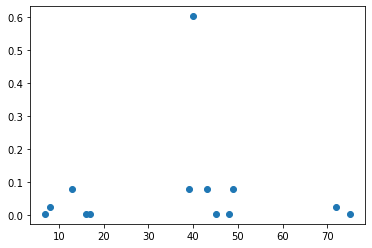

In [68]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [69]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [77]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod




def ms_hamiltonian(i,j,phi,p):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        if p == 0:
            if k == 0 | k == 1:
                summe +=tensprod
        if p == 2:
            if k == 2 | k == 3:
                summe +=tensprod

    return summe@summe
                
matrix_part_0 = ms_hamiltonian(1,2,0,0)
ms_ham_eigenval_0, ms_ham_eigenvec_0 = scipy.linalg.eigh(matrix_part_0)

matrix_part_2 = ms_hamiltonian(1,2,0,2)
ms_ham_eigenval_2, ms_ham_eigenvec_2 = scipy.linalg.eigh(matrix_part_2)


def ms_gate_0(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_0[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_0@exponential@ms_ham_eigenvec_0.T.conj()

def ms_gate_2(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_2[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_2@exponential@ms_ham_eigenvec_2.T.conj()

In [78]:
#initial state
string = "2200"
psi_1 = np.zeros(basis.Ns)
i_1 = basis.index(string)
psi_1[i_1] = 1./np.sqrt(2)
string = "0022"
psi_2 = np.zeros(basis.Ns)
i_2 = basis.index(string)
psi_2[i_2] = 1./np.sqrt(2)

psi= psi_1+psi_2
print(np.abs(np.dot(np.conj(psi),psi))**2)

0.9999999999999996


In [86]:
import optuna
n_iter = 3000
theta = np.zeros(5*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+0", -8*np.pi, 8*np.pi)
        theta[5*i+1] = trial.suggest_float("5*"+str(i)+"+1", -4*np.pi, 4*np.pi)
        theta[5*i+2] = trial.suggest_float("5*"+str(i)+"+2", -4*np.pi, 4*np.pi)
        theta[5*i+3] = trial.suggest_float("5*"+str(i)+"+3", -4*np.pi, 4*np.pi)
        theta[5*i+4] = trial.suggest_float("5*"+str(i)+"+4", -4*np.pi, 4*np.pi)
        
            
    for i in range(N):
        psi_var = ms_gate_2(theta[5*i+0])@ms_gate_0(theta[5*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var


    cost = 1-np.abs(np.dot(np.conj(psi_var),psi))**2
    return cost

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-03 14:16:13,855] A new study created in memory with name: no-name-072440eb-eabc-4ce8-a8d6-2f26b4abd48b
[I 2022-05-03 14:16:14,181] Trial 0 finished with value: 0.9991565888665236 and parameters: {'5*0+0': 24.566416208636277, '5*0+1': -7.1178048447232385, '5*0+2': 9.01111872422345, '5*0+3': 5.900336787446303, '5*0+4': 11.825072380978757, '5*1+0': 16.217998666580385, '5*1+1': -3.8488693774736014, '5*1+2': 5.337966890802946, '5*1+3': -10.754495424673575, '5*1+4': -11.750827564573484, '5*2+0': 22.8323604505345, '5*2+1': -6.624277869017672, '5*2+2': -1.5745230867656055, '5*2+3': -5.413194819090397, '5*2+4': -9.847773953315517, '5*3+0': -4.570570314950917, '5*3+1': 6.454163312750776, '5*3+2': -11.139294935869211, '5*3+3': -11.998156896826632, '5*3+4': 6.995896906346598}. Best is trial 0 with value: 0.9991565888665236.
[I 2022-05-03 14:16:14,416] Trial 1 finished with value: 0.9999233350376692 and parameters: {'5*0+0': 0.18337345649566214, '5*0+1': -3.676243181820402, '5*0+2': -0.2

[I 2022-05-03 14:16:17,194] Trial 11 finished with value: 0.9831350625071452 and parameters: {'5*0+0': 4.22753730420417, '5*0+1': -3.0011959221986806, '5*0+2': -0.27369290368924476, '5*0+3': -3.098582698132655, '5*0+4': 0.663487272164846, '5*1+0': 3.2670681060077436, '5*1+1': -1.4322563559682828, '5*1+2': -5.481205121045203, '5*1+3': 3.3706444955511645, '5*1+4': -3.667607081834476, '5*2+0': 2.5620918877788466, '5*2+1': -1.4169462769166183, '5*2+2': -2.2030274046499, '5*2+3': -3.117675251524839, '5*2+4': 0.9741676018256326, '5*3+0': 1.3083064015415695, '5*3+1': -1.2999133390621738, '5*3+2': -2.788372717767098, '5*3+3': -4.231027252461494, '5*3+4': -0.27374623453152974}. Best is trial 2 with value: 0.952260332183285.
[I 2022-05-03 14:16:17,440] Trial 12 finished with value: 0.9995424689168301 and parameters: {'5*0+0': -0.479575330192658, '5*0+1': 0.17345265561178388, '5*0+2': -5.11419708030916, '5*0+3': 6.4337401370733405, '5*0+4': 5.485385839985601, '5*1+0': 2.664178265034563, '5*1+1': 

[I 2022-05-03 14:16:20,267] Trial 23 finished with value: 0.997517271098272 and parameters: {'5*0+0': -4.779446968314954, '5*0+1': 1.637795186543161, '5*0+2': 0.3211379249355855, '5*0+3': 2.3815920215876796, '5*0+4': -4.372623539511542, '5*1+0': -0.6192713631326967, '5*1+1': -3.646710525828324, '5*1+2': 5.130632512387648, '5*1+3': -1.4948220759166575, '5*1+4': 2.0720493389011843, '5*2+0': 2.686717146238632, '5*2+1': 1.7042604544407736, '5*2+2': -6.279935409109406, '5*2+3': 2.0436461704700757, '5*2+4': 5.249265481691745, '5*3+0': 0.23716402882954102, '5*3+1': 5.144249881847569, '5*3+2': -7.767233447923873, '5*3+3': 1.1685030558921816, '5*3+4': -7.7233905601115}. Best is trial 2 with value: 0.952260332183285.
[I 2022-05-03 14:16:20,682] Trial 24 finished with value: 0.9752572303450134 and parameters: {'5*0+0': 0.5471470174781481, '5*0+1': -0.13385393605316165, '5*0+2': -0.49141114174442413, '5*0+3': 4.337654511070961, '5*0+4': 0.9208644646621895, '5*1+0': 1.7134607442860443, '5*1+1': 3.9

[I 2022-05-03 14:16:23,489] Trial 35 finished with value: 0.9995113498145263 and parameters: {'5*0+0': -9.54734245436112, '5*0+1': -4.542460236071792, '5*0+2': -1.3490621665127471, '5*0+3': -1.0785970849867412, '5*0+4': -6.063539128480257, '5*1+0': 5.053096964290995, '5*1+1': 11.756337172794195, '5*1+2': 6.144101043897506, '5*1+3': -1.1069772005710177, '5*1+4': -1.0855942653430684, '5*2+0': 0.362339475894505, '5*2+1': 1.3638978908754351, '5*2+2': 5.113584246073805, '5*2+3': -3.2460659827905447, '5*2+4': -1.2715639034820108, '5*3+0': -3.838217934498598, '5*3+1': -4.166155301848947, '5*3+2': -12.221047550252017, '5*3+3': -2.661098058177158, '5*3+4': 4.370464450443451}. Best is trial 30 with value: 0.9093805360920681.
[I 2022-05-03 14:16:23,782] Trial 36 finished with value: 0.9980145925195081 and parameters: {'5*0+0': -10.162248699164392, '5*0+1': 4.819671039498962, '5*0+2': -4.733778839015867, '5*0+3': 0.7919374767815213, '5*0+4': -0.8916240519746299, '5*1+0': 9.556916882512887, '5*1+1'

[I 2022-05-03 14:16:26,617] Trial 47 finished with value: 0.9881361684540783 and parameters: {'5*0+0': 2.2922863619006115, '5*0+1': -1.87885516643862, '5*0+2': 0.9176765787581567, '5*0+3': 3.2390566470035957, '5*0+4': -1.257568793176451, '5*1+0': 8.640510848563185, '5*1+1': 7.696547802093457, '5*1+2': -0.27857690929581835, '5*1+3': 0.32053277734833996, '5*1+4': -1.5569243056028157, '5*2+0': -2.662908398823394, '5*2+1': 0.07865511143038262, '5*2+2': 4.303904086273328, '5*2+3': -1.2538359845054088, '5*2+4': -3.195810511580743, '5*3+0': -1.7795844657476074, '5*3+1': 7.216916355920788, '5*3+2': -3.090047769319625, '5*3+3': -5.740080402858967, '5*3+4': -1.3945358485809205}. Best is trial 30 with value: 0.9093805360920681.
[I 2022-05-03 14:16:26,912] Trial 48 finished with value: 0.9918001675335051 and parameters: {'5*0+0': -3.0126941213443024, '5*0+1': -1.237921448657505, '5*0+2': -1.687684690771773, '5*0+3': -4.434921081180071, '5*0+4': 1.1789999331615573, '5*1+0': 1.4380368478536547, '5*1

[I 2022-05-03 14:16:29,999] Trial 59 finished with value: 0.9983616906352251 and parameters: {'5*0+0': -2.016051514514042, '5*0+1': -3.3443022185590263, '5*0+2': -0.5262489951084834, '5*0+3': 6.235349495549936, '5*0+4': 9.715629291997026, '5*1+0': 6.706363137787859, '5*1+1': 0.3348576838269848, '5*1+2': 1.4450361841696815, '5*1+3': 7.06341770499424, '5*1+4': -4.7387990527478525, '5*2+0': -8.329428811814832, '5*2+1': -1.3608295297299784, '5*2+2': 7.808622789819953, '5*2+3': -3.8650847342943404, '5*2+4': -3.101198747354368, '5*3+0': 1.9799950877509604, '5*3+1': 12.006639015234239, '5*3+2': -5.655185714033834, '5*3+3': -2.065971505906809, '5*3+4': 0.46256637157788916}. Best is trial 30 with value: 0.9093805360920681.
[I 2022-05-03 14:16:30,224] Trial 60 finished with value: 0.9945659822835101 and parameters: {'5*0+0': 5.125167695854529, '5*0+1': -8.547432081249893, '5*0+2': -0.11979536097764987, '5*0+3': 1.0964561976661775, '5*0+4': -2.962833708397581, '5*1+0': 1.3172999035896575, '5*1+1'

[I 2022-05-03 14:16:33,188] Trial 71 finished with value: 0.999259184553006 and parameters: {'5*0+0': 7.134230350588749, '5*0+1': -2.4030580176812135, '5*0+2': 2.0186191864993193, '5*0+3': -2.3005699244537405, '5*0+4': -2.1847558736255532, '5*1+0': 10.474148159368, '5*1+1': 8.269668674089003, '5*1+2': 3.617512364530741, '5*1+3': 5.722410152088619, '5*1+4': -0.7097283353062602, '5*2+0': 0.7164071063886259, '5*2+1': -8.250920027917132, '5*2+2': -2.5108729815552024, '5*2+3': -7.429849483061977, '5*2+4': 4.2561957221429845, '5*3+0': -5.295158516160633, '5*3+1': 11.085162409816597, '5*3+2': -5.731378890653322, '5*3+3': -6.683588535370916, '5*3+4': -2.496813023796788}. Best is trial 30 with value: 0.9093805360920681.
[I 2022-05-03 14:16:33,414] Trial 72 finished with value: 0.9997705055614761 and parameters: {'5*0+0': -1.964593903129253, '5*0+1': -3.843821784026366, '5*0+2': 4.371543819006232, '5*0+3': 4.512292592898346, '5*0+4': -2.877693116535348, '5*1+0': 0.6690482310077854, '5*1+1': -1.9

[I 2022-05-03 14:16:36,460] Trial 83 finished with value: 0.9999981547906036 and parameters: {'5*0+0': 1.4567450274538678, '5*0+1': 0.2882361708740717, '5*0+2': -3.9273456933115316, '5*0+3': 12.320286128923698, '5*0+4': -2.0619988361871777, '5*1+0': 4.961172043153188, '5*1+1': 5.389280682887057, '5*1+2': -0.09662202664306108, '5*1+3': -1.718241112085938, '5*1+4': -4.368669604295516, '5*2+0': -0.7271902216792647, '5*2+1': -0.4606004981767873, '5*2+2': -7.733179783592111, '5*2+3': -2.578414821443848, '5*2+4': 3.4920153431642786, '5*3+0': 8.44832175598256, '5*3+1': 5.937740634569241, '5*3+2': -7.544255006327524, '5*3+3': -9.160998099743384, '5*3+4': -2.4969435234325346}. Best is trial 30 with value: 0.9093805360920681.
[I 2022-05-03 14:16:36,705] Trial 84 finished with value: 0.9996463074030745 and parameters: {'5*0+0': 2.7936998364079524, '5*0+1': -8.055671846574164, '5*0+2': 4.906389350616256, '5*0+3': 2.413478553853651, '5*0+4': -4.718567174513887, '5*1+0': 5.0654321651777146, '5*1+1':

[I 2022-05-03 14:16:39,568] Trial 95 finished with value: 0.9850790453587361 and parameters: {'5*0+0': -2.6126175116414974, '5*0+1': -4.619890298227979, '5*0+2': -4.7666633010681725, '5*0+3': 5.378963733243132, '5*0+4': 3.984962840607371, '5*1+0': 1.392590526312067, '5*1+1': 1.9787380859760466, '5*1+2': 1.9017773186905929, '5*1+3': 1.309012280022063, '5*1+4': -3.502831653689711, '5*2+0': -4.179685769857673, '5*2+1': -0.07136504118458376, '5*2+2': -8.795266211400188, '5*2+3': -1.8453741058889317, '5*2+4': 5.430475563436405, '5*3+0': 1.488152173931338, '5*3+1': 4.66205565657516, '5*3+2': 2.445723357285008, '5*3+3': -1.7838053552602906, '5*3+4': -5.13991155832379}. Best is trial 30 with value: 0.9093805360920681.
[I 2022-05-03 14:16:39,830] Trial 96 finished with value: 0.9759631959607152 and parameters: {'5*0+0': -1.866715063375071, '5*0+1': -2.0154784606986937, '5*0+2': 2.967875993547709, '5*0+3': 5.972413275966096, '5*0+4': 0.9341241489059421, '5*1+0': 4.516505398677353, '5*1+1': 5.214

[I 2022-05-03 14:16:42,794] Trial 107 finished with value: 0.9840785507079659 and parameters: {'5*0+0': 0.23169805286509626, '5*0+1': 0.29829795747405274, '5*0+2': 5.796810571473713, '5*0+3': 4.007943342672685, '5*0+4': -0.5771598743382942, '5*1+0': 4.9096998956074485, '5*1+1': 6.371705842492612, '5*1+2': 0.7436892825075806, '5*1+3': 3.384489723138254, '5*1+4': 0.3905204645789371, '5*2+0': 0.4349196034817304, '5*2+1': -4.846084543870566, '5*2+2': -1.8510206342657836, '5*2+3': -4.663785892322142, '5*2+4': 3.374724356285437, '5*3+0': -0.7530063776537852, '5*3+1': 4.740373766273903, '5*3+2': -4.706886713514301, '5*3+3': -5.62714703986356, '5*3+4': -2.560578058198078}. Best is trial 30 with value: 0.9093805360920681.
[I 2022-05-03 14:16:43,047] Trial 108 finished with value: 0.9194639431743337 and parameters: {'5*0+0': 0.9223203340229322, '5*0+1': -2.5438341603786725, '5*0+2': -0.9345078866053617, '5*0+3': 2.3578581386705286, '5*0+4': -2.3337131877001975, '5*1+0': 3.5413361012251463, '5*1+

[I 2022-05-03 14:16:45,887] Trial 119 finished with value: 0.9915420156519253 and parameters: {'5*0+0': 2.2773280471547883, '5*0+1': -2.2561943265224995, '5*0+2': -2.206795094419998, '5*0+3': 1.4727527012415238, '5*0+4': -4.5269595692294295, '5*1+0': 3.990574190995466, '5*1+1': 4.330470368617968, '5*1+2': -0.0052704763914577235, '5*1+3': -3.1159258191706707, '5*1+4': 0.8540557521005936, '5*2+0': -3.1509118806130525, '5*2+1': 0.05154718714997397, '5*2+2': -3.0345275606676907, '5*2+3': -5.294598827961102, '5*2+4': 8.127719099727718, '5*3+0': -0.5123842836343884, '5*3+1': 4.0560500065282525, '5*3+2': -0.018263961099849985, '5*3+3': -3.0801289831847587, '5*3+4': -1.4804465440237138}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:16:46,184] Trial 120 finished with value: 0.9999205263388402 and parameters: {'5*0+0': 1.133680108649643, '5*0+1': -1.3685901092677897, '5*0+2': -2.638305337363647, '5*0+3': -5.867279810338448, '5*0+4': -5.834055814162335, '5*1+0': 2.0749912156

[I 2022-05-03 14:16:48,945] Trial 131 finished with value: 0.9973495869835299 and parameters: {'5*0+0': -0.9141869138191061, '5*0+1': -7.2754084672471455, '5*0+2': 0.9184092949301954, '5*0+3': 7.354990987269715, '5*0+4': 0.7387370126796626, '5*1+0': 2.9798908972875875, '5*1+1': 8.98865661081335, '5*1+2': -1.0921712577017466, '5*1+3': -3.436260997425597, '5*1+4': 6.27756140675287, '5*2+0': 0.39648167119980426, '5*2+1': -1.2738453621281929, '5*2+2': -4.863072976679656, '5*2+3': -9.762828683062146, '5*2+4': 9.498714133728308, '5*3+0': 2.399993490243105, '5*3+1': 10.804505750838928, '5*3+2': -1.6714343452183538, '5*3+3': -4.205684190262483, '5*3+4': -2.468226666606106}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:16:49,171] Trial 132 finished with value: 0.9948459500982361 and parameters: {'5*0+0': -0.596417866593832, '5*0+1': -4.023855109617381, '5*0+2': 3.9063568214387856, '5*0+3': 2.394707878856333, '5*0+4': 1.0435117123150557, '5*1+0': 9.740199752618173, '5*1+1':

[I 2022-05-03 14:16:51,730] Trial 143 finished with value: 0.9998938864699939 and parameters: {'5*0+0': 4.413946310996925, '5*0+1': -4.861064719842475, '5*0+2': 2.7672639178011513, '5*0+3': 7.29196355885167, '5*0+4': -3.8997346231113346, '5*1+0': 5.366115047775443, '5*1+1': 8.290526164295347, '5*1+2': -4.9823093742298745, '5*1+3': -0.9512339704334415, '5*1+4': -3.569842221472392, '5*2+0': -6.7530472792863625, '5*2+1': -3.056086474303911, '5*2+2': -6.829184444427839, '5*2+3': -9.746478153634289, '5*2+4': 7.063186117859161, '5*3+0': -1.4590858579223687, '5*3+1': 9.733867584233666, '5*3+2': -3.092059009582517, '5*3+3': -8.011080364671196, '5*3+4': -2.124102967986759}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:16:51,965] Trial 144 finished with value: 0.999376938649818 and parameters: {'5*0+0': 6.1842361651330755, '5*0+1': -5.3994097909602585, '5*0+2': 1.542784937522729, '5*0+3': 3.4874372183564497, '5*0+4': 2.9659315530186108, '5*1+0': 2.067560383499501, '5*1+1': 

[I 2022-05-03 14:16:54,506] Trial 155 finished with value: 0.999996114882298 and parameters: {'5*0+0': 4.954010298484635, '5*0+1': -4.007593479447744, '5*0+2': -0.6886057760462759, '5*0+3': 5.757624126469126, '5*0+4': 2.220044014675639, '5*1+0': 2.5227174055171937, '5*1+1': 7.7017686969938985, '5*1+2': -5.463522723758371, '5*1+3': 1.2210734499215747, '5*1+4': 0.5474279693522934, '5*2+0': -1.569677730738024, '5*2+1': 0.23709590514552703, '5*2+2': -5.579813663709766, '5*2+3': -8.929113443439434, '5*2+4': 5.6359949655050805, '5*3+0': -0.6415013474325155, '5*3+1': 5.202462691518382, '5*3+2': -1.6865363325029903, '5*3+3': -8.816932336589117, '5*3+4': 2.783938955017417}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:16:54,735] Trial 156 finished with value: 0.9999894328025518 and parameters: {'5*0+0': 5.400881628945779, '5*0+1': -10.927805315753613, '5*0+2': 2.4317397859105503, '5*0+3': -2.1764623992214034, '5*0+4': 3.9503845941071627, '5*1+0': 6.577913330085346, '5*1+1'

[I 2022-05-03 14:16:57,620] Trial 167 finished with value: 0.9998853922251749 and parameters: {'5*0+0': 1.6072033861595307, '5*0+1': -2.8529063978324123, '5*0+2': -1.9665890336459553, '5*0+3': 6.145369248624968, '5*0+4': 2.855473908076542, '5*1+0': -0.061137468556784036, '5*1+1': 9.98000733661539, '5*1+2': -3.3585365246932546, '5*1+3': 1.8360314747809308, '5*1+4': -0.47304968099898836, '5*2+0': 1.8316225563480115, '5*2+1': -3.5505206303756465, '5*2+2': -10.886522970909235, '5*2+3': -3.139055649988814, '5*2+4': 1.3126275362693258, '5*3+0': -0.16711320965094673, '5*3+1': 6.375774799878786, '5*3+2': -8.754721541001304, '5*3+3': -8.083645053648054, '5*3+4': -2.7365388984393517}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:16:57,854] Trial 168 finished with value: 0.9777579613294457 and parameters: {'5*0+0': 9.18188389782797, '5*0+1': -4.7922246161127635, '5*0+2': -4.501694314383277, '5*0+3': 4.325040849609589, '5*0+4': 3.522737890688947, '5*1+0': 7.754024221864373, '

[I 2022-05-03 14:17:00,536] Trial 179 finished with value: 0.9976400656582338 and parameters: {'5*0+0': 3.779022315933779, '5*0+1': -5.5957951120975284, '5*0+2': -4.690373240301863, '5*0+3': 6.7613575232838405, '5*0+4': 2.749143479329092, '5*1+0': 8.008079328387584, '5*1+1': 10.265269548235178, '5*1+2': -4.160615252037248, '5*1+3': 1.044554454015537, '5*1+4': -3.5294432492206593, '5*2+0': -0.3147468360299106, '5*2+1': -2.618693918127068, '5*2+2': -0.7088218358614249, '5*2+3': -8.90481143064822, '5*2+4': 11.44482930346306, '5*3+0': 2.358732167399201, '5*3+1': 6.893416994611724, '5*3+2': 2.5429914551901134, '5*3+3': -10.404113872843382, '5*3+4': -2.9240936402532807}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:00,759] Trial 180 finished with value: 0.9972779326292885 and parameters: {'5*0+0': 6.545332599719372, '5*0+1': -5.963713337690874, '5*0+2': 0.26340013769534565, '5*0+3': 5.73525952684838, '5*0+4': 0.8400420524353498, '5*1+0': 6.592277741576749, '5*1+1': 3

[I 2022-05-03 14:17:03,266] Trial 191 finished with value: 0.9863688590143356 and parameters: {'5*0+0': 5.172722671799312, '5*0+1': -1.2911846296843232, '5*0+2': -0.555802897137092, '5*0+3': 3.6248405866979674, '5*0+4': 3.620296311887828, '5*1+0': 3.8181452569487684, '5*1+1': 5.927920183268361, '5*1+2': -6.003726659968713, '5*1+3': -0.2642572579071255, '5*1+4': -1.059739193497835, '5*2+0': 0.7034497569161573, '5*2+1': 2.524316904783397, '5*2+2': -6.022325166403054, '5*2+3': -4.552676843821939, '5*2+4': 8.767803345487714, '5*3+0': -0.5415411854650666, '5*3+1': 8.807086877042924, '5*3+2': 3.817090255281438, '5*3+3': -6.431740876553255, '5*3+4': -1.0981390709476213}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:03,485] Trial 192 finished with value: 0.9986454455055989 and parameters: {'5*0+0': 1.4313170418744092, '5*0+1': -6.074315347313781, '5*0+2': -0.8881469824460946, '5*0+3': 3.0156757384722077, '5*0+4': 0.9200206136233899, '5*1+0': 2.1112757257996724, '5*1+1'

[I 2022-05-03 14:17:06,009] Trial 203 finished with value: 0.999143700587884 and parameters: {'5*0+0': 4.973311756919005, '5*0+1': -6.415131394666358, '5*0+2': -1.5962270888521086, '5*0+3': 2.547144111065764, '5*0+4': 2.465894586415706, '5*1+0': 4.689189426560449, '5*1+1': 7.056409463113334, '5*1+2': -7.4855183560780505, '5*1+3': 1.2349342097616818, '5*1+4': -2.8161985997041348, '5*2+0': -2.209363444560239, '5*2+1': 3.4777086073596344, '5*2+2': -3.8330473379001075, '5*2+3': -5.915769299614315, '5*2+4': 5.663923319946603, '5*3+0': 1.126626794072446, '5*3+1': 8.268377368317184, '5*3+2': 5.058447150308534, '5*3+3': -4.95020218435257, '5*3+4': -1.8084488302628918}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:06,252] Trial 204 finished with value: 0.9931195278446029 and parameters: {'5*0+0': 3.2938589746291247, '5*0+1': -4.578683541884451, '5*0+2': -1.2379600106994757, '5*0+3': 6.359108480373214, '5*0+4': 3.8975277025816264, '5*1+0': 6.358186533856674, '5*1+1': 5.1

[I 2022-05-03 14:17:09,110] Trial 215 finished with value: 0.9999158129002199 and parameters: {'5*0+0': 2.637368801095108, '5*0+1': -7.050342908523154, '5*0+2': -0.45022344571188966, '5*0+3': 2.400309330739954, '5*0+4': 0.575865218282607, '5*1+0': 7.372288487563327, '5*1+1': 6.757478584975555, '5*1+2': -8.670012985045581, '5*1+3': 0.27202233152478317, '5*1+4': -4.050553253201164, '5*2+0': -2.303621184211101, '5*2+1': 0.19595136692431847, '5*2+2': -3.054772855123522, '5*2+3': -9.002635223798226, '5*2+4': 4.162236075208148, '5*3+0': 2.3081835793559513, '5*3+1': 10.494013565563156, '5*3+2': 6.5178047034313, '5*3+3': -3.490479028153631, '5*3+4': -6.048049441262335}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:09,321] Trial 216 finished with value: 0.9996688077163893 and parameters: {'5*0+0': 5.113440184520748, '5*0+1': -3.9575039296890386, '5*0+2': -2.9917552634470788, '5*0+3': 2.5497850862182148, '5*0+4': 0.32507714137126476, '5*1+0': 6.727739569049817, '5*1+1': 

[I 2022-05-03 14:17:12,148] Trial 227 finished with value: 0.999940964829933 and parameters: {'5*0+0': -0.3532278705391272, '5*0+1': -3.333546269324246, '5*0+2': -5.944663696313515, '5*0+3': 1.5069460462752753, '5*0+4': 1.4854544281539352, '5*1+0': 6.487122725846095, '5*1+1': 2.6700330691529937, '5*1+2': -3.450951238661381, '5*1+3': -8.58949612180735, '5*1+4': -1.5690190704409228, '5*2+0': -0.447297196895327, '5*2+1': 0.912571452520017, '5*2+2': 0.051402875951489735, '5*2+3': -4.881813323531853, '5*2+4': 9.504007314205191, '5*3+0': -0.8668110994883802, '5*3+1': 4.576185871249652, '5*3+2': 3.1429708750421317, '5*3+3': -0.9941807113173253, '5*3+4': -5.467945146672006}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:12,388] Trial 228 finished with value: 0.9453586824078869 and parameters: {'5*0+0': 3.2780566391287755, '5*0+1': -2.698437686186164, '5*0+2': -3.009253621861023, '5*0+3': -1.0665626897880887, '5*0+4': 6.730787099419592, '5*1+0': 9.25339589675242, '5*1+1'

[I 2022-05-03 14:17:15,156] Trial 239 finished with value: 0.9966366279603059 and parameters: {'5*0+0': 5.542141702584526, '5*0+1': 0.43678896347915375, '5*0+2': 0.9678671766131202, '5*0+3': -2.0293773661903414, '5*0+4': 3.754061339095231, '5*1+0': 7.5322571688986155, '5*1+1': 10.817570184568083, '5*1+2': -5.269589848762213, '5*1+3': -3.4541846508939766, '5*1+4': -7.367319237774247, '5*2+0': 2.4697220838142284, '5*2+1': 1.8318405402657376, '5*2+2': -1.88343966214841, '5*2+3': -5.898184176356739, '5*2+4': 11.619188706630183, '5*3+0': 3.8543010997148412, '5*3+1': 8.806096873994637, '5*3+2': 1.1949217381598953, '5*3+3': -0.695289703356787, '5*3+4': -5.322207221707145}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:15,431] Trial 240 finished with value: 0.9834573442372985 and parameters: {'5*0+0': 2.632904298047584, '5*0+1': -3.5234589051079332, '5*0+2': -2.7577577574487453, '5*0+3': -2.506212931736927, '5*0+4': 5.266601677246374, '5*1+0': 8.221943382325279, '5*1+1'

[I 2022-05-03 14:17:18,195] Trial 251 finished with value: 0.9997911109717215 and parameters: {'5*0+0': 2.0059537783381, '5*0+1': -1.25441848216063, '5*0+2': -0.0575383720580005, '5*0+3': -5.121908137862974, '5*0+4': 5.269504394042666, '5*1+0': 10.706837248199372, '5*1+1': 5.113379377165336, '5*1+2': -3.5070183383650972, '5*1+3': -2.354948055905162, '5*1+4': -4.177591119783032, '5*2+0': -0.269831430639369, '5*2+1': 4.477765318038546, '5*2+2': 1.5856841048128598, '5*2+3': -9.095740125741077, '5*2+4': 3.1237995696707923, '5*3+0': 4.288475537639279, '5*3+1': 6.373698392219725, '5*3+2': 4.922803700784922, '5*3+3': 0.18039630380442506, '5*3+4': -12.255498100312156}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:18,467] Trial 252 finished with value: 0.9933690003549759 and parameters: {'5*0+0': 3.8373655304927823, '5*0+1': -3.5969893071006824, '5*0+2': -0.331729480499118, '5*0+3': -1.5319972693680282, '5*0+4': 6.03286617162158, '5*1+0': 11.22261146216588, '5*1+1': 5.2

[I 2022-05-03 14:17:21,128] Trial 263 finished with value: 0.9754545794559932 and parameters: {'5*0+0': 1.3393333406614438, '5*0+1': -3.73694059582927, '5*0+2': -2.3066181072607606, '5*0+3': 0.1871288260184487, '5*0+4': 8.535199080266704, '5*1+0': 7.857052266173513, '5*1+1': 3.786880976894565, '5*1+2': 2.0860750470620655, '5*1+3': -5.589637448762668, '5*1+4': -7.948111457288751, '5*2+0': -0.04935123097907712, '5*2+1': 4.930048805676413, '5*2+2': -3.4275976354081923, '5*2+3': -1.1633883403072387, '5*2+4': 1.8955111061930003, '5*3+0': 4.407290693723519, '5*3+1': -0.6983828679758304, '5*3+2': 5.330662846657444, '5*3+3': -1.8645544644575702, '5*3+4': -8.64381421726581}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:21,327] Trial 264 finished with value: 0.9999929224427582 and parameters: {'5*0+0': 1.408894713649865, '5*0+1': 0.5780917929444209, '5*0+2': 1.5491712031388154, '5*0+3': -1.5479738231615956, '5*0+4': 3.6608669848985484, '5*1+0': 6.355928077488811, '5*1+1'

[I 2022-05-03 14:17:23,972] Trial 275 finished with value: 0.9999359203532315 and parameters: {'5*0+0': 1.8493379004000716, '5*0+1': -6.783169822646929, '5*0+2': -2.506097196512594, '5*0+3': -0.6126607454067463, '5*0+4': 3.3440963777447994, '5*1+0': 5.512970454571144, '5*1+1': 6.7067005643255975, '5*1+2': -6.42161227868048, '5*1+3': -6.759585474222039, '5*1+4': -2.394108454652839, '5*2+0': 2.4929808368925763, '5*2+1': 2.148123608136719, '5*2+2': -2.456604671772179, '5*2+3': -1.9715810024684701, '5*2+4': 3.609693147939267, '5*3+0': 3.2765636007165866, '5*3+1': 11.008132319006613, '5*3+2': 8.94065765455967, '5*3+3': -2.3322041600746495, '5*3+4': -11.021260764750803}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:24,242] Trial 276 finished with value: 0.9999773703117371 and parameters: {'5*0+0': 0.5895910395144024, '5*0+1': -2.830878744474681, '5*0+2': -4.498223265023582, '5*0+3': -2.8938884307078134, '5*0+4': 3.905478872481364, '5*1+0': 9.07948692265238, '5*1+1': 

[I 2022-05-03 14:17:26,872] Trial 287 finished with value: 0.9856574496481852 and parameters: {'5*0+0': 4.747900478501589, '5*0+1': -2.7097857227555004, '5*0+2': -1.8612501888285689, '5*0+3': -3.5356715884171575, '5*0+4': 4.753466275503304, '5*1+0': 1.4874759202786771, '5*1+1': 1.6364800337607646, '5*1+2': -5.771101532522754, '5*1+3': -5.727600436802677, '5*1+4': -8.280154396449179, '5*2+0': -2.2205643108920756, '5*2+1': 4.2966475880043085, '5*2+2': -7.112419980545413, '5*2+3': 2.910257717632093, '5*2+4': -0.903607164056571, '5*3+0': 3.4899436497057468, '5*3+1': 7.7133703708539505, '5*3+2': 6.804112362034189, '5*3+3': -0.9563264794780393, '5*3+4': -8.082605426892686}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:27,103] Trial 288 finished with value: 0.9657274681123426 and parameters: {'5*0+0': 3.213287971479666, '5*0+1': -7.386698770363647, '5*0+2': -2.3342472579451625, '5*0+3': -2.0226290405483853, '5*0+4': -0.5643922216392196, '5*1+0': 11.832736178491192, '5

[I 2022-05-03 14:17:29,863] Trial 299 finished with value: 0.9914156698601341 and parameters: {'5*0+0': 8.341853917919593, '5*0+1': -4.647319598100519, '5*0+2': 1.5329351466983576, '5*0+3': -0.29160018760036865, '5*0+4': -0.7153532166933037, '5*1+0': 6.911484451450706, '5*1+1': 6.588329988638964, '5*1+2': -2.6454436708181315, '5*1+3': -8.207234306907532, '5*1+4': -10.25163507131801, '5*2+0': -3.345257200137408, '5*2+1': 0.6253148267578257, '5*2+2': -4.655301536405462, '5*2+3': 1.4693893627999415, '5*2+4': 1.6751817322039821, '5*3+0': 5.117026778311831, '5*3+1': 10.420531430229909, '5*3+2': 5.754694093602151, '5*3+3': -0.11981765231620711, '5*3+4': -9.062382770249872}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:30,159] Trial 300 finished with value: 0.9918080516999022 and parameters: {'5*0+0': 6.010189473359257, '5*0+1': -1.2979683505816655, '5*0+2': -2.980085380429629, '5*0+3': -4.548599983138454, '5*0+4': 6.839048400420342, '5*1+0': 6.138212379178828, '5*1+1

[I 2022-05-03 14:17:33,032] Trial 311 finished with value: 0.988619104318952 and parameters: {'5*0+0': 6.686846798087973, '5*0+1': -1.9358351358098318, '5*0+2': -1.7532554979263897, '5*0+3': -1.874940280303918, '5*0+4': -2.3130685379019793, '5*1+0': 0.8655713129734108, '5*1+1': 0.7132998077406723, '5*1+2': -1.0160095703773577, '5*1+3': -11.52462500863998, '5*1+4': -7.179259452986419, '5*2+0': 0.4786126322637112, '5*2+1': 4.031254745439986, '5*2+2': -1.197805100835451, '5*2+3': 5.083161084976719, '5*2+4': -1.9679319025426625, '5*3+0': 3.6113154595700503, '5*3+1': 6.726140206722857, '5*3+2': 8.371181775663928, '5*3+3': 2.7671601721812715, '5*3+4': -1.6829382855344956}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:33,320] Trial 312 finished with value: 0.9873825685452706 and parameters: {'5*0+0': 3.0580734390394335, '5*0+1': 1.9758779094491405, '5*0+2': -6.554769812871585, '5*0+3': -0.809233737865914, '5*0+4': -0.22450777071312406, '5*1+0': 6.713000360549916, '5*1

[I 2022-05-03 14:17:36,176] Trial 323 finished with value: 0.9420024131735418 and parameters: {'5*0+0': 4.665017516212844, '5*0+1': -2.2936055508763546, '5*0+2': -4.104561061944766, '5*0+3': 0.9905266099290602, '5*0+4': 0.7452614898089189, '5*1+0': 6.640760727210686, '5*1+1': -0.8855875050699455, '5*1+2': -6.962468588165164, '5*1+3': -6.006562775664455, '5*1+4': -10.804847963390312, '5*2+0': -8.941116521048357, '5*2+1': 3.451363506265805, '5*2+2': 5.061571486278536, '5*2+3': 4.561979625030387, '5*2+4': -1.7387493689868598, '5*3+0': 9.704251456958566, '5*3+1': 9.989388292494052, '5*3+2': 8.76838595364412, '5*3+3': 8.694826428612519, '5*3+4': -2.9115521496622394}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:36,464] Trial 324 finished with value: 0.9999999993700247 and parameters: {'5*0+0': 6.037247144272902, '5*0+1': -0.252204819038653, '5*0+2': 0.3107211839993054, '5*0+3': 1.1278129511938881, '5*0+4': -5.581703168481226, '5*1+0': 7.566206797682792, '5*1+1': -0.

[I 2022-05-03 14:17:39,272] Trial 335 finished with value: 0.9998890091771175 and parameters: {'5*0+0': 9.684485333149656, '5*0+1': 0.9238480383292211, '5*0+2': -2.3541266594260617, '5*0+3': 6.387234314899067, '5*0+4': -4.0671117132965104, '5*1+0': 2.1112705646905683, '5*1+1': 1.6365536542095285, '5*1+2': -6.978964319557653, '5*1+3': -1.9817483623698111, '5*1+4': -8.637367030211543, '5*2+0': -8.680305430395613, '5*2+1': -0.13500974994993276, '5*2+2': -4.199909159925136, '5*2+3': 2.84726903417301, '5*2+4': -6.321822889592184, '5*3+0': 6.1904108523818895, '5*3+1': 12.360441512199364, '5*3+2': 9.218326322230627, '5*3+3': -0.519085987728634, '5*3+4': -6.830747630636028}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:39,568] Trial 336 finished with value: 0.9936159779440956 and parameters: {'5*0+0': 9.891176733116513, '5*0+1': -0.5623012415349599, '5*0+2': 2.917129214127624, '5*0+3': -0.3850356903456036, '5*0+4': 1.4743714331669602, '5*1+0': 6.236109350828536, '5*1+1

[I 2022-05-03 14:17:42,400] Trial 347 finished with value: 0.9987096824686555 and parameters: {'5*0+0': 6.722084485851261, '5*0+1': -0.7611380442046295, '5*0+2': 1.1902864229704655, '5*0+3': 2.5473036433518077, '5*0+4': -0.3770560505625924, '5*1+0': 12.305174216243246, '5*1+1': 7.963038099740261, '5*1+2': -7.559400655465433, '5*1+3': -5.521833460798751, '5*1+4': -9.78129945877862, '5*2+0': -1.7408821975408162, '5*2+1': 5.267788444623434, '5*2+2': 0.14335279048907879, '5*2+3': -2.094257587072868, '5*2+4': 6.622054838934501, '5*3+0': 11.01722450709593, '5*3+1': 9.78204153811831, '5*3+2': 6.515197931956651, '5*3+3': 0.5446735312859543, '5*3+4': -7.809713020691024}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:42,650] Trial 348 finished with value: 0.9999891353101765 and parameters: {'5*0+0': 10.514727027248947, '5*0+1': -1.9072896688828227, '5*0+2': 8.071794451947952, '5*0+3': 6.384516678004016, '5*0+4': -0.3613321357620638, '5*1+0': 7.213676387606672, '5*1+1': 0.

[I 2022-05-03 14:17:45,551] Trial 359 finished with value: 0.9944378755547107 and parameters: {'5*0+0': 7.444798933461451, '5*0+1': 0.17318338226962876, '5*0+2': 3.4621875286624437, '5*0+3': 6.597114735863768, '5*0+4': 5.7666388286232735, '5*1+0': 12.101340614347354, '5*1+1': 6.770779131995775, '5*1+2': -8.336827228571291, '5*1+3': -10.183261242715327, '5*1+4': -7.887840089818452, '5*2+0': -4.307689495740119, '5*2+1': 2.3810933394720175, '5*2+2': -6.446385999928632, '5*2+3': 0.40429709326760976, '5*2+4': 5.347177429028752, '5*3+0': 12.74735825677517, '5*3+1': 6.584621695960034, '5*3+2': 3.7625345813703728, '5*3+3': -10.208763908595134, '5*3+4': -4.5130959862919315}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:45,795] Trial 360 finished with value: 0.9976302668208832 and parameters: {'5*0+0': 15.136149374026939, '5*0+1': 2.552377002996784, '5*0+2': 0.793035845959593, '5*0+3': 5.321048445140773, '5*0+4': 3.8710326908854866, '5*1+0': 5.927812674678688, '5*1+1': -

[I 2022-05-03 14:17:48,702] Trial 371 finished with value: 0.9996947324377613 and parameters: {'5*0+0': 3.3647007265530764, '5*0+1': -5.512377497419969, '5*0+2': -2.1600133446508383, '5*0+3': 0.7183922220498946, '5*0+4': 6.446473962113485, '5*1+0': 6.15974368881108, '5*1+1': 3.0903086234345833, '5*1+2': -3.26859740345653, '5*1+3': -7.707404166710582, '5*1+4': -2.1488490623908643, '5*2+0': -4.578580977512467, '5*2+1': 7.2913611391141835, '5*2+2': -2.5291209399816332, '5*2+3': 5.775562341779821, '5*2+4': 8.668283390017459, '5*3+0': 9.845244838383955, '5*3+1': 4.26430686576013, '5*3+2': 7.107325802242813, '5*3+3': -0.20647334779599136, '5*3+4': -6.0067553542899335}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:48,917] Trial 372 finished with value: 0.9921591046872568 and parameters: {'5*0+0': 4.536306091392468, '5*0+1': -1.223304943452301, '5*0+2': -6.7022148944280255, '5*0+3': 2.8758711914790487, '5*0+4': 3.005690322653831, '5*1+0': 9.134344644005717, '5*1+1': 0.

[I 2022-05-03 14:17:51,809] Trial 383 finished with value: 0.9920633831713568 and parameters: {'5*0+0': 2.307936463802686, '5*0+1': -6.623380304122767, '5*0+2': -2.512956072715384, '5*0+3': 1.884604458233336, '5*0+4': 0.25060985779339084, '5*1+0': 11.194306533847325, '5*1+1': 1.521737253566815, '5*1+2': -10.96751995284541, '5*1+3': -8.204046367956632, '5*1+4': -11.88902473296238, '5*2+0': -3.038700675792624, '5*2+1': -1.3876144307768932, '5*2+2': -8.30516626886577, '5*2+3': 3.938388755078171, '5*2+4': 3.8685071478149404, '5*3+0': 6.340072304694509, '5*3+1': 9.390763730764155, '5*3+2': 7.747429432196305, '5*3+3': -8.564854440356651, '5*3+4': 2.0235354037128257}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:52,032] Trial 384 finished with value: 0.9511451710797934 and parameters: {'5*0+0': 7.623782204015841, '5*0+1': -0.09142917544239548, '5*0+2': -2.3044618298597968, '5*0+3': 1.0426624944214238, '5*0+4': 4.850578987776845, '5*1+0': 9.8845491416377, '5*1+1': -0.0

[I 2022-05-03 14:17:54,868] Trial 395 finished with value: 0.9980627767517359 and parameters: {'5*0+0': 4.309891776035537, '5*0+1': -1.2992112884710356, '5*0+2': -4.275902113390112, '5*0+3': 4.9850345004321674, '5*0+4': 8.808813311149606, '5*1+0': 11.684686604298525, '5*1+1': 2.3017049866091774, '5*1+2': -6.491650215683601, '5*1+3': -5.595451203785135, '5*1+4': -9.3949103785207, '5*2+0': -2.893094013649951, '5*2+1': 4.659320749979317, '5*2+2': -5.990758663461404, '5*2+3': 0.3798345204256923, '5*2+4': 1.5417960248634612, '5*3+0': 13.936578829053627, '5*3+1': 10.164444060915145, '5*3+2': 4.888325056475336, '5*3+3': -4.824601746789563, '5*3+4': -2.935198877788989}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:55,127] Trial 396 finished with value: 0.9976194630085687 and parameters: {'5*0+0': 10.428434262968509, '5*0+1': -1.9489103462448754, '5*0+2': -2.532789898438157, '5*0+3': 0.8627949804350785, '5*0+4': 4.973292189476487, '5*1+0': 11.11235781208817, '5*1+1': -3

[I 2022-05-03 14:17:57,930] Trial 407 finished with value: 0.9542188264390794 and parameters: {'5*0+0': 10.38647489478435, '5*0+1': -2.0410064838643653, '5*0+2': -4.486090505180121, '5*0+3': 4.455599732668907, '5*0+4': 0.2909735123713513, '5*1+0': 12.108863425644675, '5*1+1': 6.863682998231496, '5*1+2': -4.740472728349321, '5*1+3': -7.126299115038937, '5*1+4': -3.4022973542976933, '5*2+0': -6.523782155374728, '5*2+1': -1.5898250904837978, '5*2+2': -10.129130759328326, '5*2+3': -3.4051329006840705, '5*2+4': 9.171136394915765, '5*3+0': 6.700094782141805, '5*3+1': 12.326165881949702, '5*3+2': 2.1354491008008516, '5*3+3': -8.980090231503702, '5*3+4': -0.30354256253837664}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:17:58,161] Trial 408 finished with value: 0.9982581938578688 and parameters: {'5*0+0': 10.913698205157896, '5*0+1': -1.7205822031563294, '5*0+2': -5.180626608375485, '5*0+3': 1.434076155763008, '5*0+4': 3.7670889873834668, '5*1+0': 9.593543845627886, '5*1

[I 2022-05-03 14:18:01,034] Trial 419 finished with value: 0.9646068924381868 and parameters: {'5*0+0': 13.489812886675782, '5*0+1': -4.510501636564584, '5*0+2': -3.5455116985323283, '5*0+3': 0.628056124112256, '5*0+4': 5.469001262967064, '5*1+0': 10.348581873245974, '5*1+1': 9.800277405161909, '5*1+2': -4.373658525819042, '5*1+3': -10.639287715918657, '5*1+4': -5.143313356950261, '5*2+0': -5.232930551962779, '5*2+1': 1.7911756236585104, '5*2+2': -6.674324506427038, '5*2+3': 5.541822778442614, '5*2+4': 9.242312233647024, '5*3+0': 6.88256971752636, '5*3+1': 11.560925933556865, '5*3+2': 3.555432255061216, '5*3+3': -11.542011021287248, '5*3+4': -1.6563392682971774}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:01,276] Trial 420 finished with value: 0.9998799300117572 and parameters: {'5*0+0': 13.689815268931067, '5*0+1': -0.5822944801089766, '5*0+2': -6.698355254788491, '5*0+3': 0.9427443780379816, '5*0+4': 4.1178389234493915, '5*1+0': 10.758612951476607, '5*1+1':

[I 2022-05-03 14:18:04,195] Trial 431 finished with value: 0.9752178671552796 and parameters: {'5*0+0': 9.9811606712535, '5*0+1': -5.312962263744806, '5*0+2': -6.1402876289629775, '5*0+3': -0.07959521951074167, '5*0+4': 5.387873374270528, '5*1+0': 7.805726230418921, '5*1+1': 5.8338924919442015, '5*1+2': -4.266794240166334, '5*1+3': -4.543935896410218, '5*1+4': -2.8049588008830817, '5*2+0': -8.592057711729904, '5*2+1': -5.734861380628721, '5*2+2': -8.510624215412689, '5*2+3': 7.962335858819472, '5*2+4': 5.921402690904919, '5*3+0': 7.247535005064242, '5*3+1': 7.706156762879838, '5*3+2': 3.6176497560255667, '5*3+3': -7.3145966595586405, '5*3+4': 0.7094676412120162}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:04,439] Trial 432 finished with value: 0.9465214338545838 and parameters: {'5*0+0': 12.040805560053315, '5*0+1': -2.0535885494742003, '5*0+2': -6.352314921862555, '5*0+3': 1.3133593956084966, '5*0+4': 5.9903410978807425, '5*1+0': 5.342379781304287, '5*1+1': 

[I 2022-05-03 14:18:07,340] Trial 443 finished with value: 0.9999830150392356 and parameters: {'5*0+0': 11.077351710769355, '5*0+1': -6.806533674547741, '5*0+2': -5.051368930730122, '5*0+3': -3.1247880073621896, '5*0+4': 3.0604676681950322, '5*1+0': 8.795882367782166, '5*1+1': 4.538671633841887, '5*1+2': -5.004132704987371, '5*1+3': -8.377107456426355, '5*1+4': -5.671670604476489, '5*2+0': -9.050635834083664, '5*2+1': -2.537283911769484, '5*2+2': -5.609482525393604, '5*2+3': 4.96605049916799, '5*2+4': 1.3867265107290665, '5*3+0': 9.62750872631491, '5*3+1': 10.262200732048855, '5*3+2': 8.981965999327329, '5*3+3': -7.837701543709979, '5*3+4': -6.079368462767002}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:07,570] Trial 444 finished with value: 0.9813411831717715 and parameters: {'5*0+0': 5.3517964070062165, '5*0+1': -4.786205434659724, '5*0+2': -8.447087462602864, '5*0+3': -2.955918255979136, '5*0+4': 4.7927374686229784, '5*1+0': 12.492605508322931, '5*1+1': 3.

[I 2022-05-03 14:18:10,500] Trial 455 finished with value: 0.9995790795589197 and parameters: {'5*0+0': 9.03588528511524, '5*0+1': -2.670061919512758, '5*0+2': -6.948938739166539, '5*0+3': 3.856303610008987, '5*0+4': 2.091597378720904, '5*1+0': 10.472559944498801, '5*1+1': 6.399092112029175, '5*1+2': -1.663851407717943, '5*1+3': -9.581474053271098, '5*1+4': -4.473098737543827, '5*2+0': -1.6820339776444344, '5*2+1': -5.991408934207085, '5*2+2': -4.384372355191903, '5*2+3': 3.5519720792088307, '5*2+4': 4.168553767477052, '5*3+0': 1.226572423072577, '5*3+1': 8.542573189886696, '5*3+2': 5.9319959335627175, '5*3+3': -8.346652406733776, '5*3+4': 4.903559271253393}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:10,721] Trial 456 finished with value: 0.9572315096039509 and parameters: {'5*0+0': 8.047732974187797, '5*0+1': -4.68577810091254, '5*0+2': -5.50828265931707, '5*0+3': 0.5580448721378217, '5*0+4': 1.233304903412766, '5*1+0': 7.40122688202781, '5*1+1': 0.21053820

[I 2022-05-03 14:18:13,308] Trial 467 finished with value: 0.9999941930612629 and parameters: {'5*0+0': 7.921836644487652, '5*0+1': 2.06216173221296, '5*0+2': -6.713943425211841, '5*0+3': 0.1043340360968199, '5*0+4': 0.025547792152182947, '5*1+0': 7.808944147227869, '5*1+1': -0.1898651064164376, '5*1+2': -3.2306148875104155, '5*1+3': -0.29637506866475327, '5*1+4': -8.5037411754019, '5*2+0': -2.3710931761648126, '5*2+1': 0.8183467297483729, '5*2+2': -8.398362867894566, '5*2+3': 5.748588658212644, '5*2+4': 6.313935042399974, '5*3+0': 8.613636928049102, '5*3+1': 12.44162066562181, '5*3+2': 7.057313213423578, '5*3+3': -5.95491682221328, '5*3+4': -0.6777427004912187}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:13,550] Trial 468 finished with value: 0.99678787273741 and parameters: {'5*0+0': 10.138803719290172, '5*0+1': -6.309929655952917, '5*0+2': -4.921490430754272, '5*0+3': 4.06223120076638, '5*0+4': 0.9128859466256471, '5*1+0': 3.5756353435933477, '5*1+1': 3.79

[I 2022-05-03 14:18:16,130] Trial 479 finished with value: 0.999637726246017 and parameters: {'5*0+0': 8.389890414028295, '5*0+1': -3.461474130765049, '5*0+2': -6.233500560511017, '5*0+3': 3.1627970167460395, '5*0+4': 1.8280510612636474, '5*1+0': 9.598374894709677, '5*1+1': 5.795407394181239, '5*1+2': -0.9712991989325583, '5*1+3': -7.086090127911435, '5*1+4': -10.475265363925972, '5*2+0': -6.571963971110007, '5*2+1': -1.9836157578441025, '5*2+2': -5.580165212442518, '5*2+3': 7.482313704934402, '5*2+4': 10.01967839632668, '5*3+0': 4.480935433001346, '5*3+1': 9.621748629285428, '5*3+2': 7.817390502936479, '5*3+3': -10.606079121785639, '5*3+4': 4.0352106269403984}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:16,376] Trial 480 finished with value: 0.991820332871342 and parameters: {'5*0+0': 9.083703964216038, '5*0+1': -5.692943508441999, '5*0+2': -9.015392692979471, '5*0+3': 3.683546518549284, '5*0+4': 0.555052221015923, '5*1+0': 6.858150299650287, '5*1+1': 7.3920

[I 2022-05-03 14:18:18,942] Trial 491 finished with value: 0.9920259033068082 and parameters: {'5*0+0': 3.8034743311001176, '5*0+1': -2.5001487788809658, '5*0+2': -7.1396055524131095, '5*0+3': 4.761185274310135, '5*0+4': 1.4863780464006928, '5*1+0': 10.770108834746356, '5*1+1': 6.611954317709088, '5*1+2': -2.28855038353017, '5*1+3': -6.211086143897155, '5*1+4': -9.806288113094768, '5*2+0': -8.522187124716185, '5*2+1': -4.374882632001007, '5*2+2': -4.103544955515351, '5*2+3': 4.399610495514684, '5*2+4': 4.171805762324759, '5*3+0': 9.598515059061297, '5*3+1': 10.060787779844539, '5*3+2': 6.580757907703264, '5*3+3': -7.897887262538149, '5*3+4': 0.5851909410758565}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:19,176] Trial 492 finished with value: 0.9998948128068837 and parameters: {'5*0+0': 7.630979484398887, '5*0+1': -2.9483506337258274, '5*0+2': -8.961267476394228, '5*0+3': 6.578815947024913, '5*0+4': 1.5261932828523699, '5*1+0': 7.041681416087492, '5*1+1': 5.5

[I 2022-05-03 14:18:21,737] Trial 503 finished with value: 0.9902425471424794 and parameters: {'5*0+0': 3.954875392983888, '5*0+1': -2.8525244675242054, '5*0+2': -6.829914814311689, '5*0+3': 10.709672898770624, '5*0+4': 4.00042983366859, '5*1+0': 10.892640824107382, '5*1+1': 2.5104853064408292, '5*1+2': -3.7155119789073847, '5*1+3': -8.214697444138784, '5*1+4': -8.356301272895465, '5*2+0': -6.290889871326347, '5*2+1': -3.4913436087456944, '5*2+2': -3.2546387384390165, '5*2+3': 6.483073856526342, '5*2+4': 5.003538573122294, '5*3+0': 6.372503319612041, '5*3+1': 4.970116145418734, '5*3+2': 9.016882649540392, '5*3+3': -8.433422923733804, '5*3+4': -0.43770253492905664}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:21,983] Trial 504 finished with value: 0.9999510836061142 and parameters: {'5*0+0': 7.629395591812977, '5*0+1': -5.52743181863709, '5*0+2': -6.422453889960682, '5*0+3': 6.970631075348386, '5*0+4': 0.014756694549246774, '5*1+0': 9.435095791381947, '5*1+1': 

[I 2022-05-03 14:18:24,522] Trial 515 finished with value: 0.9976792351107722 and parameters: {'5*0+0': 5.901625541449777, '5*0+1': -2.5409440004675354, '5*0+2': -12.045449960662257, '5*0+3': 7.874622891305825, '5*0+4': 0.27664937594164996, '5*1+0': 9.327214257024792, '5*1+1': 2.5908141792998323, '5*1+2': -3.008723941379553, '5*1+3': -5.215684644967297, '5*1+4': -4.271184638944214, '5*2+0': -7.089320411816089, '5*2+1': 0.25774208047939595, '5*2+2': -2.6479803953882515, '5*2+3': 5.9248634830807685, '5*2+4': 4.874937612921558, '5*3+0': 5.823756789829481, '5*3+1': 12.051604570332938, '5*3+2': 8.84514663825771, '5*3+3': -9.243334536918695, '5*3+4': 3.170088818924384}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:24,754] Trial 516 finished with value: 0.998316909979782 and parameters: {'5*0+0': 6.324999413649842, '5*0+1': -4.319591341389605, '5*0+2': -9.746839351623862, '5*0+3': 4.900044637287818, '5*0+4': 3.984628442581191, '5*1+0': 9.453337652878092, '5*1+1': 6.38

[I 2022-05-03 14:18:27,305] Trial 527 finished with value: 0.9977576376325356 and parameters: {'5*0+0': 5.997528777460927, '5*0+1': -5.594715071643419, '5*0+2': -10.477024427002654, '5*0+3': 6.606447897429731, '5*0+4': 2.71257618012944, '5*1+0': 12.823233740065215, '5*1+1': 8.41940159846606, '5*1+2': -2.085381303080318, '5*1+3': -6.955993682570386, '5*1+4': -8.862481627399342, '5*2+0': -8.797244727216503, '5*2+1': -3.480372538332125, '5*2+2': -5.291791663758889, '5*2+3': 6.8221803467407245, '5*2+4': 2.6567749131456737, '5*3+0': 7.641152411867589, '5*3+1': 5.981496388345615, '5*3+2': 8.411867454480552, '5*3+3': -7.265720277025268, '5*3+4': 2.8842237201198326}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:27,540] Trial 528 finished with value: 0.9859667496622218 and parameters: {'5*0+0': 3.0570857278556725, '5*0+1': -1.1316056513363626, '5*0+2': -10.712919727774239, '5*0+3': 7.101225361300168, '5*0+4': 5.265590289538721, '5*1+0': 11.482631583831626, '5*1+1': 8.33

[I 2022-05-03 14:18:30,320] Trial 539 finished with value: 0.9997959882346164 and parameters: {'5*0+0': 3.3143445909985614, '5*0+1': -1.3536377992458575, '5*0+2': -8.939352073195485, '5*0+3': 5.437405107940687, '5*0+4': 4.385517122331098, '5*1+0': 12.237751985083543, '5*1+1': 3.929756657806003, '5*1+2': -5.234923938977894, '5*1+3': -2.9540579512014458, '5*1+4': -7.85771327270256, '5*2+0': -6.80196626886085, '5*2+1': -2.7957048069220742, '5*2+2': -3.091338938729981, '5*2+3': 2.9776215155473413, '5*2+4': 3.230321296516519, '5*3+0': 4.073651544572616, '5*3+1': 4.513850386629559, '5*3+2': 8.609306668542569, '5*3+3': -5.1705234929875825, '5*3+4': 4.589811780686816}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:30,573] Trial 540 finished with value: 0.9761291864138969 and parameters: {'5*0+0': 1.3205011348188131, '5*0+1': -2.7603315313219645, '5*0+2': -7.5126238967065575, '5*0+3': 7.150263742156369, '5*0+4': 9.04853215073825, '5*1+0': 11.371356107838967, '5*1+1': 12.

[I 2022-05-03 14:18:33,285] Trial 551 finished with value: 0.9979748173125328 and parameters: {'5*0+0': 6.351475307195388, '5*0+1': 1.4640438040732675, '5*0+2': -12.263564063602528, '5*0+3': 5.8029186659885506, '5*0+4': 9.690485003662276, '5*1+0': 12.666571102676576, '5*1+1': 10.884617440655141, '5*1+2': -5.743599663442316, '5*1+3': -5.410565020478674, '5*1+4': -4.688654121350304, '5*2+0': -12.178209409500212, '5*2+1': -7.199090023226192, '5*2+2': -7.4600330343474806, '5*2+3': 2.1061889977563, '5*2+4': 2.451406252346837, '5*3+0': 6.2472516092515145, '5*3+1': 7.0524977580605235, '5*3+2': 8.277406652992408, '5*3+3': -9.873776757106157, '5*3+4': 1.8910916829780522}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:33,517] Trial 552 finished with value: 0.999247151710573 and parameters: {'5*0+0': 4.020572393348378, '5*0+1': -2.468418645509933, '5*0+2': -8.954214586970846, '5*0+3': 7.536807409085876, '5*0+4': 6.7202189598142725, '5*1+0': 10.14294807812368, '5*1+1': 7.12

[I 2022-05-03 14:18:37,027] Trial 563 finished with value: 0.9542033547996552 and parameters: {'5*0+0': 2.4964443666626583, '5*0+1': -1.8136414904119378, '5*0+2': -8.993691504573585, '5*0+3': 5.627444523434568, '5*0+4': 7.1530150060268465, '5*1+0': 13.64699736590253, '5*1+1': 6.5995215932871485, '5*1+2': -4.26138994155237, '5*1+3': -6.9709984159476, '5*1+4': -7.7812416367024415, '5*2+0': -6.552294299191053, '5*2+1': -5.212336715799671, '5*2+2': -2.3181133859849976, '5*2+3': 2.8713090836675357, '5*2+4': 3.7702683731849085, '5*3+0': 5.540416447359249, '5*3+1': 5.5323783243942275, '5*3+2': 7.993492851054409, '5*3+3': -5.420836034601797, '5*3+4': 2.7937044588880693}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:37,347] Trial 564 finished with value: 0.9987654572068767 and parameters: {'5*0+0': 4.746123869946448, '5*0+1': 1.0985915702387508, '5*0+2': -9.49443136143312, '5*0+3': 6.490386475839925, '5*0+4': 5.530935445529765, '5*1+0': 10.58472280794409, '5*1+1': 6.893

[I 2022-05-03 14:18:40,608] Trial 575 finished with value: 0.9999355730355766 and parameters: {'5*0+0': 3.485610312941706, '5*0+1': -7.991703909492402, '5*0+2': -10.777335120723178, '5*0+3': 5.013155099311979, '5*0+4': 6.144338439598847, '5*1+0': 14.15033262120197, '5*1+1': 5.655602791555295, '5*1+2': -4.382425978620485, '5*1+3': 0.040076540389268445, '5*1+4': -4.940838415783832, '5*2+0': -3.3928056935730293, '5*2+1': -2.3267377536859284, '5*2+2': -2.3741319032690034, '5*2+3': 3.587704223813213, '5*2+4': 5.451255199427164, '5*3+0': 2.3444775251024184, '5*3+1': 4.859454398067719, '5*3+2': 5.749324446286657, '5*3+3': -7.500348714989829, '5*3+4': 2.9099084211108495}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:40,863] Trial 576 finished with value: 0.9769360730447467 and parameters: {'5*0+0': 2.9778300396100215, '5*0+1': -2.013281655237572, '5*0+2': -6.099585926659916, '5*0+3': 4.833214511574493, '5*0+4': 5.761841212876904, '5*1+0': 13.169993335680866, '5*1+1': 7

[I 2022-05-03 14:18:43,805] Trial 587 finished with value: 0.9746361917271521 and parameters: {'5*0+0': 6.365293790261601, '5*0+1': -2.3318965056410534, '5*0+2': -6.036651688569303, '5*0+3': 3.9249475987767526, '5*0+4': 7.061623931251266, '5*1+0': 12.020078846064765, '5*1+1': 4.243365706413641, '5*1+2': -4.4294310882673935, '5*1+3': -7.072011793867166, '5*1+4': -6.589271542784008, '5*2+0': -5.361707721946724, '5*2+1': -3.785899391663074, '5*2+2': -3.752828466802969, '5*2+3': 2.5205712496246613, '5*2+4': 4.225970582909492, '5*3+0': 6.184985971993892, '5*3+1': 8.99734652132171, '5*3+2': 4.953140209047423, '5*3+3': -4.575443644488099, '5*3+4': 4.233256952919664}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:44,100] Trial 588 finished with value: 0.9999836463513959 and parameters: {'5*0+0': 1.3368201108547642, '5*0+1': 0.29946188662730266, '5*0+2': -4.762680999510133, '5*0+3': 3.4328901384806505, '5*0+4': 5.881509430151967, '5*1+0': 15.082610862512361, '5*1+1': 9.0

[I 2022-05-03 14:18:47,278] Trial 599 finished with value: 0.9986125119825142 and parameters: {'5*0+0': 5.366820485225713, '5*0+1': -2.019381039141601, '5*0+2': -6.523003806974111, '5*0+3': 4.547472088115102, '5*0+4': 5.631620190804093, '5*1+0': 11.43551016821809, '5*1+1': 3.8489966511296547, '5*1+2': -5.469341286116276, '5*1+3': -5.957967661085279, '5*1+4': -2.738437281252001, '5*2+0': -5.332846814611544, '5*2+1': -4.72134334462491, '5*2+2': -3.833742992013188, '5*2+3': 4.493407155045497, '5*2+4': 1.7041570219052509, '5*3+0': 5.063578483518268, '5*3+1': 5.874075206519818, '5*3+2': 7.967465632242492, '5*3+3': -8.303233916134959, '5*3+4': -0.5590712821290289}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:47,505] Trial 600 finished with value: 0.9860656948581195 and parameters: {'5*0+0': 7.272568999623086, '5*0+1': -3.399061244842746, '5*0+2': -8.765554717983592, '5*0+3': 1.7742076020301565, '5*0+4': 5.2142228536745785, '5*1+0': 13.269756948930251, '5*1+1': 3.679

[I 2022-05-03 14:18:50,350] Trial 611 finished with value: 0.9987349598810907 and parameters: {'5*0+0': 1.5289219874454876, '5*0+1': -1.788590694502983, '5*0+2': -8.849473830899463, '5*0+3': 3.957115794670618, '5*0+4': 8.408386285985662, '5*1+0': 11.150444219237047, '5*1+1': 4.503991716416278, '5*1+2': -8.3663477000198, '5*1+3': -4.439755765022916, '5*1+4': -5.376820585270969, '5*2+0': -5.27653768609269, '5*2+1': -3.996416757047429, '5*2+2': -3.2823039503031994, '5*2+3': 2.9179489723203273, '5*2+4': 6.116020108479898, '5*3+0': 8.462790542243248, '5*3+1': 8.746516328199236, '5*3+2': 7.93709672812409, '5*3+3': -6.1190762017836455, '5*3+4': 0.2291759264919624}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:50,592] Trial 612 finished with value: 0.9980742246840806 and parameters: {'5*0+0': 4.407854010034455, '5*0+1': -0.23718247059891384, '5*0+2': -9.606748558737436, '5*0+3': 1.8824060124704929, '5*0+4': 8.962287208821737, '5*1+0': 15.182273772968195, '5*1+1': -0.66

[I 2022-05-03 14:18:53,616] Trial 623 finished with value: 0.9382610544098208 and parameters: {'5*0+0': 1.7764773630185147, '5*0+1': -3.2321660872857585, '5*0+2': -4.967923961203742, '5*0+3': 3.004148263064928, '5*0+4': 5.68972696149758, '5*1+0': 12.209669835882138, '5*1+1': 0.33323132093634866, '5*1+2': -6.121792609794638, '5*1+3': -7.037141750136833, '5*1+4': -2.77195070033498, '5*2+0': -6.982959946522862, '5*2+1': -1.1346945095182113, '5*2+2': -2.8266424040375107, '5*2+3': 5.531924374926021, '5*2+4': 1.2974895615712185, '5*3+0': 8.04234791259976, '5*3+1': 4.65257643854868, '5*3+2': 9.228216863546205, '5*3+3': -8.55738199475851, '5*3+4': 3.8608224175942936}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:53,890] Trial 624 finished with value: 0.9999995269781514 and parameters: {'5*0+0': 5.735571497138825, '5*0+1': -2.680927941164727, '5*0+2': -9.645039500505488, '5*0+3': 1.7305463324521784, '5*0+4': 5.125096060770917, '5*1+0': 11.946884095701906, '5*1+1': 0.401

[I 2022-05-03 14:18:56,917] Trial 635 finished with value: 0.9999303639216741 and parameters: {'5*0+0': 4.010537448403344, '5*0+1': -0.6986399963026737, '5*0+2': -6.464085574751268, '5*0+3': 2.5647355048492235, '5*0+4': 5.428099552758975, '5*1+0': 8.502458561116727, '5*1+1': -0.6834524478942716, '5*1+2': -7.2468629241260425, '5*1+3': -4.353766087978549, '5*1+4': -4.818455185656133, '5*2+0': -4.214250654694846, '5*2+1': -4.34249301739321, '5*2+2': -4.5076392199981745, '5*2+3': 3.8654238753003884, '5*2+4': 0.673988852870359, '5*3+0': 4.134449327427285, '5*3+1': 2.8132271674669367, '5*3+2': 7.510351385635899, '5*3+3': -7.587992621776469, '5*3+4': 6.467892743992495}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:18:57,133] Trial 636 finished with value: 0.9940484790927767 and parameters: {'5*0+0': 2.17254869179375, '5*0+1': -5.310248457800871, '5*0+2': -5.2417214911008525, '5*0+3': 6.206821483455503, '5*0+4': 7.827877010069013, '5*1+0': 9.84836148284215, '5*1+1': 0.098

[I 2022-05-03 14:19:00,484] Trial 647 finished with value: 0.9999311207197192 and parameters: {'5*0+0': 1.6099685970000572, '5*0+1': -3.4608886553269036, '5*0+2': -6.68226533748943, '5*0+3': 1.8606638117606393, '5*0+4': 5.992027540137703, '5*1+0': 10.867200607734688, '5*1+1': 2.0683529465028734, '5*1+2': -6.306491427126611, '5*1+3': -7.157324988076807, '5*1+4': -5.621260871738381, '5*2+0': -6.068949256339166, '5*2+1': -1.9085908004165497, '5*2+2': -0.026726911595678082, '5*2+3': 2.597604838357729, '5*2+4': 2.4117221503956685, '5*3+0': 6.073996557538244, '5*3+1': 5.31544627483823, '5*3+2': 8.934435165236025, '5*3+3': -6.381859826693541, '5*3+4': 1.4367722563819538}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:00,778] Trial 648 finished with value: 0.9933110691437683 and parameters: {'5*0+0': 1.5398700036476938, '5*0+1': -4.005563695038862, '5*0+2': -10.198981953778159, '5*0+3': 3.2329691550235835, '5*0+4': 6.674925462021315, '5*1+0': 10.103578886446227, '5*1+1'

[I 2022-05-03 14:19:03,800] Trial 659 finished with value: 0.9779005071144307 and parameters: {'5*0+0': 0.9194560864009426, '5*0+1': -7.613812681249442, '5*0+2': -8.036814585972795, '5*0+3': 7.209633571083007, '5*0+4': 5.7244418415180816, '5*1+0': 10.695081536517312, '5*1+1': 5.6806944979439855, '5*1+2': -9.560581349458698, '5*1+3': -4.487323839946396, '5*1+4': -3.852116698409942, '5*2+0': -5.816730245353875, '5*2+1': -1.4773473617034114, '5*2+2': -7.838148072715924, '5*2+3': 3.1427500096213947, '5*2+4': 4.8991467796451005, '5*3+0': 7.414353389231692, '5*3+1': 5.047611511797036, '5*3+2': 4.401460183919029, '5*3+3': -8.172852433807037, '5*3+4': 5.855241932791624}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:04,033] Trial 660 finished with value: 0.9928227652528737 and parameters: {'5*0+0': 0.255801884533493, '5*0+1': -9.302434423288924, '5*0+2': -8.161271233473622, '5*0+3': 4.249530163137224, '5*0+4': 7.817393212439447, '5*1+0': 10.231138408117777, '5*1+1': 3.0

[I 2022-05-03 14:19:07,190] Trial 671 finished with value: 0.9944619951733782 and parameters: {'5*0+0': 0.8828165203005236, '5*0+1': -6.331033194849955, '5*0+2': -8.558211121933232, '5*0+3': 8.24562032121231, '5*0+4': 3.782037174269532, '5*1+0': 10.646419220081956, '5*1+1': 0.32440514195099146, '5*1+2': -9.940490417143405, '5*1+3': -2.628148771689008, '5*1+4': -6.3176983855013695, '5*2+0': -4.465338689284601, '5*2+1': -1.6288138708454591, '5*2+2': -4.168533541199755, '5*2+3': 3.6320182840230837, '5*2+4': 1.3604035646688808, '5*3+0': 6.576963750373716, '5*3+1': 7.944035923638221, '5*3+2': 7.099839954398993, '5*3+3': -5.721414610019743, '5*3+4': 6.7678531398200015}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:07,493] Trial 672 finished with value: 0.9798114691870857 and parameters: {'5*0+0': 2.0316719889788293, '5*0+1': -4.961132596210003, '5*0+2': -9.272585867076428, '5*0+3': 5.279118723136625, '5*0+4': 5.732976253540663, '5*1+0': 10.645494540525192, '5*1+1': 3

[I 2022-05-03 14:19:10,506] Trial 683 finished with value: 0.9701051586473748 and parameters: {'5*0+0': 2.091900267439182, '5*0+1': -5.8100123470274, '5*0+2': -9.372488472855341, '5*0+3': 5.969773913496029, '5*0+4': 5.310902606874741, '5*1+0': 10.382732819327185, '5*1+1': 0.7370285900779456, '5*1+2': -6.328855252791627, '5*1+3': -4.591247172194943, '5*1+4': -6.117954287417446, '5*2+0': -3.257244870749523, '5*2+1': -1.3407222210619616, '5*2+2': -3.6487897016054136, '5*2+3': 1.4019615984673823, '5*2+4': 3.937762353963144, '5*3+0': 8.388839997605903, '5*3+1': 9.511879607038626, '5*3+2': 6.887804096370728, '5*3+3': -10.374870854694652, '5*3+4': 6.965650284297919}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:10,713] Trial 684 finished with value: 0.9978437344083085 and parameters: {'5*0+0': 0.47429011532467524, '5*0+1': -5.211017928762019, '5*0+2': -7.40293769059573, '5*0+3': 6.253823518193621, '5*0+4': 4.016186686197038, '5*1+0': 11.344048405166594, '5*1+1': 0.356

[I 2022-05-03 14:19:13,458] Trial 695 finished with value: 0.9931678259079909 and parameters: {'5*0+0': 0.16420109257834437, '5*0+1': -3.8215424427259226, '5*0+2': -7.930109172929287, '5*0+3': 5.208396624626672, '5*0+4': 6.747353300479834, '5*1+0': 12.533271481723197, '5*1+1': 2.4370255867654755, '5*1+2': -4.282812774333701, '5*1+3': -4.155274748397648, '5*1+4': -4.127913927122378, '5*2+0': -5.9963059025566015, '5*2+1': -0.19347121793587285, '5*2+2': -4.758293324968604, '5*2+3': 1.9344038050637637, '5*2+4': 2.557074872815451, '5*3+0': 6.260335632546978, '5*3+1': 8.78337940761552, '5*3+2': 6.31852067365094, '5*3+3': -10.996746711643395, '5*3+4': 3.7564412444641118}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:13,688] Trial 696 finished with value: 0.9620000989802975 and parameters: {'5*0+0': 0.47508617287305543, '5*0+1': -4.652247867042528, '5*0+2': -8.081120550423128, '5*0+3': 7.05408412951733, '5*0+4': 2.481959044377786, '5*1+0': 7.778017364971868, '5*1+1': 4

[I 2022-05-03 14:19:16,100] Trial 707 finished with value: 0.997247516467238 and parameters: {'5*0+0': 4.0252210927486844, '5*0+1': -4.358765076811348, '5*0+2': -6.3401030949871195, '5*0+3': 4.313535196881135, '5*0+4': 5.899155304699309, '5*1+0': 10.154733601411523, '5*1+1': 3.057171719806477, '5*1+2': -5.461809914883468, '5*1+3': -3.4597331192458967, '5*1+4': -8.384164572380268, '5*2+0': -6.600537962773304, '5*2+1': 0.32287855359101947, '5*2+2': -3.1388611633230687, '5*2+3': -0.31997805217976016, '5*2+4': 1.750263642032012, '5*3+0': 4.5126089864282095, '5*3+1': 9.007676067954723, '5*3+2': 4.997806618163809, '5*3+3': -7.2554979390081815, '5*3+4': 6.363358534280397}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:16,337] Trial 708 finished with value: 0.9869627711604002 and parameters: {'5*0+0': 3.330858428780124, '5*0+1': -3.8558277420571283, '5*0+2': -7.085790847529482, '5*0+3': 2.4148381992885666, '5*0+4': 4.514676646254486, '5*1+0': 8.321373528761015, '5*1+1':

[I 2022-05-03 14:19:19,010] Trial 719 finished with value: 0.943448885511537 and parameters: {'5*0+0': 2.056866664091798, '5*0+1': -5.314516405319499, '5*0+2': -6.987129132409628, '5*0+3': 5.984212224344647, '5*0+4': 3.2900198819629676, '5*1+0': 8.503615137193792, '5*1+1': 1.8407358955086324, '5*1+2': -6.274426347961357, '5*1+3': -3.51966128167934, '5*1+4': -6.97839010104475, '5*2+0': -5.865604586948661, '5*2+1': -1.650690678485199, '5*2+2': -8.324710571261999, '5*2+3': 0.11405638899365533, '5*2+4': 3.2219226578318922, '5*3+0': 5.611276233920978, '5*3+1': 9.244293264836475, '5*3+2': 5.028103104993943, '5*3+3': -7.965758984362812, '5*3+4': 3.3227487011125465}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:19,226] Trial 720 finished with value: 0.9427129145786244 and parameters: {'5*0+0': 0.048463847549676586, '5*0+1': -6.089112987637805, '5*0+2': -8.74009423761134, '5*0+3': 3.244501713326186, '5*0+4': 4.743671240378355, '5*1+0': 8.96570217606623, '5*1+1': 3.25945

[I 2022-05-03 14:19:21,696] Trial 731 finished with value: 0.991064483708023 and parameters: {'5*0+0': -0.9094637712728015, '5*0+1': -3.749232115858601, '5*0+2': -9.621596703407036, '5*0+3': 5.723373883889141, '5*0+4': 2.772098696943729, '5*1+0': 8.999966221180907, '5*1+1': 4.2654192198831336, '5*1+2': -5.48294928043299, '5*1+3': -4.4553376617513365, '5*1+4': -8.22192794076286, '5*2+0': -5.701872308862873, '5*2+1': -0.45824251416615236, '5*2+2': -3.2242762658703086, '5*2+3': -0.48561488136171566, '5*2+4': 0.06335450188243597, '5*3+0': 7.164866325580375, '5*3+1': 8.824996375369661, '5*3+2': 7.583342522049527, '5*3+3': -5.554484135213914, '5*3+4': 0.9544524760906565}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:21,942] Trial 732 finished with value: 0.9986959291930929 and parameters: {'5*0+0': 0.5364991842194782, '5*0+1': -5.8022211535767685, '5*0+2': -7.467094625376687, '5*0+3': 3.928415651159131, '5*0+4': 4.900596664638904, '5*1+0': 10.830156728952707, '5*1+1'

[I 2022-05-03 14:19:24,806] Trial 743 finished with value: 0.998481094398065 and parameters: {'5*0+0': -0.5191013300610179, '5*0+1': -6.389614618689614, '5*0+2': -7.664600412323803, '5*0+3': 7.060834910801194, '5*0+4': 3.5669121463756377, '5*1+0': 9.617997515259807, '5*1+1': 1.645624631305223, '5*1+2': -9.028246852444855, '5*1+3': -3.7982157732465387, '5*1+4': -5.167743388704606, '5*2+0': -3.9459414568511546, '5*2+1': -0.5802367034742677, '5*2+2': -9.606255520762323, '5*2+3': 0.48374937224320474, '5*2+4': 1.6715555734518157, '5*3+0': 5.110603161987729, '5*3+1': 9.107989458843235, '5*3+2': 10.484239826199534, '5*3+3': -11.121706266507488, '5*3+4': 3.7364072994397595}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:25,020] Trial 744 finished with value: 0.999633583106675 and parameters: {'5*0+0': 1.5947707924525243, '5*0+1': -8.15340486897161, '5*0+2': -6.060241026144159, '5*0+3': 4.888455345148874, '5*0+4': 2.3746176220480164, '5*1+0': 8.587455330135825, '5*1+1': 

[I 2022-05-03 14:19:27,651] Trial 755 finished with value: 0.9968438610440671 and parameters: {'5*0+0': -1.3151041187644639, '5*0+1': -4.761407193407341, '5*0+2': -8.510526571043842, '5*0+3': 6.689385319419262, '5*0+4': 1.6675437127482997, '5*1+0': 11.458496810853296, '5*1+1': 1.0421869334256626, '5*1+2': -6.620188135617651, '5*1+3': 0.17098768620807236, '5*1+4': -6.42173726830595, '5*2+0': -5.294263049520387, '5*2+1': -2.2265118347417125, '5*2+2': -5.479287551978503, '5*2+3': 0.590992138227501, '5*2+4': 2.079576546633388, '5*3+0': 8.3802026862305, '5*3+1': 10.38813256074513, '5*3+2': 8.915027575344991, '5*3+3': -8.453823444395068, '5*3+4': 4.9228629758126}. Best is trial 110 with value: 0.9091268501705542.
[I 2022-05-03 14:19:27,897] Trial 756 finished with value: 0.9887391052344462 and parameters: {'5*0+0': -1.8758422129103454, '5*0+1': -7.118257020931517, '5*0+2': -6.806644557428487, '5*0+3': 5.374081455523911, '5*0+4': 1.5985755076165253, '5*1+0': 9.960796334271006, '5*1+1': 1.8621

[I 2022-05-03 14:19:30,467] Trial 767 finished with value: 0.9306423022124174 and parameters: {'5*0+0': 1.532671396079277, '5*0+1': -4.9553690382703195, '5*0+2': -8.162483933884985, '5*0+3': 4.304611718197674, '5*0+4': 2.2541004382575713, '5*1+0': 10.597618065625614, '5*1+1': 1.9793907920229405, '5*1+2': -10.081713660303464, '5*1+3': -1.5631303646936092, '5*1+4': -5.336381691422726, '5*2+0': -6.486746311564648, '5*2+1': -2.789483021260943, '5*2+2': -7.586438421427395, '5*2+3': -1.5300449288984868, '5*2+4': 2.3464598766075944, '5*3+0': 7.022261961911916, '5*3+1': 11.099606449745941, '5*3+2': 7.823975978571203, '5*3+3': -9.13396069217447, '5*3+4': 2.1178632546536758}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:30,680] Trial 768 finished with value: 0.9601343313304638 and parameters: {'5*0+0': 0.05135420439262631, '5*0+1': -4.692425502181746, '5*0+2': -6.1376123195140035, '5*0+3': 6.023545223705738, '5*0+4': 2.675707219522939, '5*1+0': 10.360168635826163, '5*1+1

[I 2022-05-03 14:19:33,071] Trial 779 finished with value: 0.9986566297476501 and parameters: {'5*0+0': 1.17670393771758, '5*0+1': -7.151973128266318, '5*0+2': -5.449277549364959, '5*0+3': 3.825140928261457, '5*0+4': 4.69720095690067, '5*1+0': 9.989781452347039, '5*1+1': 4.286449018947307, '5*1+2': -7.800241133531531, '5*1+3': -1.906668582678574, '5*1+4': -3.9912219150831176, '5*2+0': -5.5208724395254425, '5*2+1': -1.6458751583526365, '5*2+2': -6.511935447686949, '5*2+3': -1.9459782937771162, '5*2+4': 3.0973024510857234, '5*3+0': 8.68097816584132, '5*3+1': 8.773988588612008, '5*3+2': 5.419697090022849, '5*3+3': -10.478588481825005, '5*3+4': 2.5016642402051863}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:33,290] Trial 780 finished with value: 0.9802934210918528 and parameters: {'5*0+0': -0.2910574953397453, '5*0+1': -6.897502503064383, '5*0+2': -8.597288648255214, '5*0+3': 4.314374679941688, '5*0+4': 4.878174661820217, '5*1+0': 7.342017334721894, '5*1+1': -0.7

[I 2022-05-03 14:19:35,650] Trial 791 finished with value: 0.9862143084003167 and parameters: {'5*0+0': -0.0678686844636471, '5*0+1': -7.157283606898195, '5*0+2': -8.315986973177608, '5*0+3': 4.512746708110559, '5*0+4': 2.621138015997553, '5*1+0': 8.641196731252963, '5*1+1': 2.0097445957057314, '5*1+2': -8.457947385256663, '5*1+3': 0.7858470158088969, '5*1+4': -4.553242744201306, '5*2+0': -5.852825860537369, '5*2+1': -1.6816620569702905, '5*2+2': -5.2887636399071205, '5*2+3': -0.9388892670446858, '5*2+4': 3.6630254246748315, '5*3+0': 5.357470241228127, '5*3+1': 9.233063268301578, '5*3+2': 8.043499536941075, '5*3+3': -9.277959441259773, '5*3+4': 2.0157697879509775}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:35,871] Trial 792 finished with value: 0.9975392884294556 and parameters: {'5*0+0': 0.4900060980021285, '5*0+1': -8.037212701238305, '5*0+2': -7.858183249770969, '5*0+3': 3.109095594843315, '5*0+4': 4.357231866132676, '5*1+0': 9.529408571358662, '5*1+1': 2

[I 2022-05-03 14:19:38,259] Trial 803 finished with value: 0.9957433350525835 and parameters: {'5*0+0': -0.783120386736425, '5*0+1': -7.3768658090258885, '5*0+2': -5.648893000525561, '5*0+3': 4.37592496943435, '5*0+4': 4.039030907112078, '5*1+0': 10.481997524599828, '5*1+1': 2.068083978616264, '5*1+2': -7.999714820014884, '5*1+3': 0.5273569181712766, '5*1+4': -6.868606526745065, '5*2+0': -5.827818380249112, '5*2+1': -3.987577727727447, '5*2+2': -5.589005885305984, '5*2+3': 1.7080151070457046, '5*2+4': 3.1295722676098747, '5*3+0': 7.318819872544248, '5*3+1': 9.895222568097523, '5*3+2': 6.521243520301459, '5*3+3': -8.158450258146413, '5*3+4': 4.132373400243965}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:38,482] Trial 804 finished with value: 0.9991581244377895 and parameters: {'5*0+0': 0.36476669984352206, '5*0+1': -8.00179984609257, '5*0+2': -7.363455155845976, '5*0+3': 4.197561056077419, '5*0+4': 2.809626503851801, '5*1+0': 10.554794870454486, '5*1+1': 2.802

[I 2022-05-03 14:19:41,392] Trial 815 finished with value: 0.9845157294597292 and parameters: {'5*0+0': 1.466596425315335, '5*0+1': -9.157113589072079, '5*0+2': -7.834840797596083, '5*0+3': 3.721882663053326, '5*0+4': 1.519014648402643, '5*1+0': 9.20753630198084, '5*1+1': 0.8100522566951289, '5*1+2': -9.37417000904728, '5*1+3': -1.0453968795250848, '5*1+4': -4.971957316785084, '5*2+0': -5.537787179832107, '5*2+1': -2.294566135267585, '5*2+2': -4.688184556046478, '5*2+3': 1.111736191020959, '5*2+4': 2.919708364036282, '5*3+0': 7.0516801600750245, '5*3+1': 10.183111542634945, '5*3+2': 8.198787913706893, '5*3+3': -7.562556892483855, '5*3+4': 4.728021159136786}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:41,638] Trial 816 finished with value: 0.9934976682932938 and parameters: {'5*0+0': -2.967164397932457, '5*0+1': -9.524810294737017, '5*0+2': -7.063433079140181, '5*0+3': 2.633663834721592, '5*0+4': 3.2188645943710394, '5*1+0': 8.833678638831062, '5*1+1': 3.62133

[I 2022-05-03 14:19:44,552] Trial 827 finished with value: 0.9915580245181486 and parameters: {'5*0+0': -2.449518092613811, '5*0+1': -10.283215293399163, '5*0+2': -8.333639363497328, '5*0+3': 3.2080747588386185, '5*0+4': 1.5028574533722037, '5*1+0': 8.964120130238827, '5*1+1': 1.6247171395443247, '5*1+2': -9.85428003085356, '5*1+3': 0.9654602326154382, '5*1+4': -6.669428149698766, '5*2+0': -3.9351891558243572, '5*2+1': -0.7603349702076281, '5*2+2': -1.5284745656916452, '5*2+3': 0.6458995049762404, '5*2+4': 2.1927500564047047, '5*3+0': 6.532584566695734, '5*3+1': 9.906519848502382, '5*3+2': 7.959638951527937, '5*3+3': -4.299264435990368, '5*3+4': 4.588224248255243}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:44,801] Trial 828 finished with value: 0.9792225571625701 and parameters: {'5*0+0': -1.4324008715920507, '5*0+1': -7.725321659515808, '5*0+2': -6.371552138498255, '5*0+3': 2.552532477085135, '5*0+4': 4.60373976458864, '5*1+0': 11.213649193660308, '5*1+1': 

[I 2022-05-03 14:19:47,764] Trial 839 finished with value: 0.9904958759436422 and parameters: {'5*0+0': -1.1239047681309937, '5*0+1': -7.958559923736998, '5*0+2': -8.755360314288897, '5*0+3': 3.794589964588782, '5*0+4': 4.592931131174616, '5*1+0': 10.440037324800155, '5*1+1': 4.999646118723499, '5*1+2': -10.236368780819042, '5*1+3': -1.9522453333157077, '5*1+4': -3.9561903551765614, '5*2+0': -6.724646653925646, '5*2+1': -1.6488316890389259, '5*2+2': -2.16000195297207, '5*2+3': -0.5951336710567319, '5*2+4': 2.520072328681832, '5*3+0': 10.245018913983177, '5*3+1': 10.673188257679449, '5*3+2': 6.870994833420958, '5*3+3': -8.73714905862039, '5*3+4': 2.013086856229439}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:48,020] Trial 840 finished with value: 0.9598996117903978 and parameters: {'5*0+0': -4.4591145303191055, '5*0+1': -10.711714833237094, '5*0+2': -7.05892979921521, '5*0+3': 2.6477407124528103, '5*0+4': 2.563915104347313, '5*1+0': 11.535144419722128, '5*1+1'

[I 2022-05-03 14:19:50,622] Trial 851 finished with value: 0.9959480498093596 and parameters: {'5*0+0': -3.7952089889694047, '5*0+1': -9.625534757623242, '5*0+2': -6.31447599990159, '5*0+3': 3.2053600742459825, '5*0+4': 0.1075896663706648, '5*1+0': 12.964047420498495, '5*1+1': 2.3948460924537103, '5*1+2': -12.186161441493846, '5*1+3': 0.06046450406958548, '5*1+4': -7.32175367921705, '5*2+0': -6.75089784914649, '5*2+1': -4.792429734309826, '5*2+2': -2.4144206319275057, '5*2+3': -0.7537768469737162, '5*2+4': 2.380036545463864, '5*3+0': 11.411885513135312, '5*3+1': 10.115596409029044, '5*3+2': 4.664387247728154, '5*3+3': -8.519572649995881, '5*3+4': 2.4744612503722094}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:50,852] Trial 852 finished with value: 0.9955578626024317 and parameters: {'5*0+0': -2.774723014838729, '5*0+1': -7.907531160897682, '5*0+2': -8.859372341929909, '5*0+3': 2.311012457926906, '5*0+4': 3.216915091231388, '5*1+0': 8.955851663305276, '5*1+1':

[I 2022-05-03 14:19:53,493] Trial 863 finished with value: 0.9983430390260922 and parameters: {'5*0+0': -1.470867266324769, '5*0+1': -10.567836872155954, '5*0+2': -5.957077532798893, '5*0+3': 2.2431771492471757, '5*0+4': 0.4785487345193846, '5*1+0': 9.141756175233407, '5*1+1': 1.7935084972978732, '5*1+2': -9.380652229063271, '5*1+3': 2.485871818329331, '5*1+4': -5.5371971100133655, '5*2+0': -7.278218713405249, '5*2+1': -1.4588694224934964, '5*2+2': -0.9100312784399467, '5*2+3': 1.3407564769488565, '5*2+4': 2.5306637949327744, '5*3+0': 10.54063409154585, '5*3+1': 9.216102530911638, '5*3+2': 7.627329929124879, '5*3+3': -7.409116414156588, '5*3+4': 3.330902226577165}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:53,793] Trial 864 finished with value: 0.9943099422746249 and parameters: {'5*0+0': -5.720764970278948, '5*0+1': -9.692345299182982, '5*0+2': -7.053873118374049, '5*0+3': 1.6651780136954, '5*0+4': 3.8978698315935487, '5*1+0': 12.77104136396191, '5*1+1': 3.

[I 2022-05-03 14:19:56,632] Trial 875 finished with value: 0.9999633737837589 and parameters: {'5*0+0': 2.2434166055416975, '5*0+1': -10.254092191235527, '5*0+2': -7.9743528726536725, '5*0+3': 4.402046473629518, '5*0+4': 3.663754190919676, '5*1+0': 12.82370747194109, '5*1+1': 0.7235639695172182, '5*1+2': -8.365136864626425, '5*1+3': 0.7428335117185192, '5*1+4': -9.613025412200383, '5*2+0': -5.308380170183349, '5*2+1': -3.8862668291521545, '5*2+2': -3.9802485221395387, '5*2+3': 2.5304821460255447, '5*2+4': 3.1326412958835825, '5*3+0': 11.08077065517967, '5*3+1': 10.098998445647076, '5*3+2': 7.691924973132589, '5*3+3': -8.075152223538206, '5*3+4': 3.158437049746972}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:19:56,925] Trial 876 finished with value: 0.9957587127456193 and parameters: {'5*0+0': 0.05150636597285141, '5*0+1': -9.330766063379894, '5*0+2': -4.971439906537441, '5*0+3': 3.4347814480690464, '5*0+4': 3.617305061009923, '5*1+0': 11.652857875548067, '5*1+1'

[I 2022-05-03 14:19:59,761] Trial 887 finished with value: 0.9933642088456349 and parameters: {'5*0+0': -2.387533143901842, '5*0+1': -9.8739704488126, '5*0+2': -8.348195826167405, '5*0+3': 1.1833828650749494, '5*0+4': -0.29095904417651797, '5*1+0': 11.534623733514655, '5*1+1': 0.7295613380220103, '5*1+2': -11.106027529154767, '5*1+3': -0.6437899782108274, '5*1+4': -7.765057212207093, '5*2+0': -8.128009434339114, '5*2+1': -1.8678787455329635, '5*2+2': -1.5336770431009334, '5*2+3': 2.6365718580489554, '5*2+4': 1.698445310727669, '5*3+0': 12.572607596301243, '5*3+1': 9.732072964268694, '5*3+2': 6.172924284813235, '5*3+3': -4.597774248707459, '5*3+4': 2.844743845001432}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:20:00,053] Trial 888 finished with value: 0.995185552154407 and parameters: {'5*0+0': 1.6109718817986072, '5*0+1': -9.265891733926042, '5*0+2': -6.104166924671371, '5*0+3': 4.800996613834614, '5*0+4': -3.365760345025608, '5*1+0': 13.189862605102654, '5*1+1'

[I 2022-05-03 14:20:02,806] Trial 899 finished with value: 0.9864711137956208 and parameters: {'5*0+0': -0.016337819064015657, '5*0+1': -9.423927434243591, '5*0+2': -7.525970609575683, '5*0+3': 2.3593186457088278, '5*0+4': 2.1896700340698687, '5*1+0': 12.468299510804899, '5*1+1': 2.06243887513122, '5*1+2': -11.532900420522031, '5*1+3': -0.40468001281006116, '5*1+4': -6.831975794343709, '5*2+0': -7.851144689253335, '5*2+1': -2.350639869686912, '5*2+2': -5.541456061406671, '5*2+3': 1.0902721915362412, '5*2+4': 1.0260156514123433, '5*3+0': 9.191959729657352, '5*3+1': 11.576810912569655, '5*3+2': 5.585110875288571, '5*3+3': -7.162005763167553, '5*3+4': 2.7820131669338473}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:20:03,041] Trial 900 finished with value: 0.9991460333788899 and parameters: {'5*0+0': 0.49282595092631104, '5*0+1': -9.013175574645373, '5*0+2': -3.9426900031387353, '5*0+3': 3.7988214274826904, '5*0+4': 2.4315745940410833, '5*1+0': 11.352324327254385, '

[I 2022-05-03 14:20:05,985] Trial 911 finished with value: 0.9792643642152297 and parameters: {'5*0+0': 0.34063944249659794, '5*0+1': -9.509272117858973, '5*0+2': -9.267681853725563, '5*0+3': 4.634231907322141, '5*0+4': 1.8569344737437856, '5*1+0': 13.36912936428083, '5*1+1': 4.049614311294587, '5*1+2': -9.784989657852723, '5*1+3': 0.3431124891106508, '5*1+4': -9.836957354640049, '5*2+0': -6.548552995461095, '5*2+1': -0.15475351492169653, '5*2+2': -4.79204837765766, '5*2+3': 2.6895369976439407, '5*2+4': 1.4062320349613253, '5*3+0': 8.047006667615994, '5*3+1': 7.65680631231083, '5*3+2': 5.935154925293274, '5*3+3': -7.471146001859067, '5*3+4': 1.4986487005332905}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:20:06,221] Trial 912 finished with value: 0.987404698271523 and parameters: {'5*0+0': 1.772845892112707, '5*0+1': -10.07264775525003, '5*0+2': -9.752814601849558, '5*0+3': 4.565500814957264, '5*0+4': 1.1468898568797272, '5*1+0': 15.515722804849874, '5*1+1': 3.35

[I 2022-05-03 14:20:09,193] Trial 923 finished with value: 0.9600114104191465 and parameters: {'5*0+0': 0.8987368614498228, '5*0+1': -10.334511234732169, '5*0+2': -7.465713425751934, '5*0+3': 4.948580692760957, '5*0+4': 0.36278740098856443, '5*1+0': 10.505653495457572, '5*1+1': 2.407732658717967, '5*1+2': -10.978567268441537, '5*1+3': 1.9984457961655775, '5*1+4': -10.01602521277969, '5*2+0': -4.60044868485776, '5*2+1': -2.120043461119331, '5*2+2': -2.6439340440967216, '5*2+3': 1.1569939937036198, '5*2+4': 2.629752210503554, '5*3+0': 7.591831334700415, '5*3+1': 8.690418484083395, '5*3+2': 6.36260484516406, '5*3+3': -6.540500792184342, '5*3+4': 1.6032552833764364}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:20:09,430] Trial 924 finished with value: 0.9910917434319507 and parameters: {'5*0+0': -0.8251640109601928, '5*0+1': -12.33211736539432, '5*0+2': -9.65350374663636, '5*0+3': 4.612867968361169, '5*0+4': -0.6599409992413708, '5*1+0': 12.948452255722453, '5*1+1': 

[I 2022-05-03 14:20:12,370] Trial 935 finished with value: 0.9944416915147448 and parameters: {'5*0+0': 0.2726232499325101, '5*0+1': -10.251721364601735, '5*0+2': -8.973286227604467, '5*0+3': 0.8886181065922041, '5*0+4': 0.20524889383659495, '5*1+0': 11.035132891123078, '5*1+1': 2.480355969259508, '5*1+2': -9.579599619787658, '5*1+3': -0.06359352297912091, '5*1+4': -10.992417779949937, '5*2+0': -7.374657481852632, '5*2+1': -0.7619120236723287, '5*2+2': -1.65963479420228, '5*2+3': 2.738430049454038, '5*2+4': 2.5754407810127478, '5*3+0': 7.929614234710439, '5*3+1': 10.728831526450591, '5*3+2': 6.438285619762682, '5*3+3': -6.228804010474212, '5*3+4': 0.1340896188985381}. Best is trial 766 with value: 0.8963703743686959.
[I 2022-05-03 14:20:12,607] Trial 936 finished with value: 0.9705782783217112 and parameters: {'5*0+0': 2.047061457552822, '5*0+1': -11.420688886033536, '5*0+2': -8.873445032713803, '5*0+3': 2.1391734095706245, '5*0+4': 1.8791673064138714, '5*1+0': 13.293559167619607, '5*1

[I 2022-05-03 14:20:15,596] Trial 947 finished with value: 0.9322253616137522 and parameters: {'5*0+0': 0.3477336723734812, '5*0+1': -10.508753757698653, '5*0+2': -7.873510688168045, '5*0+3': 3.1011738740921375, '5*0+4': -0.056329775476157806, '5*1+0': 13.924692042504695, '5*1+1': 2.165783297093759, '5*1+2': -10.981174816564799, '5*1+3': -0.13822952671909217, '5*1+4': -10.196736365245071, '5*2+0': -6.375143199216377, '5*2+1': -1.7383417145816458, '5*2+2': -3.3458211895051244, '5*2+3': 0.5386165841320718, '5*2+4': 4.693678295385629, '5*3+0': 8.124864935848816, '5*3+1': 10.066685758530854, '5*3+2': 5.819639733617053, '5*3+3': -7.038492715956985, '5*3+4': 1.8854486349435764}. Best is trial 943 with value: 0.8888180022523933.
[I 2022-05-03 14:20:15,832] Trial 948 finished with value: 0.9946275815036764 and parameters: {'5*0+0': 0.9611574319975309, '5*0+1': -11.409385057747462, '5*0+2': -8.812632892010802, '5*0+3': 1.2081720644361325, '5*0+4': 0.613127019205062, '5*1+0': 10.136956041625456,

[I 2022-05-03 14:20:18,571] Trial 959 finished with value: 0.9443271189668431 and parameters: {'5*0+0': -1.5220860823147486, '5*0+1': -10.652915387736838, '5*0+2': -7.541312002040909, '5*0+3': 2.30314715102185, '5*0+4': 4.602300831895781, '5*1+0': 14.79424875440512, '5*1+1': 1.372112014797969, '5*1+2': -9.571918289467805, '5*1+3': 0.9069108951935585, '5*1+4': -8.31490428208556, '5*2+0': -7.034245489049613, '5*2+1': -1.4496624568536594, '5*2+2': -3.549812380303316, '5*2+3': -0.10524805761476408, '5*2+4': 4.608569100240075, '5*3+0': 9.303028785218956, '5*3+1': 9.610981753152544, '5*3+2': 6.684176952307955, '5*3+3': -6.810668394607314, '5*3+4': 2.8395064628421975}. Best is trial 943 with value: 0.8888180022523933.
[I 2022-05-03 14:20:18,805] Trial 960 finished with value: 0.975896690075548 and parameters: {'5*0+0': 0.3977039271170698, '5*0+1': -10.960928485502349, '5*0+2': -7.6391071787038625, '5*0+3': 1.6484290977564617, '5*0+4': 1.505311850439812, '5*1+0': 12.967165119633558, '5*1+1': 4

[I 2022-05-03 14:20:21,340] Trial 971 finished with value: 0.9743870514488702 and parameters: {'5*0+0': 0.4991377489250654, '5*0+1': -11.355212627345036, '5*0+2': -7.841174293810049, '5*0+3': 3.066520635731245, '5*0+4': 3.1122508542572636, '5*1+0': 14.28551142123256, '5*1+1': 3.399720542660095, '5*1+2': -10.786539037804292, '5*1+3': 0.7010436415565338, '5*1+4': -8.266634484948122, '5*2+0': -5.879231205836163, '5*2+1': -2.5722425995642455, '5*2+2': -3.727000772463167, '5*2+3': -0.1678434161306554, '5*2+4': 4.837794785150457, '5*3+0': 10.342863242787796, '5*3+1': 7.8618144234856775, '5*3+2': 4.26512637860635, '5*3+3': -8.323998364832036, '5*3+4': 3.8326754969112815}. Best is trial 943 with value: 0.8888180022523933.
[I 2022-05-03 14:20:21,638] Trial 972 finished with value: 0.9995562313550783 and parameters: {'5*0+0': 1.9188014964927391, '5*0+1': -9.28623518137035, '5*0+2': -6.341047577931422, '5*0+3': 3.1092726648055122, '5*0+4': 4.802547194577874, '5*1+0': 15.268452471865926, '5*1+1': 

[I 2022-05-03 14:20:24,459] Trial 983 finished with value: 0.9145436608113565 and parameters: {'5*0+0': 0.3015922631283364, '5*0+1': -11.401206675703586, '5*0+2': -7.515740551629296, '5*0+3': 1.6821233082404021, '5*0+4': 2.2926600960007972, '5*1+0': 14.06471857482592, '5*1+1': 1.117537907054437, '5*1+2': -9.30008887613314, '5*1+3': -0.10772212679503984, '5*1+4': -9.08090855798018, '5*2+0': -4.840525293396508, '5*2+1': -2.3288177611725036, '5*2+2': -2.6033725501914264, '5*2+3': 1.3190352489680524, '5*2+4': 1.1979219444063696, '5*3+0': 9.255055493348088, '5*3+1': 8.45732466915662, '5*3+2': 6.621546517679383, '5*3+3': -6.999077210367047, '5*3+4': 2.7115878343800217}. Best is trial 943 with value: 0.8888180022523933.
[I 2022-05-03 14:20:24,757] Trial 984 finished with value: 0.9994755177521927 and parameters: {'5*0+0': -0.06816216188195129, '5*0+1': -10.196547336046676, '5*0+2': -8.490789612094906, '5*0+3': 1.8714268986206772, '5*0+4': 2.0326587363611477, '5*1+0': 14.753294978477989, '5*1+

[I 2022-05-03 14:20:27,659] Trial 995 finished with value: 0.9734015161665186 and parameters: {'5*0+0': -0.015675750996754556, '5*0+1': -9.626529927077664, '5*0+2': -6.919035082237216, '5*0+3': 0.9977924787411165, '5*0+4': 2.45144644140659, '5*1+0': 13.75161362955131, '5*1+1': 0.5034068445601723, '5*1+2': -11.24985915657517, '5*1+3': 0.5479102103978513, '5*1+4': -9.896597073485424, '5*2+0': -5.431122062425227, '5*2+1': -1.3460860942818071, '5*2+2': -1.1962783747111791, '5*2+3': -0.497195632760318, '5*2+4': 2.457891180016983, '5*3+0': 8.722067989566305, '5*3+1': 8.095306700867562, '5*3+2': 7.97838604690938, '5*3+3': -8.012489787342941, '5*3+4': 2.1461172044112065}. Best is trial 943 with value: 0.8888180022523933.
[I 2022-05-03 14:20:27,959] Trial 996 finished with value: 0.9843624594870057 and parameters: {'5*0+0': -1.268861066707811, '5*0+1': -11.942006620321447, '5*0+2': -6.808376237535317, '5*0+3': 2.3951113501202403, '5*0+4': 2.534733269109518, '5*1+0': 13.403353882432757, '5*1+1':

[I 2022-05-03 14:20:30,829] Trial 1007 finished with value: 0.9626881724326046 and parameters: {'5*0+0': 0.12731145000597766, '5*0+1': -9.42643655434963, '5*0+2': -6.908297563372816, '5*0+3': 1.7007927082349577, '5*0+4': 2.1740344645345435, '5*1+0': 15.78075188949854, '5*1+1': 1.973703511723274, '5*1+2': -9.907540887045029, '5*1+3': 0.22553419409985373, '5*1+4': -9.720309318470715, '5*2+0': -4.6858837590737314, '5*2+1': -1.357225524446689, '5*2+2': -3.2616405207866714, '5*2+3': 2.0946530840881263, '5*2+4': 1.5990391780364652, '5*3+0': 9.173524145649175, '5*3+1': 8.591070774307934, '5*3+2': 5.475076436500609, '5*3+3': -7.865896031136305, '5*3+4': 4.22372920283894}. Best is trial 943 with value: 0.8888180022523933.
[I 2022-05-03 14:20:31,076] Trial 1008 finished with value: 0.9780683796541527 and parameters: {'5*0+0': 1.788244313203045, '5*0+1': -9.700413706297256, '5*0+2': -7.059328043714492, '5*0+3': 2.3250392077562236, '5*0+4': 2.4977307800661426, '5*1+0': 14.831093942692902, '5*1+1':

[I 2022-05-03 14:20:34,035] Trial 1019 finished with value: 0.9889305034789858 and parameters: {'5*0+0': -0.7138408325448677, '5*0+1': -10.569717297202239, '5*0+2': -6.321106181269637, '5*0+3': 1.7932579256805672, '5*0+4': 1.1760143389831001, '5*1+0': 14.886282894855533, '5*1+1': -0.05432691298094183, '5*1+2': -9.085659965705558, '5*1+3': 1.1759854022515865, '5*1+4': -10.987406655324211, '5*2+0': -4.980481933763889, '5*2+1': -1.6202724106764972, '5*2+2': -2.159376121017991, '5*2+3': 0.7752815559210151, '5*2+4': 1.148516622625194, '5*3+0': 9.426844034866729, '5*3+1': 9.098673501262311, '5*3+2': 6.242375188878143, '5*3+3': -5.427396469333216, '5*3+4': 3.8931034141487357}. Best is trial 943 with value: 0.8888180022523933.
[I 2022-05-03 14:20:34,264] Trial 1020 finished with value: 0.9145445372067988 and parameters: {'5*0+0': 0.22700963011576034, '5*0+1': -10.524925323774037, '5*0+2': -6.205387243232742, '5*0+3': 2.171777593321757, '5*0+4': 1.610926678132307, '5*1+0': 14.606322464200908, '

[I 2022-05-03 14:20:37,361] Trial 1031 finished with value: 0.956120155245239 and parameters: {'5*0+0': 0.36708973514890914, '5*0+1': -10.483072980781152, '5*0+2': -6.32509466589526, '5*0+3': 1.4422965804791688, '5*0+4': 1.327313324910129, '5*1+0': 14.614178495744289, '5*1+1': 1.5421478949566523, '5*1+2': -10.394884491992663, '5*1+3': -0.46436235111411395, '5*1+4': -9.51680897066763, '5*2+0': -6.338414011012448, '5*2+1': -1.1397123882264497, '5*2+2': -1.9069292909603799, '5*2+3': 2.477864186597433, '5*2+4': 1.7012442814173374, '5*3+0': 7.9319549008131265, '5*3+1': 8.94854890812557, '5*3+2': 5.541303647773161, '5*3+3': -7.301878661193736, '5*3+4': 2.1746344808779137}. Best is trial 1027 with value: 0.8885740072771835.
[I 2022-05-03 14:20:37,574] Trial 1032 finished with value: 0.9772419506219415 and parameters: {'5*0+0': 1.2060805536131236, '5*0+1': -9.546166236483153, '5*0+2': -8.250500433735407, '5*0+3': 2.9588419914517865, '5*0+4': 2.1905173652923366, '5*1+0': 14.66759395292306, '5*1

[I 2022-05-03 14:20:40,382] Trial 1043 finished with value: 0.9368374856340124 and parameters: {'5*0+0': 0.9751791153281336, '5*0+1': -10.089345835325252, '5*0+2': -6.422668228629021, '5*0+3': 1.7094427218089194, '5*0+4': 1.2526299286587155, '5*1+0': 13.437019515786286, '5*1+1': -0.011952160049282456, '5*1+2': -10.886179115628249, '5*1+3': 0.05587539856797075, '5*1+4': -9.36995906953944, '5*2+0': -4.143435085575137, '5*2+1': -1.4261128347288516, '5*2+2': -2.117873430373092, '5*2+3': 1.690014343889167, '5*2+4': 3.174118177457567, '5*3+0': 7.788755588308005, '5*3+1': 8.4102573491878, '5*3+2': 6.821181497856761, '5*3+3': -9.655248896257902, '5*3+4': 2.6308526163037538}. Best is trial 1027 with value: 0.8885740072771835.
[I 2022-05-03 14:20:40,633] Trial 1044 finished with value: 0.9578234740447213 and parameters: {'5*0+0': -0.6639211880953895, '5*0+1': -12.211683120601302, '5*0+2': -6.643538616335072, '5*0+3': 2.14581596677209, '5*0+4': 1.4133013953342461, '5*1+0': 14.398046094502428, '5*

[I 2022-05-03 14:20:43,584] Trial 1055 finished with value: 0.9882561016301191 and parameters: {'5*0+0': 1.1322998070531174, '5*0+1': -10.444007788979444, '5*0+2': -6.6565935633761235, '5*0+3': 2.128789474055636, '5*0+4': 2.150116113111054, '5*1+0': 14.157542154631352, '5*1+1': 2.789470973857112, '5*1+2': -10.69266096696972, '5*1+3': -0.0527353527432165, '5*1+4': -9.420607818159151, '5*2+0': -3.148109522668047, '5*2+1': -2.3599580987698223, '5*2+2': -3.444141206335722, '5*2+3': 2.9733653970018548, '5*2+4': 3.0388222693268703, '5*3+0': 8.041249463450287, '5*3+1': 8.038887362249557, '5*3+2': 7.213457036373534, '5*3+3': -7.837419257218053, '5*3+4': 3.461662327258489}. Best is trial 1027 with value: 0.8885740072771835.
[I 2022-05-03 14:20:43,943] Trial 1056 finished with value: 0.9756911635866172 and parameters: {'5*0+0': -0.432838119273553, '5*0+1': -11.89583353642815, '5*0+2': -6.811029249766749, '5*0+3': 2.172380310712305, '5*0+4': 1.6782993549465812, '5*1+0': 15.376486321351248, '5*1+1

[I 2022-05-03 14:20:46,721] Trial 1067 finished with value: 0.9494766427300204 and parameters: {'5*0+0': -0.0015275575601553307, '5*0+1': -12.116864373837014, '5*0+2': -5.608293072194631, '5*0+3': 2.249504348125302, '5*0+4': 0.5814986733485952, '5*1+0': 12.224095293107261, '5*1+1': 2.3787650195551886, '5*1+2': -11.277002689798149, '5*1+3': 0.9142335788969003, '5*1+4': -10.254087053781419, '5*2+0': -1.8070272238067053, '5*2+1': -2.1468133742560047, '5*2+2': -1.982368277589371, '5*2+3': 0.9695861197780944, '5*2+4': 2.478241120643541, '5*3+0': 7.776710300618334, '5*3+1': 9.226088165712575, '5*3+2': 8.851794464974464, '5*3+3': -8.267567430327508, '5*3+4': 0.7355677174782282}. Best is trial 1027 with value: 0.8885740072771835.
[I 2022-05-03 14:20:46,990] Trial 1068 finished with value: 0.9525242730557422 and parameters: {'5*0+0': 1.14077941011396, '5*0+1': -10.284444302944193, '5*0+2': -6.648545029856635, '5*0+3': 2.1597791814550518, '5*0+4': 0.5981780807330435, '5*1+0': 14.036281417151583,

[I 2022-05-03 14:20:49,989] Trial 1079 finished with value: 0.9707627975185367 and parameters: {'5*0+0': -1.055265073359643, '5*0+1': -10.013592142707912, '5*0+2': -6.3135577140981445, '5*0+3': 2.8951098846831362, '5*0+4': 1.3695624860484483, '5*1+0': 11.90977169697553, '5*1+1': 0.6910290516658835, '5*1+2': -10.414914658351767, '5*1+3': 0.5483071982006107, '5*1+4': -10.132271520836179, '5*2+0': -1.3592718504387784, '5*2+1': -1.4485923803116567, '5*2+2': -2.943158648748963, '5*2+3': 0.6428130449548896, '5*2+4': 3.2913360451959988, '5*3+0': 8.530180884920016, '5*3+1': 7.746874078065105, '5*3+2': 6.874442737988959, '5*3+3': -9.069473640732271, '5*3+4': 4.564068067521029}. Best is trial 1027 with value: 0.8885740072771835.
[I 2022-05-03 14:20:50,233] Trial 1080 finished with value: 0.9281148542010793 and parameters: {'5*0+0': 0.5810328159674951, '5*0+1': -10.751316090487645, '5*0+2': -6.028074184870478, '5*0+3': 1.8885044783478828, '5*0+4': 0.959846671097596, '5*1+0': 13.73168612455512, '5

[I 2022-05-03 14:20:53,528] Trial 1091 finished with value: 0.9631143891115544 and parameters: {'5*0+0': 0.5971136112496513, '5*0+1': -11.892269812803589, '5*0+2': -6.991343423046342, '5*0+3': 0.8276794193384645, '5*0+4': 2.015270760174404, '5*1+0': 13.409803013395582, '5*1+1': 0.46524523954724173, '5*1+2': -10.503932279533586, '5*1+3': 2.141043606990276, '5*1+4': -9.9456570533777, '5*2+0': -2.489307371363166, '5*2+1': -1.161847527594758, '5*2+2': -0.7788087336912495, '5*2+3': 2.7530311003114023, '5*2+4': 3.292259920060145, '5*3+0': 9.088641259384, '5*3+1': 7.2568317170180325, '5*3+2': 7.289667354689725, '5*3+3': -7.255717498445242, '5*3+4': 3.595404184149881}. Best is trial 1027 with value: 0.8885740072771835.
[I 2022-05-03 14:20:53,836] Trial 1092 finished with value: 0.9684544619989764 and parameters: {'5*0+0': 0.640298609893477, '5*0+1': -10.07055917437864, '5*0+2': -6.4638477295114685, '5*0+3': 1.7561977044154085, '5*0+4': 1.7091574020011502, '5*1+0': 14.199600364465804, '5*1+1': 

[I 2022-05-03 14:20:57,074] Trial 1103 finished with value: 0.9495035523506574 and parameters: {'5*0+0': -0.09417145544878983, '5*0+1': -10.23549490279101, '5*0+2': -8.17395363359195, '5*0+3': 1.8377257469410913, '5*0+4': 1.563597341935604, '5*1+0': 13.278889918000917, '5*1+1': 1.7815098311321709, '5*1+2': -11.18080263745183, '5*1+3': -1.1744471621078658, '5*1+4': -10.035237811697678, '5*2+0': -2.251029197006093, '5*2+1': -1.1196770126116955, '5*2+2': -0.95261572425659, '5*2+3': 2.161989448707109, '5*2+4': 2.3898952974281458, '5*3+0': 8.745735325312205, '5*3+1': 8.20587474815829, '5*3+2': 8.636151386477344, '5*3+3': -7.761639472270022, '5*3+4': 2.565818996921876}. Best is trial 1027 with value: 0.8885740072771835.
[I 2022-05-03 14:20:57,372] Trial 1104 finished with value: 0.9494067679504861 and parameters: {'5*0+0': -0.4990143990789825, '5*0+1': -11.273840046230587, '5*0+2': -6.575572758513578, '5*0+3': 0.8836768172478111, '5*0+4': 2.7040754601235806, '5*1+0': 14.989060786291738, '5*1

[I 2022-05-03 14:21:00,598] Trial 1115 finished with value: 0.9835822882629135 and parameters: {'5*0+0': 0.27325214352273114, '5*0+1': -10.5444319711491, '5*0+2': -8.286492154165616, '5*0+3': 2.3971103852624727, '5*0+4': 1.0719284506611206, '5*1+0': 14.045746994830262, '5*1+1': 1.3376640286012176, '5*1+2': -9.87340792083479, '5*1+3': 0.0723026383358043, '5*1+4': -10.312113474122134, '5*2+0': -2.735012709209781, '5*2+1': -1.737974537455029, '5*2+2': -2.41932362604033, '5*2+3': 1.7265648811070955, '5*2+4': 3.583408361245707, '5*3+0': 7.255725395714248, '5*3+1': 8.500398795440274, '5*3+2': 6.569322776975083, '5*3+3': -8.730433242561961, '5*3+4': 4.79116707075192}. Best is trial 1027 with value: 0.8885740072771835.
[I 2022-05-03 14:21:00,833] Trial 1116 finished with value: 0.9411174446525188 and parameters: {'5*0+0': 1.1611637563168133, '5*0+1': -11.122434674771032, '5*0+2': -6.922777360519227, '5*0+3': 0.8094330032395727, '5*0+4': 0.9566558761509327, '5*1+0': 14.781931916791747, '5*1+1':

[I 2022-05-03 14:21:03,442] Trial 1127 finished with value: 0.9687395913932811 and parameters: {'5*0+0': -1.473600604079548, '5*0+1': -11.713467265055213, '5*0+2': -7.340403607953676, '5*0+3': 0.9623876818635128, '5*0+4': 0.7327087221258586, '5*1+0': 13.774045258997521, '5*1+1': 1.8768141108238212, '5*1+2': -10.331468722837364, '5*1+3': -0.2459389111914046, '5*1+4': -8.976539367441434, '5*2+0': -2.213983506258727, '5*2+1': -0.02480658949971737, '5*2+2': -0.9925085641680761, '5*2+3': 0.604770464058928, '5*2+4': 4.888372474428097, '5*3+0': 8.033764882533204, '5*3+1': 7.643598582925453, '5*3+2': 7.14329410138623, '5*3+3': -7.00358338265809, '5*3+4': 2.7308967620190083}. Best is trial 1027 with value: 0.8885740072771835.
[I 2022-05-03 14:21:03,686] Trial 1128 finished with value: 0.9913620933198817 and parameters: {'5*0+0': -1.4641632947729821, '5*0+1': -11.816850796338226, '5*0+2': -6.93518538356948, '5*0+3': 1.8973122312215276, '5*0+4': 1.0457270391959836, '5*1+0': 12.793136782090771, '5

[I 2022-05-03 14:21:06,657] Trial 1139 finished with value: 0.899968567084209 and parameters: {'5*0+0': 0.4853100972359381, '5*0+1': -10.899291081140024, '5*0+2': -6.59669230519761, '5*0+3': 1.341704613553616, '5*0+4': 1.88029074935959, '5*1+0': 13.41378328879092, '5*1+1': 1.9751726331024053, '5*1+2': -10.7576045122496, '5*1+3': -0.6226700007716358, '5*1+4': -9.485166829556274, '5*2+0': -2.587672980188547, '5*2+1': -1.207572352852762, '5*2+2': -1.836564832982627, '5*2+3': 0.39128734873382287, '5*2+4': 4.872799287493724, '5*3+0': 9.165898705087375, '5*3+1': 8.737428127235793, '5*3+2': 6.834107693186291, '5*3+3': -7.637068047589887, '5*3+4': 3.022607348701067}. Best is trial 1137 with value: 0.8854641758408072.
[I 2022-05-03 14:21:06,920] Trial 1140 finished with value: 0.915692423351563 and parameters: {'5*0+0': -0.4892356916395147, '5*0+1': -11.073273967821493, '5*0+2': -7.415825548873361, '5*0+3': 0.6420976511991086, '5*0+4': 1.2204228736882492, '5*1+0': 13.558908381969022, '5*1+1': 1

[I 2022-05-03 14:21:09,980] Trial 1151 finished with value: 0.9022508583498297 and parameters: {'5*0+0': 0.7069651832387303, '5*0+1': -10.5006311727388, '5*0+2': -6.917199381095334, '5*0+3': 0.8912112085639288, '5*0+4': 1.4895917118330848, '5*1+0': 13.086040384899396, '5*1+1': 2.5989215178730265, '5*1+2': -10.66210752575476, '5*1+3': 0.8538693736101758, '5*1+4': -10.422187389953237, '5*2+0': -2.229241494282873, '5*2+1': -0.2806731689832124, '5*2+2': -1.1916005211166387, '5*2+3': 0.5393894641043773, '5*2+4': 4.345717186165142, '5*3+0': 7.699759636653795, '5*3+1': 8.993966604765678, '5*3+2': 7.4095745565692726, '5*3+3': -7.300149943987054, '5*3+4': 1.2073248327168462}. Best is trial 1137 with value: 0.8854641758408072.
[I 2022-05-03 14:21:10,277] Trial 1152 finished with value: 0.9132303499048801 and parameters: {'5*0+0': -0.4250996077694621, '5*0+1': -9.988968064640202, '5*0+2': -6.984159955568792, '5*0+3': 0.8080305023788428, '5*0+4': 1.0095326157355138, '5*1+0': 14.29734448906602, '5*

[I 2022-05-03 14:21:13,153] Trial 1163 finished with value: 0.9728179635065586 and parameters: {'5*0+0': -0.7483230658578197, '5*0+1': -10.712124728498582, '5*0+2': -6.968750798206157, '5*0+3': 0.007060759088469926, '5*0+4': -0.3784142716764598, '5*1+0': 14.087775145587662, '5*1+1': 2.8098708868032167, '5*1+2': -9.426337712189987, '5*1+3': 1.3514324771017698, '5*1+4': -9.650801533179624, '5*2+0': -1.9572738641567986, '5*2+1': -0.5252593904225896, '5*2+2': -1.043271957808003, '5*2+3': 1.2990569937527052, '5*2+4': 4.727132798014861, '5*3+0': 8.385901339419052, '5*3+1': 9.78879900659661, '5*3+2': 7.018678756993873, '5*3+3': -7.415667680454811, '5*3+4': 1.7583044513561001}. Best is trial 1137 with value: 0.8854641758408072.
[I 2022-05-03 14:21:13,438] Trial 1164 finished with value: 0.939865929357008 and parameters: {'5*0+0': 0.6021468865925398, '5*0+1': -10.424560777500133, '5*0+2': -7.602282858460164, '5*0+3': 1.908480085669536, '5*0+4': 0.684517269798444, '5*1+0': 13.739475144243428, '5

[I 2022-05-03 14:21:16,211] Trial 1175 finished with value: 0.9902644330975255 and parameters: {'5*0+0': 1.2883551195094967, '5*0+1': -9.764324762863039, '5*0+2': -5.711457824687575, '5*0+3': 0.820749307084425, '5*0+4': 2.602766257196491, '5*1+0': 13.59713151009945, '5*1+1': 0.6814615442734939, '5*1+2': -10.595897289215467, '5*1+3': -0.10420934774359059, '5*1+4': -10.84055259543135, '5*2+0': -2.560334867133498, '5*2+1': 0.25417990254405104, '5*2+2': -0.07206910811678302, '5*2+3': 0.44724094461576536, '5*2+4': 4.505225330775821, '5*3+0': 8.649929479302521, '5*3+1': 8.699292651865855, '5*3+2': 7.77273768503191, '5*3+3': -6.322478277300981, '5*3+4': 0.460581033824937}. Best is trial 1137 with value: 0.8854641758408072.
[I 2022-05-03 14:21:16,482] Trial 1176 finished with value: 0.9254322726721318 and parameters: {'5*0+0': -0.12740605254264792, '5*0+1': -10.107748351645991, '5*0+2': -6.2572507146534155, '5*0+3': 1.4457044863396198, '5*0+4': 1.5939347631172838, '5*1+0': 13.796669057062454, 

[I 2022-05-03 14:21:19,319] Trial 1187 finished with value: 0.9902547840262346 and parameters: {'5*0+0': -0.8292882129948653, '5*0+1': -10.719346979817198, '5*0+2': -6.579295394875133, '5*0+3': 0.7339054281847489, '5*0+4': 2.552763719488118, '5*1+0': 14.182025028392834, '5*1+1': 0.11281737180290374, '5*1+2': -10.333708300104457, '5*1+3': 2.2607395339354053, '5*1+4': -9.67345298067271, '5*2+0': -2.457687880458577, '5*2+1': -0.44789282293850885, '5*2+2': -0.8269098761268757, '5*2+3': 0.4468482672372477, '5*2+4': 3.5859969480250484, '5*3+0': 7.749042598016551, '5*3+1': 8.434448052871128, '5*3+2': 7.669664852823229, '5*3+3': -7.729762108596194, '5*3+4': 3.2826467121181064}. Best is trial 1137 with value: 0.8854641758408072.
[I 2022-05-03 14:21:19,559] Trial 1188 finished with value: 0.8851077184252761 and parameters: {'5*0+0': 0.36094920671667996, '5*0+1': -10.729873968949732, '5*0+2': -7.248226347809045, '5*0+3': 1.434174134006442, '5*0+4': 1.4980088361314665, '5*1+0': 15.361712530201272,

[I 2022-05-03 14:21:22,103] Trial 1199 finished with value: 0.9056004246616703 and parameters: {'5*0+0': 0.5341814047544118, '5*0+1': -10.126166994382857, '5*0+2': -6.1414689546983325, '5*0+3': 1.6351611089103892, '5*0+4': 2.258199368708012, '5*1+0': 15.244856592204425, '5*1+1': 1.3085908093078247, '5*1+2': -10.840613728966686, '5*1+3': 0.4481442799523122, '5*1+4': -10.809760975854163, '5*2+0': -3.390522147009314, '5*2+1': -1.2527277209966652, '5*2+2': -0.6974534219715319, '5*2+3': 0.7631725743951321, '5*2+4': 3.287030725302041, '5*3+0': 8.131260808435439, '5*3+1': 9.408472670245672, '5*3+2': 8.157653145553983, '5*3+3': -7.294100943888029, '5*3+4': 1.4732963446446372}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:22,334] Trial 1200 finished with value: 0.9202229670234684 and parameters: {'5*0+0': -0.09357239047236096, '5*0+1': -10.263376463313845, '5*0+2': -7.144825835272451, '5*0+3': 1.3095768137661679, '5*0+4': 2.5591765631574304, '5*1+0': 15.056301369407345

[I 2022-05-03 14:21:24,888] Trial 1211 finished with value: 0.9334880005855422 and parameters: {'5*0+0': 0.2321246395704652, '5*0+1': -10.62878012200859, '5*0+2': -7.369606123091313, '5*0+3': 1.4285256455343378, '5*0+4': 1.221886350778611, '5*1+0': 15.4583428169753, '5*1+1': 1.7118118034941345, '5*1+2': -9.904594104145273, '5*1+3': 0.5213698326270313, '5*1+4': -9.72446074267185, '5*2+0': -3.4196253129302736, '5*2+1': -1.6867295737856778, '5*2+2': -1.4171024102682717, '5*2+3': 0.9577345023927338, '5*2+4': 2.507010767983794, '5*3+0': 6.987861462764158, '5*3+1': 8.752762869446993, '5*3+2': 8.080736169980128, '5*3+3': -8.56236957306342, '5*3+4': 2.7130956250186644}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:25,116] Trial 1212 finished with value: 0.9622881683247659 and parameters: {'5*0+0': 0.7873458821878757, '5*0+1': -9.710674113661105, '5*0+2': -7.124189908086524, '5*0+3': 1.5173152304814166, '5*0+4': 1.4760737122891445, '5*1+0': 14.862185331060958, '5*1+1':

[I 2022-05-03 14:21:27,763] Trial 1223 finished with value: 0.9288142603122725 and parameters: {'5*0+0': -0.04151115265624536, '5*0+1': -10.417663149665808, '5*0+2': -6.859562136383025, '5*0+3': 2.054563781786253, '5*0+4': 1.7772251611845906, '5*1+0': 15.47034604862682, '5*1+1': 1.2785829980588976, '5*1+2': -9.759555283894034, '5*1+3': 0.33232423323775084, '5*1+4': -8.991627936316348, '5*2+0': -3.379807361749316, '5*2+1': -0.8228291311365853, '5*2+2': -1.3955401245677255, '5*2+3': -0.4837706421687499, '5*2+4': 2.1216316800923622, '5*3+0': 7.670919246357296, '5*3+1': 8.27440892319148, '5*3+2': 8.30811353598354, '5*3+3': -7.933510388779127, '5*3+4': 1.4719401709055653}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:28,080] Trial 1224 finished with value: 0.9008470716945572 and parameters: {'5*0+0': 0.46834452205944077, '5*0+1': -10.2416117300436, '5*0+2': -7.221288258349312, '5*0+3': 1.2136347075286915, '5*0+4': 1.1756607805456236, '5*1+0': 15.040472016108348, '5

[I 2022-05-03 14:21:31,276] Trial 1235 finished with value: 0.9303077393434271 and parameters: {'5*0+0': -0.18145147880900336, '5*0+1': -10.68103779662523, '5*0+2': -7.363423678169665, '5*0+3': 1.8976428742368514, '5*0+4': 2.7962890043908866, '5*1+0': 15.505372995743324, '5*1+1': 1.277929132478986, '5*1+2': -9.26880315503307, '5*1+3': 0.405021976592271, '5*1+4': -9.782995657427467, '5*2+0': -3.003886351002568, '5*2+1': -1.418529628641028, '5*2+2': -0.6519535466894824, '5*2+3': -0.6824495557938329, '5*2+4': 3.103520878119886, '5*3+0': 7.9502464075068, '5*3+1': 10.660056009632966, '5*3+2': 8.328781139756423, '5*3+3': -7.577231591628512, '5*3+4': 2.0465467531299657}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:31,570] Trial 1236 finished with value: 0.9916303825169825 and parameters: {'5*0+0': 0.10556354617191949, '5*0+1': -11.105560155242957, '5*0+2': -7.745027294242426, '5*0+3': 0.6136613670104, '5*0+4': 1.7361208198492064, '5*1+0': 14.798187373361765, '5*1+1'

[I 2022-05-03 14:21:34,268] Trial 1247 finished with value: 0.9323722817724701 and parameters: {'5*0+0': 0.9501554353131076, '5*0+1': -10.66361643207617, '5*0+2': -6.122992932554539, '5*0+3': 1.0646758698710999, '5*0+4': 1.1527925925978617, '5*1+0': 14.911858750895586, '5*1+1': 1.041951531914842, '5*1+2': -10.663644321812185, '5*1+3': -0.25163737643236245, '5*1+4': -10.062147213816418, '5*2+0': -2.162841272274931, '5*2+1': -0.6216541593730263, '5*2+2': 0.7740321031404197, '5*2+3': -0.5874043430655957, '5*2+4': 3.5322868867408843, '5*3+0': 8.161579877560978, '5*3+1': 8.74889435166244, '5*3+2': 7.330164395612158, '5*3+3': -6.735609652965939, '5*3+4': 1.8340349755565049}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:34,561] Trial 1248 finished with value: 0.9891923007743316 and parameters: {'5*0+0': 0.12706332984085877, '5*0+1': -10.966266582574338, '5*0+2': -6.7689524026061125, '5*0+3': 0.12815134143542561, '5*0+4': 1.8775160824372947, '5*1+0': 14.88208653929028

[I 2022-05-03 14:21:37,806] Trial 1259 finished with value: 0.9193531068467246 and parameters: {'5*0+0': 0.34046959157836454, '5*0+1': -10.054181230767115, '5*0+2': -7.086014756320209, '5*0+3': 0.1111893331963113, '5*0+4': 1.8802742707991649, '5*1+0': 15.308643102268682, '5*1+1': 1.0179396733280173, '5*1+2': -10.790521689913714, '5*1+3': -0.1452113916522894, '5*1+4': -9.694586639153389, '5*2+0': -2.7376168247492503, '5*2+1': -2.0338633164806916, '5*2+2': 0.7510974270445425, '5*2+3': -0.18459488064130664, '5*2+4': 2.786681682935262, '5*3+0': 9.239317862718227, '5*3+1': 9.529934693995102, '5*3+2': 7.716227633899124, '5*3+3': -4.8317838142289, '5*3+4': 2.3975175357033947}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:38,093] Trial 1260 finished with value: 0.9737962316713955 and parameters: {'5*0+0': -0.13472394446073674, '5*0+1': -11.67619437235416, '5*0+2': -7.342121518204375, '5*0+3': 0.26028959309431443, '5*0+4': 0.3879734443923126, '5*1+0': 15.45867387132894

[I 2022-05-03 14:21:41,311] Trial 1271 finished with value: 0.905341122821904 and parameters: {'5*0+0': 0.24756051601944057, '5*0+1': -10.864118037247065, '5*0+2': -7.313739859476454, '5*0+3': 0.8874789227572337, '5*0+4': 1.46537141694027, '5*1+0': 14.622802434323006, '5*1+1': 2.197274781688008, '5*1+2': -10.492525606151611, '5*1+3': -0.8431332230745154, '5*1+4': -9.359327412997063, '5*2+0': -1.644932524305134, '5*2+1': -0.8149608242258402, '5*2+2': -0.9751600097925333, '5*2+3': 0.15645656640621813, '5*2+4': 4.0966378310587785, '5*3+0': 8.904087274763041, '5*3+1': 10.009910310029934, '5*3+2': 8.322808107966175, '5*3+3': -7.103381503619371, '5*3+4': 2.731894254950383}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:41,601] Trial 1272 finished with value: 0.9382045586514989 and parameters: {'5*0+0': -0.5193477806860827, '5*0+1': -10.929887616156542, '5*0+2': -7.996013157661318, '5*0+3': 0.667960836387861, '5*0+4': 1.1860380909038593, '5*1+0': 14.071309470796221, '

[I 2022-05-03 14:21:44,847] Trial 1283 finished with value: 0.8999676095635254 and parameters: {'5*0+0': 0.3808983089301871, '5*0+1': -10.193850680311614, '5*0+2': -7.269797775610937, '5*0+3': 1.892096078165948, '5*0+4': 2.3933116058913138, '5*1+0': 15.315777898075336, '5*1+1': 2.2667040904315345, '5*1+2': -9.886023443244955, '5*1+3': -1.0780824240469733, '5*1+4': -10.64190817590914, '5*2+0': -2.142721181489931, '5*2+1': -0.8318998073233071, '5*2+2': -0.7226950402086129, '5*2+3': -0.1196941306839216, '5*2+4': 3.3684358788979765, '5*3+0': 8.804365533350602, '5*3+1': 9.489519656808069, '5*3+2': 8.046731775342556, '5*3+3': -6.3129084975425656, '5*3+4': 1.9508839584963384}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:45,130] Trial 1284 finished with value: 0.8909123245916021 and parameters: {'5*0+0': 1.5332086304443964, '5*0+1': -9.626227625478355, '5*0+2': -6.719135758872572, '5*0+3': 2.0851257327157424, '5*0+4': 1.527201211468883, '5*1+0': 14.800247812839094, '

[I 2022-05-03 14:21:48,234] Trial 1295 finished with value: 0.9081340792962004 and parameters: {'5*0+0': 0.9320858547619205, '5*0+1': -9.882001155705632, '5*0+2': -7.217580034193167, '5*0+3': 1.3494996464707065, '5*0+4': 1.6775636123888535, '5*1+0': 14.836091015172457, '5*1+1': 1.193873392775459, '5*1+2': -10.082769628743257, '5*1+3': 0.12078585969677541, '5*1+4': -10.302138784392444, '5*2+0': -2.149436944294101, '5*2+1': -1.098486027632675, '5*2+2': -0.1137035998165834, '5*2+3': 0.2882785665935027, '5*2+4': 3.1224850625026, '5*3+0': 7.738061441833311, '5*3+1': 9.685310879882662, '5*3+2': 8.312595554812809, '5*3+3': -5.84439065982826, '5*3+4': 2.3998575836988816}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:48,473] Trial 1296 finished with value: 0.9197478859345127 and parameters: {'5*0+0': 1.1691912497904027, '5*0+1': -10.052566263102701, '5*0+2': -7.0312021776726645, '5*0+3': 1.5426393875621889, '5*0+4': 1.5117312603580357, '5*1+0': 15.597405896604435, '5*1

[I 2022-05-03 14:21:51,019] Trial 1307 finished with value: 0.9060018582056961 and parameters: {'5*0+0': 1.1636843168170563, '5*0+1': -10.02868827373402, '5*0+2': -7.209065980572905, '5*0+3': 1.2415712851920055, '5*0+4': 1.6105858171973888, '5*1+0': 15.623907427511927, '5*1+1': 1.7564772083002824, '5*1+2': -9.851301329756, '5*1+3': -0.2718502999073589, '5*1+4': -10.061024262337156, '5*2+0': -2.4762035220009264, '5*2+1': 0.007575999544313983, '5*2+2': -0.776693813516784, '5*2+3': 0.42901234554330164, '5*2+4': 3.0697248307803306, '5*3+0': 8.583965161779744, '5*3+1': 9.492422906007135, '5*3+2': 7.986095767868608, '5*3+3': -6.332038892495814, '5*3+4': 2.057653983476664}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:51,245] Trial 1308 finished with value: 0.9103079374495557 and parameters: {'5*0+0': 1.103398969817591, '5*0+1': -9.450463198398547, '5*0+2': -6.803248194280991, '5*0+3': 1.7115173081069133, '5*0+4': 1.567976092852122, '5*1+0': 15.380113289559842, '5*1+

[I 2022-05-03 14:21:53,787] Trial 1319 finished with value: 0.8923691291061213 and parameters: {'5*0+0': 0.8637372393825712, '5*0+1': -9.91337802557167, '5*0+2': -6.948163336209896, '5*0+3': 1.200659739270196, '5*0+4': 2.261919369518827, '5*1+0': 15.226117230239996, '5*1+1': 2.5947214935936, '5*1+2': -10.431452515444951, '5*1+3': 0.3391821596994604, '5*1+4': -10.074593856085121, '5*2+0': -2.1165367462334395, '5*2+1': -1.5452352181355344, '5*2+2': -0.27276237742143233, '5*2+3': 0.17071514412137667, '5*2+4': 3.3941511951083023, '5*3+0': 8.464918706034624, '5*3+1': 10.080374924458596, '5*3+2': 7.359558356519314, '5*3+3': -6.752592736210646, '5*3+4': 2.1090956511718715}. Best is trial 1188 with value: 0.8851077184252761.
[I 2022-05-03 14:21:54,016] Trial 1320 finished with value: 0.9163333227959576 and parameters: {'5*0+0': 1.6537964904435531, '5*0+1': -9.144867722686799, '5*0+2': -7.164648880071709, '5*0+3': 1.8437066028723121, '5*0+4': 1.7290399782282049, '5*1+0': 15.302634659185307, '5*

[I 2022-05-03 14:21:56,525] Trial 1331 finished with value: 0.9045884900015897 and parameters: {'5*0+0': 1.5666642495550713, '5*0+1': -10.43798699227713, '5*0+2': -5.962452931404027, '5*0+3': 1.253516546192485, '5*0+4': 2.337171128848351, '5*1+0': 15.956975593021264, '5*1+1': 2.4557547576697356, '5*1+2': -11.027887167555408, '5*1+3': 0.3818692353312369, '5*1+4': -9.485066914284527, '5*2+0': -1.7936734443821933, '5*2+1': -0.3212337993900648, '5*2+2': -0.5634152128838179, '5*2+3': -0.2243703862690847, '5*2+4': 3.988526231035528, '5*3+0': 8.399899657427435, '5*3+1': 9.277335554527754, '5*3+2': 8.267822034492657, '5*3+3': -7.141660845924194, '5*3+4': 1.1120342837495598}. Best is trial 1322 with value: 0.8818258229117221.
[I 2022-05-03 14:21:56,753] Trial 1332 finished with value: 0.9192672155723152 and parameters: {'5*0+0': 1.6418654601388547, '5*0+1': -9.927783943177023, '5*0+2': -7.090740093196838, '5*0+3': 0.9877582038225943, '5*0+4': 2.6981257604309414, '5*1+0': 15.348102552980519, '5*

[I 2022-05-03 14:21:59,270] Trial 1343 finished with value: 0.9336583910783504 and parameters: {'5*0+0': 1.4749256978190284, '5*0+1': -10.23202091193993, '5*0+2': -6.854272721967064, '5*0+3': 0.6017757971726319, '5*0+4': 2.8136642525811775, '5*1+0': 16.158097963486245, '5*1+1': 2.3437019902378164, '5*1+2': -10.410561442066173, '5*1+3': 0.367382915073649, '5*1+4': -10.98944693514124, '5*2+0': -1.9547872027046826, '5*2+1': -0.34799095335265245, '5*2+2': -0.14122052450109412, '5*2+3': 0.30733482765091086, '5*2+4': 2.8798232486509, '5*3+0': 8.943886224008189, '5*3+1': 9.474292587711396, '5*3+2': 8.43845695651852, '5*3+3': -6.184916103333296, '5*3+4': 1.0423137844204051}. Best is trial 1322 with value: 0.8818258229117221.
[I 2022-05-03 14:21:59,501] Trial 1344 finished with value: 0.9025559714758582 and parameters: {'5*0+0': 1.1853396695670406, '5*0+1': -9.7005022752366, '5*0+2': -7.1574033551003575, '5*0+3': 1.4356395776028772, '5*0+4': 2.4351118693349987, '5*1+0': 15.779086825246038, '5*1

[I 2022-05-03 14:22:02,037] Trial 1355 finished with value: 0.91158408570481 and parameters: {'5*0+0': 1.9955126189478578, '5*0+1': -9.882542829454989, '5*0+2': -6.2418316199996315, '5*0+3': 1.5270084829587143, '5*0+4': 2.2322585466461615, '5*1+0': 14.793981607699271, '5*1+1': 1.9254332379037482, '5*1+2': -10.147264863034854, '5*1+3': 0.8598646828940686, '5*1+4': -9.405660003516493, '5*2+0': -1.2340470051788133, '5*2+1': -0.3713948287855678, '5*2+2': -0.6265694126994761, '5*2+3': -0.2782856624416442, '5*2+4': 4.83593032298198, '5*3+0': 9.283393360251248, '5*3+1': 8.733176459053128, '5*3+2': 7.732963952529998, '5*3+3': -7.39352959602118, '5*3+4': 2.1778118103446187}. Best is trial 1322 with value: 0.8818258229117221.
[I 2022-05-03 14:22:02,269] Trial 1356 finished with value: 0.9078755844971358 and parameters: {'5*0+0': 1.5103740320878494, '5*0+1': -8.918345786949159, '5*0+2': -7.124721828245851, '5*0+3': 0.6850017634071557, '5*0+4': 2.8180624780595256, '5*1+0': 15.686509973472742, '5*1

[I 2022-05-03 14:22:04,776] Trial 1367 finished with value: 0.894443930161531 and parameters: {'5*0+0': 2.1977154739115474, '5*0+1': -9.776631591160555, '5*0+2': -6.59362763602046, '5*0+3': 1.1793618971828754, '5*0+4': 3.5691410002206343, '5*1+0': 14.543037571893166, '5*1+1': 1.5040233644070908, '5*1+2': -10.222572861167695, '5*1+3': 0.512063270483893, '5*1+4': -10.356337101364225, '5*2+0': -1.1538411728080549, '5*2+1': -0.03453859080892191, '5*2+2': -0.7547775124331788, '5*2+3': 0.5370073200565726, '5*2+4': 4.780761775909977, '5*3+0': 8.675531507766197, '5*3+1': 9.231579020159746, '5*3+2': 7.7755323234996725, '5*3+3': -7.446447374822596, '5*3+4': 2.3881622832186076}. Best is trial 1322 with value: 0.8818258229117221.
[I 2022-05-03 14:22:05,007] Trial 1368 finished with value: 0.8868957160491336 and parameters: {'5*0+0': 0.3313944734717328, '5*0+1': -10.14430354780706, '5*0+2': -7.12707978157376, '5*0+3': 0.626447625394472, '5*0+4': 2.939399585624577, '5*1+0': 15.439011978665507, '5*1+

[I 2022-05-03 14:22:07,809] Trial 1379 finished with value: 0.9175824017218219 and parameters: {'5*0+0': 1.466644548253796, '5*0+1': -9.50843786786303, '5*0+2': -7.600628959358179, '5*0+3': 0.7486957910673825, '5*0+4': 2.849293905578559, '5*1+0': 15.006226074980408, '5*1+1': 1.8890898155984877, '5*1+2': -10.335074842783456, '5*1+3': 0.874474645435406, '5*1+4': -10.409770895121197, '5*2+0': -1.8920138765430143, '5*2+1': 0.236913280422022, '5*2+2': -0.3755474023120561, '5*2+3': -0.35074460620872594, '5*2+4': 3.532961757290484, '5*3+0': 9.172755906247279, '5*3+1': 9.277354933201156, '5*3+2': 8.004109428443064, '5*3+3': -7.131192161566901, '5*3+4': 2.090153736581348}. Best is trial 1322 with value: 0.8818258229117221.
[I 2022-05-03 14:22:08,052] Trial 1380 finished with value: 0.9077736799458789 and parameters: {'5*0+0': 0.3616377435958375, '5*0+1': -10.09191626114945, '5*0+2': -6.979789256571648, '5*0+3': 0.8538012917586024, '5*0+4': 3.0412821766593927, '5*1+0': 15.468415843446868, '5*1+1

[I 2022-05-03 14:22:10,984] Trial 1391 finished with value: 0.8808375945549282 and parameters: {'5*0+0': 0.6658711943159444, '5*0+1': -9.840026289341942, '5*0+2': -7.467446485684959, '5*0+3': 1.3092306543499255, '5*0+4': 3.963477204311965, '5*1+0': 15.603893942844293, '5*1+1': 1.7439366131188232, '5*1+2': -11.439537948141407, '5*1+3': 0.7877199744828045, '5*1+4': -10.239937974204258, '5*2+0': -2.511362860509387, '5*2+1': -0.7253645251329468, '5*2+2': 0.13100655555950652, '5*2+3': -0.07853049942198981, '5*2+4': 4.062801614520684, '5*3+0': 8.26560188855269, '5*3+1': 8.78747375399349, '5*3+2': 7.118350406814753, '5*3+3': -7.374336024430354, '5*3+4': 1.949825397590895}. Best is trial 1391 with value: 0.8808375945549282.
[I 2022-05-03 14:22:11,278] Trial 1392 finished with value: 0.9118992171404641 and parameters: {'5*0+0': 1.1474354371877054, '5*0+1': -10.012146752704309, '5*0+2': -6.723254294060617, '5*0+3': 0.6401426865016275, '5*0+4': 3.253372968933441, '5*1+0': 16.19357640843678, '5*1+

[I 2022-05-03 14:22:14,546] Trial 1403 finished with value: 0.8906488312912971 and parameters: {'5*0+0': 0.26122760754523844, '5*0+1': -9.485388361414616, '5*0+2': -7.613806490753046, '5*0+3': 0.7997305379111996, '5*0+4': 3.637174750846244, '5*1+0': 15.086733604572299, '5*1+1': 1.8308640586314067, '5*1+2': -11.297395717700669, '5*1+3': 1.1221732516071237, '5*1+4': -9.826728465372419, '5*2+0': -2.194682859223441, '5*2+1': -0.625542462842442, '5*2+2': 0.4385193441898464, '5*2+3': 0.05762091356660036, '5*2+4': 4.360749903424294, '5*3+0': 8.549738705188355, '5*3+1': 9.334600427784927, '5*3+2': 7.77103839882534, '5*3+3': -7.473746595840443, '5*3+4': 1.7704316789366041}. Best is trial 1391 with value: 0.8808375945549282.
[I 2022-05-03 14:22:14,832] Trial 1404 finished with value: 0.9072764108173219 and parameters: {'5*0+0': 0.7340477809210464, '5*0+1': -10.158750832893034, '5*0+2': -6.8151661110146255, '5*0+3': 0.8764308781994272, '5*0+4': 4.683897419448531, '5*1+0': 15.521260208546169, '5*1

[I 2022-05-03 14:22:18,053] Trial 1415 finished with value: 0.8934058552660438 and parameters: {'5*0+0': 0.6833842072234666, '5*0+1': -10.164860343217649, '5*0+2': -7.746994052254325, '5*0+3': 0.704075246931617, '5*0+4': 4.078688416567589, '5*1+0': 14.954168807879512, '5*1+1': 1.7053288165006857, '5*1+2': -11.586669342056597, '5*1+3': 0.9150864601873814, '5*1+4': -10.932391215233102, '5*2+0': -2.0473821881800487, '5*2+1': -0.9267125221016201, '5*2+2': 0.5453933809921712, '5*2+3': 0.14740112582496, '5*2+4': 4.035944394081915, '5*3+0': 8.85552283473536, '5*3+1': 8.093026889990606, '5*3+2': 8.117286478580585, '5*3+3': -6.152115998189161, '5*3+4': 1.7513324917433999}. Best is trial 1407 with value: 0.8795847353791169.
[I 2022-05-03 14:22:18,344] Trial 1416 finished with value: 0.9125388445920177 and parameters: {'5*0+0': 0.1679163690836676, '5*0+1': -10.011858997205177, '5*0+2': -7.323131626871882, '5*0+3': 0.6751055005352375, '5*0+4': 3.9923639125862245, '5*1+0': 14.757903389322554, '5*1+

[I 2022-05-03 14:22:21,528] Trial 1427 finished with value: 0.8852933376963784 and parameters: {'5*0+0': 0.3979092050991174, '5*0+1': -10.006113858784738, '5*0+2': -6.962703068908287, '5*0+3': 1.2323002921767179, '5*0+4': 4.662292569874061, '5*1+0': 15.207815966104988, '5*1+1': 1.5114389402480088, '5*1+2': -11.62890276596693, '5*1+3': 0.3943090373773448, '5*1+4': -10.389924028581484, '5*2+0': -1.7964767879303714, '5*2+1': -0.5973694873511812, '5*2+2': -0.6886609632613907, '5*2+3': 0.14145842611436704, '5*2+4': 4.18742025804984, '5*3+0': 8.570570606089062, '5*3+1': 8.167933388894376, '5*3+2': 7.3421167919780554, '5*3+3': -7.651635858282818, '5*3+4': 2.473881528554921}. Best is trial 1407 with value: 0.8795847353791169.
[I 2022-05-03 14:22:21,813] Trial 1428 finished with value: 0.8943084718749015 and parameters: {'5*0+0': 0.3765939821544384, '5*0+1': -10.310351899478706, '5*0+2': -7.782676540423781, '5*0+3': -0.10379406396648477, '5*0+4': 4.397247172413955, '5*1+0': 15.122044946737894, 

[I 2022-05-03 14:22:24,627] Trial 1439 finished with value: 0.9120538219350464 and parameters: {'5*0+0': 0.07658716183866718, '5*0+1': -10.21215194773113, '5*0+2': -7.637269910896409, '5*0+3': -0.37434219291708837, '5*0+4': 4.214519832324604, '5*1+0': 15.667040767511825, '5*1+1': 0.8656822801999038, '5*1+2': -11.00597276852682, '5*1+3': 1.6023176569223194, '5*1+4': -10.511643494098658, '5*2+0': -0.49691423053902906, '5*2+1': 0.23195408896384084, '5*2+2': -0.20973110692497482, '5*2+3': 0.6560797691794759, '5*2+4': 3.7143395749392925, '5*3+0': 8.24866036956776, '5*3+1': 7.616299773798208, '5*3+2': 7.551982001703096, '5*3+3': -7.0731678400049125, '5*3+4': 3.1500711094097857}. Best is trial 1432 with value: 0.879010486406103.
[I 2022-05-03 14:22:24,853] Trial 1440 finished with value: 0.8988626661524756 and parameters: {'5*0+0': -0.3705683408076093, '5*0+1': -10.687009163289638, '5*0+2': -7.212493118748217, '5*0+3': 0.41818252767621394, '5*0+4': 3.755087516265182, '5*1+0': 15.4559897168831

[I 2022-05-03 14:22:27,772] Trial 1451 finished with value: 0.9183559316228724 and parameters: {'5*0+0': 1.6662789914513225, '5*0+1': -9.266669084202956, '5*0+2': -6.406733549783864, '5*0+3': 0.5831600571275581, '5*0+4': 4.567378594899037, '5*1+0': 16.03009542613326, '5*1+1': 1.9233566229139973, '5*1+2': -11.411050160043093, '5*1+3': 0.41763403804386684, '5*1+4': -10.353619040429091, '5*2+0': -2.104970003341453, '5*2+1': 0.21752287612978005, '5*2+2': -0.2288129229119701, '5*2+3': -0.027884847379113675, '5*2+4': 4.6418467843932385, '5*3+0': 8.620388463199461, '5*3+1': 7.544471650451657, '5*3+2': 6.621015521157711, '5*3+3': -6.446110797028998, '5*3+4': 1.5140967456245873}. Best is trial 1432 with value: 0.879010486406103.
[I 2022-05-03 14:22:28,016] Trial 1452 finished with value: 0.8874260748147632 and parameters: {'5*0+0': 1.387515318481181, '5*0+1': -9.950857783155737, '5*0+2': -7.096617931357313, '5*0+3': 0.9235529573559272, '5*0+4': 4.893049596334547, '5*1+0': 15.36687330271483, '5*

[I 2022-05-03 14:22:30,694] Trial 1463 finished with value: 0.9118645855344713 and parameters: {'5*0+0': 1.4157125279082956, '5*0+1': -9.956608324393507, '5*0+2': -6.783319561427836, '5*0+3': 0.9575782969359898, '5*0+4': 4.8374008983710866, '5*1+0': 15.114585132452682, '5*1+1': 1.637054785416316, '5*1+2': -11.486779465280524, '5*1+3': 0.293269421424292, '5*1+4': -11.014233872268289, '5*2+0': -2.056201330639687, '5*2+1': 0.48991503948003423, '5*2+2': -1.0880407213791672, '5*2+3': -0.6865900898883035, '5*2+4': 4.992769325952324, '5*3+0': 8.496637886379313, '5*3+1': 8.28972195344859, '5*3+2': 7.525139650265072, '5*3+3': -7.115219705001667, '5*3+4': 2.701237401530312}. Best is trial 1432 with value: 0.879010486406103.
[I 2022-05-03 14:22:30,938] Trial 1464 finished with value: 0.9025946486393691 and parameters: {'5*0+0': -0.07602834792836266, '5*0+1': -10.64742164871303, '5*0+2': -7.297192094753896, '5*0+3': 1.4818278937329952, '5*0+4': 4.500981592506576, '5*1+0': 15.663481550777917, '5*1+

[I 2022-05-03 14:22:33,614] Trial 1475 finished with value: 0.8932058757913598 and parameters: {'5*0+0': 0.5612801412906991, '5*0+1': -10.4281425153502, '5*0+2': -7.472481121270994, '5*0+3': 0.1828574391131791, '5*0+4': 4.419558471952046, '5*1+0': 15.656395700395652, '5*1+1': 1.63406366145368, '5*1+2': -11.336467245955594, '5*1+3': 0.5931759106031315, '5*1+4': -11.573545155768304, '5*2+0': -2.053484310045848, '5*2+1': -0.4282913400164938, '5*2+2': -0.24609185063376776, '5*2+3': -0.39647257532555763, '5*2+4': 3.648103576749321, '5*3+0': 7.665312938050842, '5*3+1': 7.952661710796998, '5*3+2': 7.3677033785389625, '5*3+3': -6.331021436506459, '5*3+4': 1.5347772129887254}. Best is trial 1432 with value: 0.879010486406103.
[I 2022-05-03 14:22:33,848] Trial 1476 finished with value: 0.9018638762886451 and parameters: {'5*0+0': 1.1816210405674297, '5*0+1': -9.896742639617237, '5*0+2': -6.978988199848104, '5*0+3': 0.9761678789639668, '5*0+4': 4.974157694475406, '5*1+0': 15.67226403633879, '5*1+

[I 2022-05-03 14:22:37,045] Trial 1487 finished with value: 0.8838709262737984 and parameters: {'5*0+0': 0.054391909832642416, '5*0+1': -9.618119891234073, '5*0+2': -6.8436829406128625, '5*0+3': 0.4689746852980582, '5*0+4': 4.781085529385101, '5*1+0': 15.386341123913555, '5*1+1': 1.3495367435466077, '5*1+2': -11.908701911036184, '5*1+3': 0.4247401118865065, '5*1+4': -10.743807263292766, '5*2+0': -2.353680915984186, '5*2+1': 0.12452361754669511, '5*2+2': 0.1180040144309843, '5*2+3': -0.309100858681418, '5*2+4': 4.129099851106842, '5*3+0': 7.986096581128008, '5*3+1': 7.361063657801602, '5*3+2': 6.732734865559087, '5*3+3': -6.974974986850053, '5*3+4': 2.6296597295567747}. Best is trial 1432 with value: 0.879010486406103.
[I 2022-05-03 14:22:37,329] Trial 1488 finished with value: 0.8853314836316583 and parameters: {'5*0+0': 0.8200557564041429, '5*0+1': -9.949908815537345, '5*0+2': -6.941810692491011, '5*0+3': 0.8516335104072722, '5*0+4': 4.638981569218547, '5*1+0': 15.431979120501424, '5*

[I 2022-05-03 14:22:40,251] Trial 1499 finished with value: 0.9102732603923445 and parameters: {'5*0+0': 1.032056691131356, '5*0+1': -9.678073026091406, '5*0+2': -5.863631431432015, '5*0+3': 0.9542220780695372, '5*0+4': 5.479466229769709, '5*1+0': 15.202540881138816, '5*1+1': 0.47211401251876983, '5*1+2': -11.663733593256008, '5*1+3': 0.24666649604879817, '5*1+4': -11.405687032605735, '5*2+0': -2.508156378516071, '5*2+1': 0.5608686186377967, '5*2+2': 0.3292001823210908, '5*2+3': -0.267873413558526, '5*2+4': 4.314625647958553, '5*3+0': 8.030597107125034, '5*3+1': 7.315799907319362, '5*3+2': 7.538482250035901, '5*3+3': -7.157378523720593, '5*3+4': 1.4564490267782106}. Best is trial 1432 with value: 0.879010486406103.
[I 2022-05-03 14:22:40,485] Trial 1500 finished with value: 0.9333608681306674 and parameters: {'5*0+0': -0.06477283304759252, '5*0+1': -10.352077256722794, '5*0+2': -7.503691037672841, '5*0+3': 0.6846614679330963, '5*0+4': 5.393410927237301, '5*1+0': 15.772861205775833, '5*

[I 2022-05-03 14:22:43,371] Trial 1511 finished with value: 0.9109650491532858 and parameters: {'5*0+0': 0.40593264799577455, '5*0+1': -8.97322109467462, '5*0+2': -6.851718196997657, '5*0+3': 0.7075061793562314, '5*0+4': 4.997309812469804, '5*1+0': 15.74771865716386, '5*1+1': 1.3483096783282755, '5*1+2': -11.590809740106202, '5*1+3': 0.579770089707122, '5*1+4': -10.605667675189995, '5*2+0': -2.1494724834634362, '5*2+1': -0.2289195222450019, '5*2+2': 0.5840065534624415, '5*2+3': -1.1525167546106263, '5*2+4': 3.6882971984426836, '5*3+0': 8.075183409962136, '5*3+1': 7.550816349720805, '5*3+2': 6.317932530665251, '5*3+3': -6.679348122069747, '5*3+4': 2.2225298070172683}. Best is trial 1432 with value: 0.879010486406103.
[I 2022-05-03 14:22:43,658] Trial 1512 finished with value: 0.8857283950662491 and parameters: {'5*0+0': 0.26766924542448395, '5*0+1': -9.735182712239155, '5*0+2': -7.51351126422985, '5*0+3': 0.6004428878398671, '5*0+4': 4.257702870371186, '5*1+0': 14.918447301194288, '5*1+

[I 2022-05-03 14:22:46,541] Trial 1523 finished with value: 0.8867277762650709 and parameters: {'5*0+0': 0.049138033038498174, '5*0+1': -9.682830767176084, '5*0+2': -7.411571866836486, '5*0+3': 0.6096115639390096, '5*0+4': 5.440268847844709, '5*1+0': 15.507060807281139, '5*1+1': 2.010106056257717, '5*1+2': -12.245455074273275, '5*1+3': 0.07836613284466976, '5*1+4': -11.246389638170259, '5*2+0': -3.123484546701123, '5*2+1': -0.6907415519311312, '5*2+2': -0.17642254540725594, '5*2+3': -0.6076838521829617, '5*2+4': 4.211475176970767, '5*3+0': 7.817856025947151, '5*3+1': 8.463569699949845, '5*3+2': 6.145210910625877, '5*3+3': -6.750880949338739, '5*3+4': 2.506702239125893}. Best is trial 1522 with value: 0.8775906116519173.
[I 2022-05-03 14:22:46,810] Trial 1524 finished with value: 0.9344492287675821 and parameters: {'5*0+0': 0.44897486292105515, '5*0+1': -9.453072820638607, '5*0+2': -7.087796437773582, '5*0+3': 1.5470160456967703, '5*0+4': 4.293940367671738, '5*1+0': 15.13851048246996, '

[I 2022-05-03 14:22:49,893] Trial 1535 finished with value: 0.8894397676105298 and parameters: {'5*0+0': 0.7046659888197768, '5*0+1': -9.081276186888518, '5*0+2': -7.1025472584582285, '5*0+3': 0.4409155722741436, '5*0+4': 5.371731540031499, '5*1+0': 15.302035982073376, '5*1+1': 0.9918723204756121, '5*1+2': -11.950794753742876, '5*1+3': 0.4480926608811283, '5*1+4': -10.092319358489211, '5*2+0': -1.9563527954184197, '5*2+1': 0.11831062279314919, '5*2+2': -0.542670826870615, '5*2+3': -0.972365518504606, '5*2+4': 4.664827427424987, '5*3+0': 8.418460552638466, '5*3+1': 7.5629408142764545, '5*3+2': 6.26381012483767, '5*3+3': -6.993826362802387, '5*3+4': 1.9363520381991457}. Best is trial 1522 with value: 0.8775906116519173.
[I 2022-05-03 14:22:50,184] Trial 1536 finished with value: 0.9241327344802157 and parameters: {'5*0+0': 0.17218443162039565, '5*0+1': -9.889916581126114, '5*0+2': -7.134599698919551, '5*0+3': 0.47364963049820885, '5*0+4': 5.021341020914071, '5*1+0': 15.592619254488293, '

[I 2022-05-03 14:22:52,821] Trial 1547 finished with value: 0.8920406237444417 and parameters: {'5*0+0': 0.8073387904654253, '5*0+1': -10.07417138838989, '5*0+2': -7.591655465845249, '5*0+3': 0.008225579014838724, '5*0+4': 5.9382178419990055, '5*1+0': 14.880958825569312, '5*1+1': 0.4398240612766132, '5*1+2': -11.769757638715543, '5*1+3': 0.8203342636277312, '5*1+4': -11.162212695051279, '5*2+0': -2.8055811794556265, '5*2+1': -0.4017792719856857, '5*2+2': -0.11214868395407479, '5*2+3': -0.09030286655671627, '5*2+4': 4.426868557181382, '5*3+0': 7.97711214046118, '5*3+1': 7.729116318383715, '5*3+2': 6.504139692493415, '5*3+3': -6.396807222400326, '5*3+4': 2.4057040006132926}. Best is trial 1522 with value: 0.8775906116519173.
[I 2022-05-03 14:22:53,050] Trial 1548 finished with value: 0.8819218610001122 and parameters: {'5*0+0': -0.07884270590020798, '5*0+1': -9.708895232425903, '5*0+2': -6.637330057807225, '5*0+3': 1.154982117372434, '5*0+4': 6.262859340632779, '5*1+0': 15.22067038798146

[I 2022-05-03 14:22:55,557] Trial 1559 finished with value: 0.9047804899353077 and parameters: {'5*0+0': 0.6255273556621341, '5*0+1': -9.02936284101628, '5*0+2': -7.543462479631148, '5*0+3': 0.7572063729626334, '5*0+4': 6.106407860797389, '5*1+0': 15.252157942722821, '5*1+1': 0.44024011221851644, '5*1+2': -11.656144176893596, '5*1+3': 0.12686287131563084, '5*1+4': -10.427492089475896, '5*2+0': -4.209021733954838, '5*2+1': -0.09383242993295424, '5*2+2': -0.26084951942927165, '5*2+3': -1.3581122372489718, '5*2+4': 3.849703287415914, '5*3+0': 7.829520530454956, '5*3+1': 8.276023642176167, '5*3+2': 6.014780089815003, '5*3+3': -6.949860907239425, '5*3+4': 1.9153749032289618}. Best is trial 1522 with value: 0.8775906116519173.
[I 2022-05-03 14:22:55,785] Trial 1560 finished with value: 0.9033931250643085 and parameters: {'5*0+0': 0.08809962066751709, '5*0+1': -9.30076049301527, '5*0+2': -7.397498711874724, '5*0+3': 0.21686330716977414, '5*0+4': 6.2677730700733285, '5*1+0': 15.718976537315159

[I 2022-05-03 14:22:58,274] Trial 1571 finished with value: 0.8928088866753304 and parameters: {'5*0+0': 0.33897041184389515, '5*0+1': -9.628906766303384, '5*0+2': -6.85841882803946, '5*0+3': 1.136335522142441, '5*0+4': 5.8039344027876965, '5*1+0': 14.974864367334158, '5*1+1': 0.9972731414442437, '5*1+2': -11.220524411705195, '5*1+3': 0.6807311663803046, '5*1+4': -10.939381654177255, '5*2+0': -4.264996481577098, '5*2+1': -0.9795408097424687, '5*2+2': -0.24513288990804938, '5*2+3': -1.0530711657110754, '5*2+4': 4.786304874320389, '5*3+0': 7.047939810707985, '5*3+1': 8.51751373088221, '5*3+2': 6.021615890940597, '5*3+3': -6.993340198735086, '5*3+4': 1.5428462978702042}. Best is trial 1522 with value: 0.8775906116519173.
[I 2022-05-03 14:22:58,506] Trial 1572 finished with value: 0.9003047153344761 and parameters: {'5*0+0': -0.4130682424429083, '5*0+1': -9.709739381325905, '5*0+2': -6.675982218889177, '5*0+3': 1.4092315488381935, '5*0+4': 5.903474977181883, '5*1+0': 15.695289660697906, '5

[I 2022-05-03 14:23:01,016] Trial 1583 finished with value: 0.9125148934940986 and parameters: {'5*0+0': 0.09187673013992609, '5*0+1': -9.386681517122591, '5*0+2': -6.472228622978477, '5*0+3': 0.07640430712257473, '5*0+4': 6.2384185259101885, '5*1+0': 14.850010019255446, '5*1+1': 1.1136297885660325, '5*1+2': -11.91387943758945, '5*1+3': 0.7529758206886259, '5*1+4': -11.87742021705386, '5*2+0': -2.287449622495066, '5*2+1': 0.28378632076147975, '5*2+2': -0.28556420663967985, '5*2+3': -1.703248155533046, '5*2+4': 3.952857902657193, '5*3+0': 7.8393580066993955, '5*3+1': 7.469819210125932, '5*3+2': 7.048281893746066, '5*3+3': -6.60667750294673, '5*3+4': 0.8663345680786971}. Best is trial 1522 with value: 0.8775906116519173.
[I 2022-05-03 14:23:01,247] Trial 1584 finished with value: 0.8955848221349838 and parameters: {'5*0+0': 0.6536384413711946, '5*0+1': -9.563278624931181, '5*0+2': -6.647654099381335, '5*0+3': 0.8514909868560921, '5*0+4': 4.879357065709211, '5*1+0': 15.61428545080863, '5*

[I 2022-05-03 14:23:03,759] Trial 1595 finished with value: 0.88911939222962 and parameters: {'5*0+0': 0.9867298178590627, '5*0+1': -9.170639465377967, '5*0+2': -6.575814391307721, '5*0+3': 0.769484333772139, '5*0+4': 6.044742728793168, '5*1+0': 16.745053336285615, '5*1+1': 1.6794307020391732, '5*1+2': -11.82565144766525, '5*1+3': 0.13064913949585172, '5*1+4': -11.792685439945696, '5*2+0': -4.124528708068457, '5*2+1': 0.04694851738711603, '5*2+2': -0.11642779268210429, '5*2+3': -2.1564856167429736, '5*2+4': 5.158957427048753, '5*3+0': 7.667760429470614, '5*3+1': 8.604452406814403, '5*3+2': 5.941891301605532, '5*3+3': -6.596102576512114, '5*3+4': 1.4098467014849458}. Best is trial 1522 with value: 0.8775906116519173.
[I 2022-05-03 14:23:03,984] Trial 1596 finished with value: 0.9247166364077969 and parameters: {'5*0+0': 0.5519376506329128, '5*0+1': -9.881831668350973, '5*0+2': -6.2293923247787815, '5*0+3': 0.6951897459768565, '5*0+4': 6.153702426972662, '5*1+0': 15.479088464008075, '5*1

[I 2022-05-03 14:23:06,488] Trial 1607 finished with value: 0.8838496366393762 and parameters: {'5*0+0': 0.6707214736250217, '5*0+1': -9.050979685533216, '5*0+2': -6.434241509860834, '5*0+3': 1.4007448075124358, '5*0+4': 6.204331178746549, '5*1+0': 15.980387550791933, '5*1+1': 1.5070124089375645, '5*1+2': -11.403428890732389, '5*1+3': -0.3813080804303366, '5*1+4': -11.19729655800021, '5*2+0': -3.537033774179819, '5*2+1': -0.11829427122765644, '5*2+2': 0.1759123734915192, '5*2+3': -2.3847878919248355, '5*2+4': 5.011163306207603, '5*3+0': 7.690247938741209, '5*3+1': 8.254849216938915, '5*3+2': 6.720888821288058, '5*3+3': -6.605692391968352, '5*3+4': 1.331893456372331}. Best is trial 1522 with value: 0.8775906116519173.
[I 2022-05-03 14:23:06,711] Trial 1608 finished with value: 0.8846825720645143 and parameters: {'5*0+0': 0.8401488276471488, '5*0+1': -9.481852775456913, '5*0+2': -6.596561368160783, '5*0+3': 0.7802205154961941, '5*0+4': 5.57317189100052, '5*1+0': 15.401483895778412, '5*1+

[I 2022-05-03 14:23:09,238] Trial 1619 finished with value: 0.901174435930639 and parameters: {'5*0+0': -0.0040071333808674725, '5*0+1': -9.987996203483803, '5*0+2': -6.535168915623782, '5*0+3': 1.26709291011993, '5*0+4': 6.621829687005843, '5*1+0': 15.460721200480917, '5*1+1': 1.1586972646890727, '5*1+2': -12.434675598528395, '5*1+3': 0.336381917652119, '5*1+4': -11.073970659502042, '5*2+0': -4.284801205889365, '5*2+1': -0.5500258479584783, '5*2+2': -0.2290722609440166, '5*2+3': -2.4709095011684234, '5*2+4': 5.00576181272457, '5*3+0': 7.633054145541501, '5*3+1': 8.36923886189956, '5*3+2': 7.140834333312995, '5*3+3': -5.748551369481023, '5*3+4': 1.0614612030974366}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:09,478] Trial 1620 finished with value: 0.8830455176280703 and parameters: {'5*0+0': 0.13716993147359482, '5*0+1': -9.443964093810063, '5*0+2': -6.43732248734205, '5*0+3': 1.1882520048854526, '5*0+4': 6.497084169936453, '5*1+0': 15.850230634332743, '5*1+1

[I 2022-05-03 14:23:12,027] Trial 1631 finished with value: 0.8837097706005338 and parameters: {'5*0+0': -0.406526675171629, '5*0+1': -9.787908940243314, '5*0+2': -6.16954643004544, '5*0+3': 1.0682763475283692, '5*0+4': 6.245864883088327, '5*1+0': 16.47477853152028, '5*1+1': 1.0837133945937394, '5*1+2': -11.539606071917214, '5*1+3': -0.09902237068515987, '5*1+4': -11.294084154001993, '5*2+0': -3.405295811693075, '5*2+1': -0.5025759296258601, '5*2+2': 0.6846848664470028, '5*2+3': -2.2131130812977644, '5*2+4': 4.621488763384946, '5*3+0': 7.023885189422636, '5*3+1': 9.023705209250998, '5*3+2': 7.193302800069061, '5*3+3': -5.945337143599726, '5*3+4': 0.946556089037098}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:12,253] Trial 1632 finished with value: 0.8988591251408105 and parameters: {'5*0+0': 0.37278221401007006, '5*0+1': -9.467759550204134, '5*0+2': -6.359474669529958, '5*0+3': 1.644174652558892, '5*0+4': 5.783035045780143, '5*1+0': 15.193859487393118, '5*1+1

[I 2022-05-03 14:23:14,834] Trial 1643 finished with value: 0.8813804731508655 and parameters: {'5*0+0': 0.47600420670500093, '5*0+1': -9.825596035905189, '5*0+2': -6.412736613619645, '5*0+3': 1.3051504691043412, '5*0+4': 6.940590508818023, '5*1+0': 16.371024063785335, '5*1+1': 2.045905685399923, '5*1+2': -11.658565559343556, '5*1+3': -0.33118401489531474, '5*1+4': -11.716859252511462, '5*2+0': -3.312990583594609, '5*2+1': -0.6400235044064311, '5*2+2': -0.3156558496854294, '5*2+3': -2.0999818814085587, '5*2+4': 5.380263116508831, '5*3+0': 6.529697965014833, '5*3+1': 8.841330554579903, '5*3+2': 6.8994197673176965, '5*3+3': -6.918964400570097, '5*3+4': 1.3880710179699995}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:15,060] Trial 1644 finished with value: 0.8863156072999739 and parameters: {'5*0+0': -0.016245009193154254, '5*0+1': -9.659056946230498, '5*0+2': -6.196412089636984, '5*0+3': 0.9130864805729552, '5*0+4': 6.233990393490841, '5*1+0': 16.229691286502018

[I 2022-05-03 14:23:17,637] Trial 1655 finished with value: 0.8789285061937151 and parameters: {'5*0+0': 0.34623719706416145, '5*0+1': -9.413897683965414, '5*0+2': -6.567732624180526, '5*0+3': 0.8996445283954041, '5*0+4': 5.981387756432586, '5*1+0': 16.060319279082393, '5*1+1': 1.9614201055974896, '5*1+2': -11.316334661821468, '5*1+3': 0.5214195819311851, '5*1+4': -11.060436229711135, '5*2+0': -4.841843748659573, '5*2+1': -0.2327401601145468, '5*2+2': -0.2758996407822929, '5*2+3': -1.8299271663574639, '5*2+4': 4.100610260929101, '5*3+0': 5.887379428258577, '5*3+1': 9.464990819522331, '5*3+2': 6.9301876095462855, '5*3+3': -5.875707277217697, '5*3+4': 0.8739809298159464}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:17,865] Trial 1656 finished with value: 0.8804331341096812 and parameters: {'5*0+0': 0.6644060415198995, '5*0+1': -9.619509807508969, '5*0+2': -6.071445914245638, '5*0+3': 1.501213115165923, '5*0+4': 7.183410734191306, '5*1+0': 16.54935692553834, '5*1

[I 2022-05-03 14:23:20,565] Trial 1667 finished with value: 0.8838255064682169 and parameters: {'5*0+0': 1.1960575941922844, '5*0+1': -9.569491595540367, '5*0+2': -7.227189916987081, '5*0+3': 1.2028888177775725, '5*0+4': 6.080980548151812, '5*1+0': 16.813229128906478, '5*1+1': 2.207421267843521, '5*1+2': -11.559908810804409, '5*1+3': -0.4219807436362394, '5*1+4': -11.631247846822239, '5*2+0': -3.515000347866235, '5*2+1': 0.4061349889281474, '5*2+2': -0.047353831191060645, '5*2+3': -1.50081707872895, '5*2+4': 4.785902289734301, '5*3+0': 6.543343512211429, '5*3+1': 8.580992748735401, '5*3+2': 6.678869282101659, '5*3+3': -6.551281618350899, '5*3+4': 1.9853209897973527}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:20,852] Trial 1668 finished with value: 0.887579616502402 and parameters: {'5*0+0': 0.5032692199999044, '5*0+1': -9.22042738249409, '5*0+2': -6.237903074623425, '5*0+3': 0.9341099250974408, '5*0+4': 6.614822638953833, '5*1+0': 16.528112186176823, '5*1+1'

[I 2022-05-03 14:23:24,095] Trial 1679 finished with value: 0.8857526069873914 and parameters: {'5*0+0': 0.5376712140358747, '5*0+1': -9.805357273862679, '5*0+2': -6.671787734468508, '5*0+3': 1.5626599381036803, '5*0+4': 7.181860481659273, '5*1+0': 15.506755807764621, '5*1+1': 1.6970371551506038, '5*1+2': -11.348289695946193, '5*1+3': 0.03887445753319463, '5*1+4': -11.17244850599636, '5*2+0': -5.285435511436327, '5*2+1': -0.6224614331954882, '5*2+2': -0.5630956925830543, '5*2+3': -1.9761706561537007, '5*2+4': 4.682655219509666, '5*3+0': 6.279427775432231, '5*3+1': 9.314995364868555, '5*3+2': 6.415598727325254, '5*3+3': -6.889586379234115, '5*3+4': 1.7086828391748599}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:24,387] Trial 1680 finished with value: 0.8942154238082772 and parameters: {'5*0+0': 1.089048072725885, '5*0+1': -9.530785677208769, '5*0+2': -5.7599057180733695, '5*0+3': 1.7283358958575383, '5*0+4': 6.544238976077425, '5*1+0': 17.552400854232207, '5*1

[I 2022-05-03 14:23:26,963] Trial 1691 finished with value: 0.8788322171043736 and parameters: {'5*0+0': 0.9158271715435755, '5*0+1': -9.714919753209019, '5*0+2': -6.5208587400650835, '5*0+3': 0.7482855621331524, '5*0+4': 6.36224323475262, '5*1+0': 16.3648462366264, '5*1+1': 1.7935474539616387, '5*1+2': -11.684402091945708, '5*1+3': -0.5722043993439332, '5*1+4': -10.991660269196867, '5*2+0': -4.716221408018275, '5*2+1': -0.45418541282816993, '5*2+2': -0.7036375921959196, '5*2+3': -2.332577462367116, '5*2+4': 5.373527192880034, '5*3+0': 6.6131264737361075, '5*3+1': 8.38613858952703, '5*3+2': 6.425795973613494, '5*3+3': -6.289313435301782, '5*3+4': 1.8395701771725348}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:27,190] Trial 1692 finished with value: 0.8935476750801568 and parameters: {'5*0+0': 2.0672073352483737, '5*0+1': -9.504641342162202, '5*0+2': -6.1935517348446325, '5*0+3': 1.6213181065983056, '5*0+4': 5.923669404525631, '5*1+0': 17.26367085814405, '5*1+

[I 2022-05-03 14:23:29,953] Trial 1703 finished with value: 0.8879376734733985 and parameters: {'5*0+0': 1.080977563482035, '5*0+1': -9.789304238907489, '5*0+2': -6.55473587339403, '5*0+3': 1.5730598098072164, '5*0+4': 5.854532861082766, '5*1+0': 16.062322264485076, '5*1+1': 1.877099504729713, '5*1+2': -11.336627517459268, '5*1+3': -0.1316608355052885, '5*1+4': -10.799779799412692, '5*2+0': -4.375661479246763, '5*2+1': 0.46822966475086825, '5*2+2': -0.8146292473987089, '5*2+3': -1.6651723760853152, '5*2+4': 4.871616268640314, '5*3+0': 6.263613570050305, '5*3+1': 8.5826580694901, '5*3+2': 6.685776400374797, '5*3+3': -6.768669964071881, '5*3+4': 1.6055228679226334}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:30,179] Trial 1704 finished with value: 0.8894931490662457 and parameters: {'5*0+0': 1.0107423260001802, '5*0+1': -9.499357931952304, '5*0+2': -7.221747614180198, '5*0+3': 0.7987376427264307, '5*0+4': 6.270235628108105, '5*1+0': 16.308285453917296, '5*1+1':

[I 2022-05-03 14:23:32,923] Trial 1715 finished with value: 0.9113441776592075 and parameters: {'5*0+0': 1.4427950170630015, '5*0+1': -9.249812028330552, '5*0+2': -6.825628164118426, '5*0+3': 1.5545170526563044, '5*0+4': 6.381343208428695, '5*1+0': 16.3067297979481, '5*1+1': 1.3127653285903065, '5*1+2': -11.136602823361942, '5*1+3': -0.507045940297649, '5*1+4': -11.182732056700635, '5*2+0': -4.1803881214502905, '5*2+1': -0.5976077490221534, '5*2+2': -0.24383711765698313, '5*2+3': -1.5278354651825676, '5*2+4': 5.535390586352965, '5*3+0': 7.20569738703379, '5*3+1': 9.202974021809311, '5*3+2': 7.1754886088600465, '5*3+3': -6.761542224909923, '5*3+4': 1.6424332530234986}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:33,188] Trial 1716 finished with value: 0.8787992117546305 and parameters: {'5*0+0': 0.7869114927062373, '5*0+1': -9.900628052564405, '5*0+2': -7.149285344212948, '5*0+3': 0.48362571300669105, '5*0+4': 6.068236770749741, '5*1+0': 16.10948009933267, '5*1

[I 2022-05-03 14:23:35,892] Trial 1727 finished with value: 0.8865377693815282 and parameters: {'5*0+0': 0.671915333576057, '5*0+1': -9.419536871771783, '5*0+2': -6.4327383381704895, '5*0+3': 1.0951791899148642, '5*0+4': 6.45191858261411, '5*1+0': 16.671386066475996, '5*1+1': 1.9624225413352796, '5*1+2': -11.036280349226445, '5*1+3': -1.137764286349313, '5*1+4': -10.40881864478795, '5*2+0': -4.946355922913865, '5*2+1': 0.11020065961348563, '5*2+2': -0.5449764081860647, '5*2+3': -1.7229256149169503, '5*2+4': 4.9737868698502785, '5*3+0': 7.035001699813517, '5*3+1': 8.480021147863514, '5*3+2': 6.57530426182044, '5*3+3': -6.9283036080141756, '5*3+4': 2.383170575215819}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:36,131] Trial 1728 finished with value: 0.8821489191155238 and parameters: {'5*0+0': 0.5330164127850273, '5*0+1': -9.48900913656483, '5*0+2': -7.343735052798569, '5*0+3': 0.8311071502406415, '5*0+4': 6.061382173569256, '5*1+0': 15.903138103503961, '5*1+1'

[I 2022-05-03 14:23:38,875] Trial 1739 finished with value: 0.8866167809221497 and parameters: {'5*0+0': 1.5036150007271178, '5*0+1': -9.220673983536503, '5*0+2': -7.598137233707538, '5*0+3': 0.576834108545462, '5*0+4': 6.118905094370112, '5*1+0': 16.447525163246116, '5*1+1': 2.005929052065899, '5*1+2': -11.871457296560253, '5*1+3': -0.5349172911883128, '5*1+4': -10.663552757505437, '5*2+0': -4.652307987461887, '5*2+1': -0.48571868193623724, '5*2+2': -0.5609837019144758, '5*2+3': -1.2321630881006649, '5*2+4': 4.641340793328029, '5*3+0': 7.309568747681472, '5*3+1': 8.683617232029658, '5*3+2': 6.169522051757663, '5*3+3': -6.481769089809902, '5*3+4': 2.2704279305965467}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:39,092] Trial 1740 finished with value: 0.892001856555202 and parameters: {'5*0+0': 0.9325615817686945, '5*0+1': -10.00909007291332, '5*0+2': -6.8314186892327164, '5*0+3': 0.36485681867897135, '5*0+4': 6.264651405602559, '5*1+0': 16.343669352203516, '5*

[I 2022-05-03 14:23:41,823] Trial 1751 finished with value: 0.8780703300312904 and parameters: {'5*0+0': 0.8598698699380092, '5*0+1': -10.017466189806795, '5*0+2': -7.241927408883821, '5*0+3': 0.5220824053763501, '5*0+4': 6.198370119480017, '5*1+0': 16.305514246394893, '5*1+1': 1.2847793432071701, '5*1+2': -11.644446184753066, '5*1+3': -0.009603127160331543, '5*1+4': -11.666742394575929, '5*2+0': -4.463980114293877, '5*2+1': -0.14776877191830406, '5*2+2': -0.0979251257827704, '5*2+3': -1.388346783081401, '5*2+4': 5.322285537594025, '5*3+0': 7.03611054303676, '5*3+1': 7.988648484333459, '5*3+2': 6.964107746580094, '5*3+3': -6.347511270744212, '5*3+4': 1.757357930666255}. Best is trial 1614 with value: 0.876547829617457.
[I 2022-05-03 14:23:42,047] Trial 1752 finished with value: 0.8769719406509915 and parameters: {'5*0+0': 1.1463742710753115, '5*0+1': -9.746688324282433, '5*0+2': -6.352909095224364, '5*0+3': 0.4791206166304314, '5*0+4': 5.5159830631032625, '5*1+0': 16.253335149944547, '

[I 2022-05-03 14:23:44,776] Trial 1763 finished with value: 0.8853342163853822 and parameters: {'5*0+0': 0.5415190467977986, '5*0+1': -10.35107033232864, '5*0+2': -6.637115593404889, '5*0+3': 0.6599455988991577, '5*0+4': 5.330592478704944, '5*1+0': 16.639825139590137, '5*1+1': 1.9528251729600528, '5*1+2': -11.546580369544698, '5*1+3': -0.07977769991956166, '5*1+4': -11.343984838783868, '5*2+0': -4.697398206385189, '5*2+1': -0.06589163452563773, '5*2+2': -0.759657222931288, '5*2+3': -1.500771162132294, '5*2+4': 5.494424860923398, '5*3+0': 6.92660941388669, '5*3+1': 9.127011537266242, '5*3+2': 7.0732746729222775, '5*3+3': -6.8352550112117685, '5*3+4': 1.7650921586674402}. Best is trial 1759 with value: 0.8762311371267026.
[I 2022-05-03 14:23:45,031] Trial 1764 finished with value: 0.8785335734556569 and parameters: {'5*0+0': 0.6656610259415605, '5*0+1': -9.64709518395383, '5*0+2': -6.528382322525153, '5*0+3': 1.0388952951861063, '5*0+4': 5.786141232512932, '5*1+0': 15.885567729013797, '5

[I 2022-05-03 14:23:47,948] Trial 1775 finished with value: 0.8868883215254716 and parameters: {'5*0+0': 0.7725855094669719, '5*0+1': -9.496263590033411, '5*0+2': -7.2248051882588324, '5*0+3': 0.23782845520783158, '5*0+4': 6.424719322594381, '5*1+0': 16.150502296736775, '5*1+1': 1.603096669324603, '5*1+2': -11.425210397131707, '5*1+3': -0.8434018845840816, '5*1+4': -10.940296750758403, '5*2+0': -4.309970292821038, '5*2+1': -0.6807431587654734, '5*2+2': -0.38926790405740364, '5*2+3': -1.0449091625945883, '5*2+4': 5.613734786827341, '5*3+0': 7.082086413071587, '5*3+1': 8.458915679724843, '5*3+2': 6.384388776326964, '5*3+3': -6.309599274629862, '5*3+4': 2.444292867635604}. Best is trial 1759 with value: 0.8762311371267026.
[I 2022-05-03 14:23:48,221] Trial 1776 finished with value: 0.8858828789274217 and parameters: {'5*0+0': 0.06499849619227649, '5*0+1': -9.652116458675856, '5*0+2': -7.07973046196351, '5*0+3': 0.6771382757825569, '5*0+4': 5.927831851656244, '5*1+0': 16.227931153458442, '

[I 2022-05-03 14:23:51,506] Trial 1787 finished with value: 0.885057445721127 and parameters: {'5*0+0': 1.059515016142546, '5*0+1': -9.364511326325063, '5*0+2': -6.6991060417168, '5*0+3': 0.40987380589177036, '5*0+4': 5.387706662482908, '5*1+0': 16.348741095857022, '5*1+1': 1.2175459402158295, '5*1+2': -11.69555449330921, '5*1+3': -0.09535079785938166, '5*1+4': -10.994771484066828, '5*2+0': -4.406203913194775, '5*2+1': -0.3774776473339361, '5*2+2': -0.7248780911689134, '5*2+3': -1.3839444230364195, '5*2+4': 4.786120777018796, '5*3+0': 7.094272835335453, '5*3+1': 7.81668260598247, '5*3+2': 6.376921688886344, '5*3+3': -6.455322842617011, '5*3+4': 2.3873183902067807}. Best is trial 1759 with value: 0.8762311371267026.
[I 2022-05-03 14:23:51,756] Trial 1788 finished with value: 0.8915950400422943 and parameters: {'5*0+0': 1.055497005941294, '5*0+1': -9.624398658853886, '5*0+2': -6.703218672396504, '5*0+3': 0.1721874795051973, '5*0+4': 6.206115734336129, '5*1+0': 15.857116725881873, '5*1+1'

[I 2022-05-03 14:23:54,673] Trial 1799 finished with value: 0.8824875872160178 and parameters: {'5*0+0': 0.1316847705304539, '5*0+1': -9.880716061983748, '5*0+2': -6.610325811677559, '5*0+3': 0.32622641053510587, '5*0+4': 5.782476669897741, '5*1+0': 16.046725861400233, '5*1+1': 1.559373186702431, '5*1+2': -11.975812894808115, '5*1+3': -0.18035279634455476, '5*1+4': -11.209950483395318, '5*2+0': -4.236428405508585, '5*2+1': -0.36348333296167873, '5*2+2': -0.1984999436453507, '5*2+3': -1.4437265305169955, '5*2+4': 5.0431597224428355, '5*3+0': 7.282825906675552, '5*3+1': 8.253147215563427, '5*3+2': 6.888586119370463, '5*3+3': -5.453937382772737, '5*3+4': 1.9837188252839624}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:23:54,966] Trial 1800 finished with value: 0.8925899524922084 and parameters: {'5*0+0': 0.048527877816121334, '5*0+1': -9.392793339643337, '5*0+2': -6.654638613375956, '5*0+3': -0.05570493970819701, '5*0+4': 6.1616020268709, '5*1+0': 16.81113552040503

[I 2022-05-03 14:23:57,905] Trial 1811 finished with value: 0.8866955314801217 and parameters: {'5*0+0': 1.154802987377896, '5*0+1': -9.846103260600037, '5*0+2': -6.833284095169197, '5*0+3': 0.22217055064912813, '5*0+4': 5.565314168668463, '5*1+0': 16.01524848756939, '5*1+1': 1.2866892536142511, '5*1+2': -12.158840140262164, '5*1+3': -0.3020460617761493, '5*1+4': -11.117662242978698, '5*2+0': -4.490351519881938, '5*2+1': -0.20283438817930063, '5*2+2': -0.32801566987175934, '5*2+3': -1.6980430491010772, '5*2+4': 5.272064847098544, '5*3+0': 7.517321083418063, '5*3+1': 8.094613620036231, '5*3+2': 6.675549384683021, '5*3+3': -6.480708952869788, '5*3+4': 2.2125997319595467}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:23:58,182] Trial 1812 finished with value: 0.8792547643898377 and parameters: {'5*0+0': 0.5554676368390667, '5*0+1': -9.67671490717141, '5*0+2': -6.80575286202466, '5*0+3': -0.0703253776453649, '5*0+4': 5.37207768031259, '5*1+0': 15.427107148058573, '5*

[I 2022-05-03 14:24:01,253] Trial 1823 finished with value: 0.883241225803276 and parameters: {'5*0+0': 0.9727448888870024, '5*0+1': -9.602910088614278, '5*0+2': -7.173154301845762, '5*0+3': 0.3161003165148226, '5*0+4': 5.402520526522, '5*1+0': 15.752933564075281, '5*1+1': 1.2740842227368436, '5*1+2': -11.923053393985553, '5*1+3': -0.5142470930412362, '5*1+4': -10.829536749080273, '5*2+0': -4.155625905934402, '5*2+1': -1.1329192764004614, '5*2+2': -0.7408480322766482, '5*2+3': -1.2302595845336588, '5*2+4': 4.797723025690647, '5*3+0': 6.855326151253489, '5*3+1': 8.021824917475891, '5*3+2': 6.613606694752505, '5*3+3': -5.655939806151771, '5*3+4': 2.717737995675597}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:01,518] Trial 1824 finished with value: 0.8853166024441297 and parameters: {'5*0+0': 1.242609184892882, '5*0+1': -10.032923543142424, '5*0+2': -6.954351298533763, '5*0+3': 0.22654334488887565, '5*0+4': 5.318894179957034, '5*1+0': 16.170496181810584, '5*1+1

[I 2022-05-03 14:24:04,378] Trial 1835 finished with value: 0.8799673933663923 and parameters: {'5*0+0': 0.6909334491155626, '5*0+1': -9.747728079164766, '5*0+2': -6.826992488785779, '5*0+3': 0.054144416762047065, '5*0+4': 5.462430758284545, '5*1+0': 15.67944354201973, '5*1+1': 1.2943208514569138, '5*1+2': -11.882679461009685, '5*1+3': -0.4596396401811346, '5*1+4': -10.74728288968577, '5*2+0': -4.771692238647974, '5*2+1': -1.0372762903022938, '5*2+2': -0.6641914033976325, '5*2+3': -1.7784516855602737, '5*2+4': 4.916900217549216, '5*3+0': 7.205038071434316, '5*3+1': 8.36367916109965, '5*3+2': 6.338800963280524, '5*3+3': -5.828073115935015, '5*3+4': 2.2323857549491875}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:04,666] Trial 1836 finished with value: 0.8970390315426608 and parameters: {'5*0+0': 1.1739691943306731, '5*0+1': -9.792549875797038, '5*0+2': -6.948181414099367, '5*0+3': 0.3369903574900203, '5*0+4': 4.998888604353627, '5*1+0': 15.743831348907928, '5*

[I 2022-05-03 14:24:07,627] Trial 1847 finished with value: 0.877239796862892 and parameters: {'5*0+0': 0.7022778352808824, '5*0+1': -9.701130929983607, '5*0+2': -6.401523169239366, '5*0+3': 0.10879959630312451, '5*0+4': 5.327185649805326, '5*1+0': 15.643661422038466, '5*1+1': 1.8803090839423802, '5*1+2': -12.031075624731132, '5*1+3': -0.30548693004499416, '5*1+4': -10.76539315016643, '5*2+0': -4.250030703718009, '5*2+1': -0.8828621306273181, '5*2+2': -1.2146589968940877, '5*2+3': -1.0930005772725122, '5*2+4': 4.907237353002687, '5*3+0': 7.728464944264859, '5*3+1': 8.009241913641768, '5*3+2': 6.139659699005171, '5*3+3': -6.017180639922993, '5*3+4': 2.30804102346169}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:07,876] Trial 1848 finished with value: 0.8942229158214199 and parameters: {'5*0+0': 0.8558027416863275, '5*0+1': -9.311152154478807, '5*0+2': -6.582524014031667, '5*0+3': -0.10574828235968228, '5*0+4': 4.695914882000123, '5*1+0': 14.735210778269064, '5

[I 2022-05-03 14:24:10,587] Trial 1859 finished with value: 0.8836265504508198 and parameters: {'5*0+0': 0.4942363432655872, '5*0+1': -9.440931012058783, '5*0+2': -6.712783138831737, '5*0+3': 0.13943203167248813, '5*0+4': 4.786945940975761, '5*1+0': 15.666659062899715, '5*1+1': 1.3272500113604342, '5*1+2': -12.02302431943298, '5*1+3': -0.677309072862554, '5*1+4': -10.688180328844235, '5*2+0': -4.3619922169724035, '5*2+1': -0.8959655417337378, '5*2+2': -0.9511918054961407, '5*2+3': -1.0675413136129936, '5*2+4': 5.240007029819887, '5*3+0': 7.708512129932272, '5*3+1': 7.766048799993581, '5*3+2': 6.077991126528472, '5*3+3': -6.003834503362853, '5*3+4': 2.2245349955664793}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:10,839] Trial 1860 finished with value: 0.8784415209858432 and parameters: {'5*0+0': 0.4879657367176357, '5*0+1': -10.046584626465904, '5*0+2': -6.83827449826874, '5*0+3': -0.0104079391409094, '5*0+4': 4.9584769095652215, '5*1+0': 15.419088934902849, 

[I 2022-05-03 14:24:13,736] Trial 1871 finished with value: 0.8779749551453502 and parameters: {'5*0+0': 0.6190891682262247, '5*0+1': -9.667384681464219, '5*0+2': -6.726807886165783, '5*0+3': 0.2025753254352508, '5*0+4': 6.044593782620501, '5*1+0': 15.450627321146069, '5*1+1': 1.677212064071295, '5*1+2': -11.978646356776581, '5*1+3': -0.11531134505518173, '5*1+4': -10.8562034124987, '5*2+0': -4.751328141184147, '5*2+1': -0.6465532523660544, '5*2+2': -1.2010541802610715, '5*2+3': -0.90231675696525, '5*2+4': 5.281081113223235, '5*3+0': 7.219902688552867, '5*3+1': 8.191408762405317, '5*3+2': 6.272775473758137, '5*3+3': -6.507127561105744, '5*3+4': 2.3223501727316433}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:14,029] Trial 1872 finished with value: 0.885624531671442 and parameters: {'5*0+0': 0.5406347786661712, '5*0+1': -9.778535801845987, '5*0+2': -6.543667107160554, '5*0+3': -0.3013131138372234, '5*0+4': 4.954024826559739, '5*1+0': 15.678440398731803, '5*1+1

[I 2022-05-03 14:24:16,958] Trial 1883 finished with value: 0.8827942780941951 and parameters: {'5*0+0': 0.6727507325499011, '5*0+1': -9.493907472513776, '5*0+2': -6.812175433943323, '5*0+3': 0.11196217367310148, '5*0+4': 5.5044374212925575, '5*1+0': 15.456812550907127, '5*1+1': 2.026586664403793, '5*1+2': -12.434085283506956, '5*1+3': -0.02113910216322336, '5*1+4': -10.154400250512774, '5*2+0': -4.28987198844858, '5*2+1': -0.621513329699789, '5*2+2': -0.9738043715617479, '5*2+3': -1.0323920882129003, '5*2+4': 4.698766251582978, '5*3+0': 7.536567996605803, '5*3+1': 8.646259948362028, '5*3+2': 6.148005687890559, '5*3+3': -6.234918312559543, '5*3+4': 2.150346030824493}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:17,228] Trial 1884 finished with value: 0.8770029903312845 and parameters: {'5*0+0': 0.6057523096337133, '5*0+1': -9.500210891329349, '5*0+2': -6.57405819040944, '5*0+3': -0.22496793382389202, '5*0+4': 4.4903559681428895, '5*1+0': 15.144329215847897, '

[I 2022-05-03 14:24:20,099] Trial 1895 finished with value: 0.8790573080208408 and parameters: {'5*0+0': 1.0351284988481497, '5*0+1': -9.20468543748161, '5*0+2': -6.677756074565569, '5*0+3': -0.24836654084825877, '5*0+4': 5.074839131104432, '5*1+0': 15.556659283705715, '5*1+1': 2.1798653465195508, '5*1+2': -11.806784526630231, '5*1+3': -0.260233891753175, '5*1+4': -10.331634508188799, '5*2+0': -4.117485308679515, '5*2+1': -0.13608930991969137, '5*2+2': -1.3596210634583596, '5*2+3': -0.9219524498431606, '5*2+4': 5.873077666779546, '5*3+0': 7.714847133970423, '5*3+1': 8.042046086611014, '5*3+2': 6.001738894532261, '5*3+3': -6.103192806514247, '5*3+4': 2.4971771127046534}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:20,341] Trial 1896 finished with value: 0.8769967979196349 and parameters: {'5*0+0': 0.643722086402663, '5*0+1': -9.514127565508169, '5*0+2': -6.495841496188274, '5*0+3': 0.24299181424765498, '5*0+4': 4.533176042135669, '5*1+0': 15.717331642934056, '

[I 2022-05-03 14:24:23,233] Trial 1907 finished with value: 0.8762254058558289 and parameters: {'5*0+0': 0.799587902605305, '5*0+1': -9.34198022815027, '5*0+2': -6.591687603019006, '5*0+3': 0.32152546637187956, '5*0+4': 4.616592923811983, '5*1+0': 15.608022901368724, '5*1+1': 1.7754467840734482, '5*1+2': -11.717603259072037, '5*1+3': -0.5182696886704451, '5*1+4': -10.281617841102763, '5*2+0': -4.524714470677709, '5*2+1': -0.7137827851828003, '5*2+2': -1.3392338818765424, '5*2+3': -0.9710530847416314, '5*2+4': 5.1804242730189225, '5*3+0': 7.541651344471317, '5*3+1': 8.215727124302518, '5*3+2': 5.946697807147251, '5*3+3': -6.127290503174745, '5*3+4': 2.8132347962680346}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:23,522] Trial 1908 finished with value: 0.8841265606837433 and parameters: {'5*0+0': 0.5637436592421842, '5*0+1': -9.210482172582664, '5*0+2': -6.325243508594932, '5*0+3': 0.2931700913608552, '5*0+4': 4.975294294219307, '5*1+0': 15.297241484575014, '5

[I 2022-05-03 14:24:26,424] Trial 1919 finished with value: 0.8759834954190424 and parameters: {'5*0+0': 0.7494080268769069, '5*0+1': -9.505856575461632, '5*0+2': -6.213060572822906, '5*0+3': 0.6125964931108014, '5*0+4': 4.914106007449127, '5*1+0': 16.294796021202583, '5*1+1': 2.0271217775773716, '5*1+2': -11.74248252009863, '5*1+3': -0.5125173983878213, '5*1+4': -9.950928734472539, '5*2+0': -4.708131083406498, '5*2+1': -0.5147034917218475, '5*2+2': -1.9446063182921265, '5*2+3': -0.5853311586950545, '5*2+4': 5.6167316290899825, '5*3+0': 7.373535318795193, '5*3+1': 8.093741299106869, '5*3+2': 5.771253691890207, '5*3+3': -6.574043876186261, '5*3+4': 3.127545785975605}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:26,673] Trial 1920 finished with value: 0.8804224379964198 and parameters: {'5*0+0': 0.5757882239856051, '5*0+1': -9.17638096676366, '5*0+2': -6.856733352761136, '5*0+3': 0.08565835582453567, '5*0+4': 5.095196881297073, '5*1+0': 15.481251326453881, '5*1

[I 2022-05-03 14:24:29,405] Trial 1931 finished with value: 0.8804960112836012 and parameters: {'5*0+0': 1.0972386191270604, '5*0+1': -9.61393050139833, '5*0+2': -6.461343596931014, '5*0+3': 0.48802260072981885, '5*0+4': 4.374389631814714, '5*1+0': 15.513640162193493, '5*1+1': 1.9471293212660952, '5*1+2': -11.905266781200101, '5*1+3': -0.19267619547906017, '5*1+4': -10.101538237181247, '5*2+0': -4.584156359822383, '5*2+1': -0.5633163380129347, '5*2+2': -1.9295959052018932, '5*2+3': -0.42271223658343926, '5*2+4': 5.306689658730007, '5*3+0': 7.32126971111214, '5*3+1': 7.703329137865947, '5*3+2': 5.607594526866756, '5*3+3': -6.1884789687600215, '5*3+4': 3.039146192364621}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:29,645] Trial 1932 finished with value: 0.8780831593147643 and parameters: {'5*0+0': 0.7944369254244665, '5*0+1': -9.740621177922646, '5*0+2': -6.281898521382749, '5*0+3': 0.11142948817482426, '5*0+4': 4.770517306495831, '5*1+0': 15.819271410349836, 

[I 2022-05-03 14:24:32,407] Trial 1943 finished with value: 0.8866633175405885 and parameters: {'5*0+0': 0.2427715812093294, '5*0+1': -10.000912732771363, '5*0+2': -6.628724578604934, '5*0+3': 0.3331984017421749, '5*0+4': 4.416103689937682, '5*1+0': 15.380639503703646, '5*1+1': 1.9473952151806793, '5*1+2': -11.882846235620004, '5*1+3': -0.23615480942269138, '5*1+4': -10.402904698112591, '5*2+0': -4.550084329476979, '5*2+1': -1.0672650574162414, '5*2+2': -1.1724559343408387, '5*2+3': -0.7964002385705755, '5*2+4': 5.109271896570076, '5*3+0': 7.927398536436166, '5*3+1': 8.17555237476088, '5*3+2': 6.560209832809164, '5*3+3': -5.5936110315789005, '5*3+4': 2.4546663314777533}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:32,701] Trial 1944 finished with value: 0.8783939988343481 and parameters: {'5*0+0': 0.21753682120643092, '5*0+1': -9.561560617646695, '5*0+2': -6.311480123144732, '5*0+3': 0.44021005961072773, '5*0+4': 5.014943643069079, '5*1+0': 15.784531475427942

[I 2022-05-03 14:24:35,952] Trial 1955 finished with value: 0.878945746857263 and parameters: {'5*0+0': 0.678252423898388, '5*0+1': -10.00545175580806, '5*0+2': -6.164222708838773, '5*0+3': 0.06909549614526417, '5*0+4': 4.673880413946908, '5*1+0': 15.268742370934019, '5*1+1': 1.8253471322743888, '5*1+2': -12.038153193056893, '5*1+3': -0.24857047392212547, '5*1+4': -10.119147910460613, '5*2+0': -3.9710714720243505, '5*2+1': -0.8140545835466215, '5*2+2': -1.9296553965388055, '5*2+3': -0.5824487253577317, '5*2+4': 5.28885588228492, '5*3+0': 7.844266161040678, '5*3+1': 8.293154802048182, '5*3+2': 5.909919343037995, '5*3+3': -5.9690347182053936, '5*3+4': 2.5767965710624066}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:36,238] Trial 1956 finished with value: 0.8858914960450109 and parameters: {'5*0+0': 0.32879456095905657, '5*0+1': -10.017795835344497, '5*0+2': -6.247313872139705, '5*0+3': -0.56578844583325, '5*0+4': 4.837520598702148, '5*1+0': 14.5943204401723, '5

[I 2022-05-03 14:24:39,242] Trial 1967 finished with value: 0.8787625362242172 and parameters: {'5*0+0': -0.26551450089331396, '5*0+1': -10.305879588069633, '5*0+2': -6.054934696094927, '5*0+3': -0.04251828305257414, '5*0+4': 5.448390295046163, '5*1+0': 15.408516925237658, '5*1+1': 1.9755013781578061, '5*1+2': -12.550159048295082, '5*1+3': -0.5050938828302953, '5*1+4': -10.050005624130323, '5*2+0': -4.7071969758016845, '5*2+1': -1.2219991071452825, '5*2+2': -1.9629288182165467, '5*2+3': -0.9832637106591183, '5*2+4': 5.137517492112896, '5*3+0': 7.983447911845239, '5*3+1': 8.836308107576611, '5*3+2': 5.900946082597148, '5*3+3': -5.813224446657052, '5*3+4': 2.7334055648670086}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:39,471] Trial 1968 finished with value: 0.8788172497678074 and parameters: {'5*0+0': 0.46886342756731936, '5*0+1': -10.090148440050989, '5*0+2': -5.84972198582009, '5*0+3': 0.3505295314962351, '5*0+4': 3.8255803077129156, '5*1+0': 15.27707885093

[I 2022-05-03 14:24:42,415] Trial 1979 finished with value: 0.8852416891279373 and parameters: {'5*0+0': -0.1307595769049612, '5*0+1': -10.18781607457, '5*0+2': -5.828436495820456, '5*0+3': -0.08406888165915005, '5*0+4': 4.633148565571319, '5*1+0': 15.107999233259358, '5*1+1': 1.7910270706238423, '5*1+2': -11.891270526536806, '5*1+3': -0.2589613232254831, '5*1+4': -9.788010247993189, '5*2+0': -4.669024624271256, '5*2+1': -1.677665734585231, '5*2+2': -2.5006289392679935, '5*2+3': -0.6801558580334766, '5*2+4': 5.356243927915224, '5*3+0': 8.521056851225442, '5*3+1': 7.96262574296017, '5*3+2': 5.850593233649888, '5*3+3': -5.699854287126407, '5*3+4': 2.910908061942907}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:42,659] Trial 1980 finished with value: 0.880249353169181 and parameters: {'5*0+0': 0.12068271335330341, '5*0+1': -10.31766485169596, '5*0+2': -6.085565494502635, '5*0+3': 0.2402198959638307, '5*0+4': 4.353070027778081, '5*1+0': 15.064902465415413, '5*1+1

[I 2022-05-03 14:24:45,613] Trial 1991 finished with value: 0.8773691266092221 and parameters: {'5*0+0': 0.5885227960374472, '5*0+1': -10.270978059288058, '5*0+2': -5.743886957342751, '5*0+3': 0.19541893376537056, '5*0+4': 4.691568228055097, '5*1+0': 15.511877942558563, '5*1+1': 1.9306844736047326, '5*1+2': -12.448011418957284, '5*1+3': -0.34703026965283923, '5*1+4': -9.938720650685179, '5*2+0': -4.071774229081426, '5*2+1': -1.2065033896568123, '5*2+2': -1.9027836843024701, '5*2+3': -0.5898234128649161, '5*2+4': 5.544803267934082, '5*3+0': 8.017491427514093, '5*3+1': 8.50966183738728, '5*3+2': 5.757027175454116, '5*3+3': -6.231215366184502, '5*3+4': 2.930937326756889}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:45,852] Trial 1992 finished with value: 0.8779974551004195 and parameters: {'5*0+0': -0.1729603298620022, '5*0+1': -10.11060559517327, '5*0+2': -5.461600241161712, '5*0+3': 0.2550316262654496, '5*0+4': 4.832224806415738, '5*1+0': 15.528013264460228, '

[I 2022-05-03 14:24:48,804] Trial 2003 finished with value: 0.8830407662399996 and parameters: {'5*0+0': 0.36680583095708325, '5*0+1': -10.157842840072849, '5*0+2': -5.939406895091868, '5*0+3': 0.16230455012819367, '5*0+4': 4.736944121558638, '5*1+0': 15.212951291896827, '5*1+1': 2.328529482362666, '5*1+2': -12.172036260464859, '5*1+3': -0.31213849621522627, '5*1+4': -9.811248575658013, '5*2+0': -5.18446270554301, '5*2+1': -1.8928339203915672, '5*2+2': -1.8846679120763634, '5*2+3': -0.6487908983790345, '5*2+4': 5.204502811152903, '5*3+0': 7.940001430960992, '5*3+1': 9.286668244561268, '5*3+2': 5.450798758649882, '5*3+3': -5.930812682663002, '5*3+4': 3.1236433761140066}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:49,046] Trial 2004 finished with value: 0.8840805492689139 and parameters: {'5*0+0': 0.24885451434599595, '5*0+1': -10.289083064238278, '5*0+2': -5.912817868812156, '5*0+3': 0.4954527508628924, '5*0+4': 3.883468804097665, '5*1+0': 14.896474706936521,

[I 2022-05-03 14:24:51,998] Trial 2015 finished with value: 0.8757754228038668 and parameters: {'5*0+0': 0.660864285220255, '5*0+1': -10.037242353543176, '5*0+2': -6.09728603637952, '5*0+3': 0.35312359092229617, '5*0+4': 4.488388908066314, '5*1+0': 15.227481530651271, '5*1+1': 1.4086593947975903, '5*1+2': -11.727264361057598, '5*1+3': -0.43591249730548576, '5*1+4': -10.081465502279373, '5*2+0': -4.488408501599318, '5*2+1': -1.6733657914485627, '5*2+2': -2.247244716438996, '5*2+3': -0.7937215522976455, '5*2+4': 5.067706190319287, '5*3+0': 8.231980925798556, '5*3+1': 8.319034467716076, '5*3+2': 5.8005641764849, '5*3+3': -6.286770713940945, '5*3+4': 2.791057322738134}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:52,241] Trial 2016 finished with value: 0.8787943041428996 and parameters: {'5*0+0': 0.9477772006360063, '5*0+1': -10.111393144449496, '5*0+2': -6.121168032971034, '5*0+3': 0.6887723302974846, '5*0+4': 4.72478368675215, '5*1+0': 15.249133668728623, '5*1+

[I 2022-05-03 14:24:55,197] Trial 2027 finished with value: 0.88423624997406 and parameters: {'5*0+0': 0.538758974835291, '5*0+1': -9.88760613075274, '5*0+2': -6.081588704480366, '5*0+3': 0.04745206398037244, '5*0+4': 4.483498694946566, '5*1+0': 15.279324968967776, '5*1+1': 1.5422113655165925, '5*1+2': -11.750300381701326, '5*1+3': 0.01527428564453237, '5*1+4': -10.110375305178568, '5*2+0': -4.745685209977458, '5*2+1': -1.4349387655692805, '5*2+2': -1.8426601067734163, '5*2+3': -0.53883895864826, '5*2+4': 5.296140530516886, '5*3+0': 8.019198835958209, '5*3+1': 8.190769638172597, '5*3+2': 5.978260473223131, '5*3+3': -5.930603939018941, '5*3+4': 3.0156971779903277}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:55,444] Trial 2028 finished with value: 0.8823268615798843 and parameters: {'5*0+0': 0.8325554572818741, '5*0+1': -9.968666891887912, '5*0+2': -6.026834760585329, '5*0+3': 0.5588937088708935, '5*0+4': 4.281688021229641, '5*1+0': 15.032155159533737, '5*1+1'

[I 2022-05-03 14:24:58,383] Trial 2039 finished with value: 0.8839846806809754 and parameters: {'5*0+0': 0.10092443956581545, '5*0+1': -10.37519324645115, '5*0+2': -6.2173412720148775, '5*0+3': 0.2918825182966618, '5*0+4': 3.97380796465567, '5*1+0': 15.483706882233424, '5*1+1': 1.8581329165078437, '5*1+2': -11.846862904800368, '5*1+3': -0.4830370337027019, '5*1+4': -10.166922006218162, '5*2+0': -5.474439852782509, '5*2+1': -1.8346974854405498, '5*2+2': -2.6634122660198285, '5*2+3': -0.8576485863920443, '5*2+4': 4.868781931658786, '5*3+0': 8.636103493926242, '5*3+1': 8.638687171623166, '5*3+2': 5.6606406760004, '5*3+3': -5.92343493175097, '5*3+4': 2.2096025795011487}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:24:58,623] Trial 2040 finished with value: 0.8832780445055866 and parameters: {'5*0+0': 0.1547241847770934, '5*0+1': -10.526209284440993, '5*0+2': -5.894674703395137, '5*0+3': 0.37769574964298464, '5*0+4': 4.478937400690873, '5*1+0': 15.288427937654951, '5

[I 2022-05-03 14:25:01,305] Trial 2051 finished with value: 0.8793021333648929 and parameters: {'5*0+0': 0.8915564448739017, '5*0+1': -10.087850840047116, '5*0+2': -6.276916882909241, '5*0+3': 0.7266238614528997, '5*0+4': 5.226299017083636, '5*1+0': 15.782065780900663, '5*1+1': 1.9863430985389952, '5*1+2': -11.891297438113813, '5*1+3': -0.6144185539520061, '5*1+4': -10.244251850930812, '5*2+0': -4.421556740078668, '5*2+1': -1.4377663511046561, '5*2+2': -2.38136055536041, '5*2+3': -0.9384760299222159, '5*2+4': 5.5896751905898725, '5*3+0': 7.701938392671243, '5*3+1': 8.713738393890129, '5*3+2': 5.857179617353401, '5*3+3': -6.327129899921254, '5*3+4': 2.6791147407650318}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:01,603] Trial 2052 finished with value: 0.8872516202945461 and parameters: {'5*0+0': 0.11365654854375445, '5*0+1': -10.605672987638556, '5*0+2': -5.6485736872601215, '5*0+3': 0.49775590998742697, '5*0+4': 5.54280766797577, '5*1+0': 15.376900182006445,

[I 2022-05-03 14:25:04,634] Trial 2063 finished with value: 0.8921244779252837 and parameters: {'5*0+0': 0.7290896107259855, '5*0+1': -9.903840092179363, '5*0+2': -5.684400811708942, '5*0+3': -0.05636601870634639, '5*0+4': 4.961816730114878, '5*1+0': 15.768396329728557, '5*1+1': 1.5781762397906105, '5*1+2': -11.505007645154615, '5*1+3': -0.12943236478795495, '5*1+4': -10.141825118935339, '5*2+0': -4.438885656528639, '5*2+1': -1.2215628035840564, '5*2+2': -2.659890822150685, '5*2+3': -1.072765642121718, '5*2+4': 5.31038417219726, '5*3+0': 7.934634270645496, '5*3+1': 8.375142404887082, '5*3+2': 6.272575003461011, '5*3+3': -5.941699424074115, '5*3+4': 2.280514667131182}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:04,897] Trial 2064 finished with value: 0.8787129264046564 and parameters: {'5*0+0': 0.5360305007982133, '5*0+1': -10.31369736023313, '5*0+2': -6.248168491130188, '5*0+3': 0.16414229215719214, '5*0+4': 4.75841201246974, '5*1+0': 15.731730059548514, '5*

[I 2022-05-03 14:25:07,842] Trial 2075 finished with value: 0.8815065761441934 and parameters: {'5*0+0': 0.6487638099150819, '5*0+1': -10.22619488062002, '5*0+2': -5.870983700331958, '5*0+3': 0.843866538021276, '5*0+4': 4.556443436460492, '5*1+0': 15.545602345335787, '5*1+1': 1.1884298336436188, '5*1+2': -11.463720472002151, '5*1+3': -0.592839688983517, '5*1+4': -10.038758984462332, '5*2+0': -4.380128176328093, '5*2+1': -1.7850806724856352, '5*2+2': -1.8878181732981747, '5*2+3': -1.0189515029333234, '5*2+4': 4.446075797527396, '5*3+0': 7.545177783678504, '5*3+1': 8.842726617367381, '5*3+2': 6.023668686302092, '5*3+3': -6.084575676650539, '5*3+4': 2.391478658021569}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:08,109] Trial 2076 finished with value: 0.8767366085758936 and parameters: {'5*0+0': 0.38892838833796417, '5*0+1': -10.326753789881014, '5*0+2': -6.0344062384272315, '5*0+3': 0.3691776045535549, '5*0+4': 4.472956037868966, '5*1+0': 15.554021804509606, '5

[I 2022-05-03 14:25:11,043] Trial 2087 finished with value: 0.8776077548905664 and parameters: {'5*0+0': 0.5368571063204695, '5*0+1': -10.631869272797465, '5*0+2': -5.66812984577101, '5*0+3': 0.4691430437426495, '5*0+4': 4.074093549544503, '5*1+0': 15.280274589236978, '5*1+1': 1.1013401501473576, '5*1+2': -11.879335260902495, '5*1+3': -0.4448439334256302, '5*1+4': -9.919740113970779, '5*2+0': -4.045877122626561, '5*2+1': -1.6076382009861012, '5*2+2': -2.234198426029655, '5*2+3': -0.8264039317856692, '5*2+4': 4.604828326287371, '5*3+0': 7.750694904518477, '5*3+1': 8.291396197260509, '5*3+2': 6.3026078209169265, '5*3+3': -6.248965180590064, '5*3+4': 2.845225745676581}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:11,322] Trial 2088 finished with value: 0.8772015191558563 and parameters: {'5*0+0': 0.5432984019982743, '5*0+1': -10.063659556288943, '5*0+2': -6.179951901062675, '5*0+3': 0.6220387641982268, '5*0+4': 4.539392233212938, '5*1+0': 15.370575325109536, '5*

[I 2022-05-03 14:25:14,077] Trial 2099 finished with value: 0.8810291064896404 and parameters: {'5*0+0': 0.7365557165707579, '5*0+1': -9.772476845346631, '5*0+2': -5.394706910964792, '5*0+3': 0.5233628831346717, '5*0+4': 4.627313161021981, '5*1+0': 15.325270668793166, '5*1+1': 0.874567830865377, '5*1+2': -11.72455319969009, '5*1+3': -0.19872720808806693, '5*1+4': -10.320915902833764, '5*2+0': -5.103963361289155, '5*2+1': -1.0132358475595131, '5*2+2': -2.2419468880103564, '5*2+3': -0.5934474008955508, '5*2+4': 5.06520309695489, '5*3+0': 7.789662813426999, '5*3+1': 7.7849185029757795, '5*3+2': 5.8945402820444, '5*3+3': -6.252776604336227, '5*3+4': 2.3965256042762726}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:14,330] Trial 2100 finished with value: 0.8832486228067178 and parameters: {'5*0+0': 0.3744138062988057, '5*0+1': -10.283679303542995, '5*0+2': -5.8347467403774615, '5*0+3': 0.645467159809032, '5*0+4': 4.460190467555448, '5*1+0': 15.164633816862137, '5*1

[I 2022-05-03 14:25:17,068] Trial 2111 finished with value: 0.8795755050259015 and parameters: {'5*0+0': 0.34988299926761784, '5*0+1': -10.326112855769678, '5*0+2': -5.846092565504856, '5*0+3': 0.49755746174009924, '5*0+4': 4.23497739870104, '5*1+0': 15.433066954606474, '5*1+1': 1.364051991256711, '5*1+2': -11.5789939568671, '5*1+3': -0.9266250657352096, '5*1+4': -10.035661233207486, '5*2+0': -4.499094553893772, '5*2+1': -1.9695794833957594, '5*2+2': -2.3514793931377467, '5*2+3': -0.8028819874304848, '5*2+4': 5.071507116363999, '5*3+0': 7.63942973848246, '5*3+1': 8.59541589884805, '5*3+2': 5.969313206714622, '5*3+3': -6.489546071677414, '5*3+4': 3.0352436776432734}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:17,287] Trial 2112 finished with value: 0.8768372353063589 and parameters: {'5*0+0': 0.4698228311138204, '5*0+1': -10.091262929937809, '5*0+2': -6.31931943130492, '5*0+3': 0.4764204074339683, '5*0+4': 4.6814027150979065, '5*1+0': 15.390795215773014, '5*1

[I 2022-05-03 14:25:20,044] Trial 2123 finished with value: 0.8845495004807231 and parameters: {'5*0+0': 0.23556138650317468, '5*0+1': -10.333130071078743, '5*0+2': -6.072303479431448, '5*0+3': 0.5337738915770622, '5*0+4': 4.009343749677212, '5*1+0': 15.657992239892433, '5*1+1': 1.806312643929203, '5*1+2': -11.607630145983125, '5*1+3': -0.6882743068326753, '5*1+4': -9.767507956870618, '5*2+0': -4.440511009083949, '5*2+1': -1.9267971317868422, '5*2+2': -2.439957027581625, '5*2+3': -0.5918520009448797, '5*2+4': 4.541891056403019, '5*3+0': 7.865017628155366, '5*3+1': 8.719796757718585, '5*3+2': 6.038180198210028, '5*3+3': -6.679705591421696, '5*3+4': 2.8743651862952246}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:20,250] Trial 2124 finished with value: 0.8766335807335568 and parameters: {'5*0+0': 0.0397716905652995, '5*0+1': -9.900631082961581, '5*0+2': -6.275867726467005, '5*0+3': 0.09242142354782468, '5*0+4': 4.320649206960968, '5*1+0': 15.53962031406796, '5*

[I 2022-05-03 14:25:23,018] Trial 2135 finished with value: 0.8812185798996048 and parameters: {'5*0+0': -0.10997797618056815, '5*0+1': -10.201526834048172, '5*0+2': -6.183288812223804, '5*0+3': 0.09442541005622795, '5*0+4': 4.217320859399298, '5*1+0': 15.646284067617337, '5*1+1': 1.2694854064179848, '5*1+2': -12.381142193709415, '5*1+3': -0.4500545710736577, '5*1+4': -9.747938720695014, '5*2+0': -4.456571114432837, '5*2+1': -1.6643591342766633, '5*2+2': -1.8658966783196869, '5*2+3': -0.5152509659143616, '5*2+4': 4.814371641170312, '5*3+0': 7.935209093023509, '5*3+1': 8.032183769571818, '5*3+2': 5.625726385473342, '5*3+3': -6.208943606978943, '5*3+4': 3.040792457765356}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:23,267] Trial 2136 finished with value: 0.8791559870419741 and parameters: {'5*0+0': 0.17360699044440434, '5*0+1': -9.84563548272553, '5*0+2': -6.357059014480867, '5*0+3': 0.34833187209602723, '5*0+4': 4.381390298099684, '5*1+0': 15.504028557790653,

[I 2022-05-03 14:25:26,007] Trial 2147 finished with value: 0.8759430920485731 and parameters: {'5*0+0': 0.0786652336051899, '5*0+1': -9.88917015285632, '5*0+2': -6.1251415531410505, '5*0+3': 0.1081169611140387, '5*0+4': 3.9337901489782316, '5*1+0': 15.210894226466982, '5*1+1': 1.3498397796542632, '5*1+2': -11.865327918533149, '5*1+3': -0.694408784373407, '5*1+4': -9.782095904365278, '5*2+0': -4.774523359875526, '5*2+1': -1.890153446650565, '5*2+2': -2.05916705762207, '5*2+3': -0.7190075117969317, '5*2+4': 4.9691144719068525, '5*3+0': 7.679500349139946, '5*3+1': 8.38436083913673, '5*3+2': 5.544713179310577, '5*3+3': -5.926518395058287, '5*3+4': 3.1061656194287894}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:26,285] Trial 2148 finished with value: 0.8773119957387364 and parameters: {'5*0+0': 0.5174886114656865, '5*0+1': -10.171194853032691, '5*0+2': -6.238921360531759, '5*0+3': 0.14316477029017136, '5*0+4': 4.2431397169414025, '5*1+0': 15.375551728639616, '5*

[I 2022-05-03 14:25:29,085] Trial 2159 finished with value: 0.8771298828772477 and parameters: {'5*0+0': 0.42559716748502724, '5*0+1': -9.873265332112634, '5*0+2': -6.29050716355197, '5*0+3': 0.5058401108949123, '5*0+4': 4.174567856407638, '5*1+0': 15.291725737787912, '5*1+1': 1.3904429863896377, '5*1+2': -11.681692985591443, '5*1+3': -0.9780153394038335, '5*1+4': -9.73915315092326, '5*2+0': -4.630740548747632, '5*2+1': -1.5381589388110224, '5*2+2': -2.421768076739084, '5*2+3': -0.7218066310266168, '5*2+4': 5.237295709654812, '5*3+0': 7.827123192806713, '5*3+1': 8.251267970484612, '5*3+2': 5.780420718941462, '5*3+3': -6.169070229443736, '5*3+4': 3.267276556219388}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:29,375] Trial 2160 finished with value: 0.8779510573923799 and parameters: {'5*0+0': -0.024038851102759856, '5*0+1': -10.015919145274601, '5*0+2': -6.049088491339582, '5*0+3': 0.20450965648807742, '5*0+4': 4.154819460797048, '5*1+0': 14.985904610985468, '

[I 2022-05-03 14:25:32,318] Trial 2171 finished with value: 0.8771794299252418 and parameters: {'5*0+0': -0.029001198679342866, '5*0+1': -9.992530927794313, '5*0+2': -6.391475622709608, '5*0+3': 0.3032808210029262, '5*0+4': 3.855727173287053, '5*1+0': 15.081279665407184, '5*1+1': 1.5641303226083412, '5*1+2': -11.549981808627951, '5*1+3': -0.8522808951847181, '5*1+4': -9.815321106556906, '5*2+0': -4.482091318430762, '5*2+1': -1.8437759843552013, '5*2+2': -2.7382279659078987, '5*2+3': -0.6072912120806727, '5*2+4': 4.9158461425247415, '5*3+0': 8.36664814827233, '5*3+1': 8.022414523689216, '5*3+2': 5.552736090469951, '5*3+3': -5.956795428009928, '5*3+4': 3.124399557749363}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:32,569] Trial 2172 finished with value: 0.8789866426255872 and parameters: {'5*0+0': 0.019358795362325626, '5*0+1': -10.23807918163554, '5*0+2': -6.42880992321752, '5*0+3': 0.42486644196108425, '5*0+4': 3.947400080427316, '5*1+0': 15.344240256028206,

[I 2022-05-03 14:25:35,471] Trial 2183 finished with value: 0.878415040719007 and parameters: {'5*0+0': 0.47737289565158625, '5*0+1': -10.233261887438664, '5*0+2': -5.914581907813224, '5*0+3': 0.22526051533584074, '5*0+4': 4.379854521650485, '5*1+0': 15.593381305020122, '5*1+1': 1.4556178268561215, '5*1+2': -11.644988386896953, '5*1+3': -0.7715308132910254, '5*1+4': -9.920380780442834, '5*2+0': -4.759903830965806, '5*2+1': -1.4851862077310005, '5*2+2': -2.6705888813152665, '5*2+3': -0.9342216454483003, '5*2+4': 5.18076002743321, '5*3+0': 7.516819062030092, '5*3+1': 8.285452189781195, '5*3+2': 5.815438762053413, '5*3+3': -6.3002235440388406, '5*3+4': 2.75865261819981}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:35,758] Trial 2184 finished with value: 0.8759771997222585 and parameters: {'5*0+0': 0.2656709286141586, '5*0+1': -10.121177070234697, '5*0+2': -6.2875328225086715, '5*0+3': 0.4017803116825286, '5*0+4': 4.141701403583742, '5*1+0': 15.301189332014708, '

[I 2022-05-03 14:25:38,768] Trial 2195 finished with value: 0.8771452173908565 and parameters: {'5*0+0': -0.13104661152825509, '5*0+1': -10.240569377210289, '5*0+2': -6.075844149154243, '5*0+3': 0.3045351869915739, '5*0+4': 4.129423270500061, '5*1+0': 14.82419634697574, '5*1+1': 1.392130392950063, '5*1+2': -11.710444658853909, '5*1+3': -0.48899867391009044, '5*1+4': -9.810621020949416, '5*2+0': -4.844928868031111, '5*2+1': -1.9175541637313511, '5*2+2': -2.4107105787586516, '5*2+3': -0.8848393813473908, '5*2+4': 5.165998020117333, '5*3+0': 7.650266815772187, '5*3+1': 8.391504700318213, '5*3+2': 5.776686041946058, '5*3+3': -6.16899783825061, '5*3+4': 2.908035668900242}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:39,036] Trial 2196 finished with value: 0.8758952467199541 and parameters: {'5*0+0': 0.4434807751858102, '5*0+1': -10.236701331364335, '5*0+2': -6.001068205149789, '5*0+3': 0.38669461473615996, '5*0+4': 3.985213060448775, '5*1+0': 15.035985152183827, '

[I 2022-05-03 14:25:42,094] Trial 2207 finished with value: 0.8776147616049895 and parameters: {'5*0+0': 0.30941296729950896, '5*0+1': -10.214361897603165, '5*0+2': -6.071284414802041, '5*0+3': 0.5694222420882658, '5*0+4': 3.9447408779585187, '5*1+0': 14.948009750951554, '5*1+1': 1.2103739640926903, '5*1+2': -11.63123700803191, '5*1+3': -0.6220714759588101, '5*1+4': -9.862189097494275, '5*2+0': -4.5290185281942055, '5*2+1': -1.901560852295584, '5*2+2': -2.3161739096703213, '5*2+3': -0.9401893458174608, '5*2+4': 5.230508412933939, '5*3+0': 7.713283531856904, '5*3+1': 8.510211326868061, '5*3+2': 5.922758019087767, '5*3+3': -6.352079812984756, '5*3+4': 2.9563991521678483}. Best is trial 1791 with value: 0.8755736467735973.
[I 2022-05-03 14:25:42,366] Trial 2208 finished with value: 0.8777326594939459 and parameters: {'5*0+0': 0.18889315331021667, '5*0+1': -10.104079650064923, '5*0+2': -5.913415185454126, '5*0+3': 0.5046495742084999, '5*0+4': 4.0438082765097185, '5*1+0': 14.86407212772434,

[I 2022-05-03 14:25:45,139] Trial 2219 finished with value: 0.8775308145974795 and parameters: {'5*0+0': 0.3640796319100715, '5*0+1': -10.010208951517514, '5*0+2': -6.312239899325551, '5*0+3': 0.5541964391739004, '5*0+4': 4.087602074209162, '5*1+0': 15.35392148023404, '5*1+1': 1.2600111167743528, '5*1+2': -11.32470939915577, '5*1+3': -0.5532477806766466, '5*1+4': -10.21311486360978, '5*2+0': -4.856263583394698, '5*2+1': -1.8927542583152792, '5*2+2': -2.4476751111350237, '5*2+3': -0.9930864464340357, '5*2+4': 5.321289047375316, '5*3+0': 7.676211836901798, '5*3+1': 8.53886643888305, '5*3+2': 5.814694220831212, '5*3+3': -6.336713468323939, '5*3+4': 2.812517798574403}. Best is trial 2215 with value: 0.875463254351088.
[I 2022-05-03 14:25:45,394] Trial 2220 finished with value: 0.8778177927193422 and parameters: {'5*0+0': 0.3017834938656372, '5*0+1': -10.272808192607762, '5*0+2': -6.119165021449736, '5*0+3': 0.5047018068504795, '5*0+4': 3.882787839112533, '5*1+0': 15.034799349620826, '5*1+1

[I 2022-05-03 14:25:48,370] Trial 2231 finished with value: 0.8767889519370391 and parameters: {'5*0+0': -0.046004809881729614, '5*0+1': -10.534349211517727, '5*0+2': -6.323454662045473, '5*0+3': 0.12288781061984116, '5*0+4': 3.9633338960815663, '5*1+0': 15.102578639040297, '5*1+1': 1.4601012857138784, '5*1+2': -11.383182256817522, '5*1+3': -0.6157668776616303, '5*1+4': -10.111040476604337, '5*2+0': -4.847742775966042, '5*2+1': -2.2939470488023637, '5*2+2': -3.0856359002515727, '5*2+3': -0.43632316948434013, '5*2+4': 5.316343148629383, '5*3+0': 8.359020617336991, '5*3+1': 8.744044800167714, '5*3+2': 5.543828316521659, '5*3+3': -5.933497143592656, '5*3+4': 3.171165836643266}. Best is trial 2215 with value: 0.875463254351088.
[I 2022-05-03 14:25:48,667] Trial 2232 finished with value: 0.8764003148479641 and parameters: {'5*0+0': -0.04990924434086545, '5*0+1': -10.190767531452316, '5*0+2': -6.17579627736284, '5*0+3': 0.2590202886052527, '5*0+4': 3.75436947661037, '5*1+0': 15.0103689974746

[I 2022-05-03 14:25:51,626] Trial 2243 finished with value: 0.875750526272834 and parameters: {'5*0+0': 0.26862541409883367, '5*0+1': -10.190504785178932, '5*0+2': -6.038877788700261, '5*0+3': 0.43402300893770174, '5*0+4': 3.9243495625899296, '5*1+0': 15.100494505050957, '5*1+1': 1.0468055976109107, '5*1+2': -11.3989976156128, '5*1+3': -0.6636749438200298, '5*1+4': -9.973524893985012, '5*2+0': -4.355164059954459, '5*2+1': -1.7294263659713296, '5*2+2': -2.3549913186156664, '5*2+3': -0.7863691871097601, '5*2+4': 5.073354632104666, '5*3+0': 8.06832530394899, '5*3+1': 8.255284989122584, '5*3+2': 5.8798829823640135, '5*3+3': -6.228663824969939, '5*3+4': 2.907649954105794}. Best is trial 2215 with value: 0.875463254351088.
[I 2022-05-03 14:25:51,846] Trial 2244 finished with value: 0.8776609724152442 and parameters: {'5*0+0': 0.007568494441297827, '5*0+1': -10.284468687645639, '5*0+2': -6.005779146580871, '5*0+3': 0.4628562934094464, '5*0+4': 3.852083035018112, '5*1+0': 15.138023320829756, '

[I 2022-05-03 14:25:54,855] Trial 2255 finished with value: 0.8769625522041714 and parameters: {'5*0+0': 0.10125679700514789, '5*0+1': -10.297399424422741, '5*0+2': -6.175421260199075, '5*0+3': 0.5198918473679129, '5*0+4': 3.7454634520202057, '5*1+0': 14.868474533209806, '5*1+1': 1.2521930968639323, '5*1+2': -11.265784081811962, '5*1+3': -0.5987058911277034, '5*1+4': -10.104038827467658, '5*2+0': -4.166668907515361, '5*2+1': -1.7211564457913817, '5*2+2': -2.332638990917271, '5*2+3': -0.8224918554031705, '5*2+4': 4.813090222657611, '5*3+0': 7.899687623350764, '5*3+1': 8.659150367921816, '5*3+2': 6.117546151046712, '5*3+3': -6.042740279498846, '5*3+4': 2.8627248531968092}. Best is trial 2215 with value: 0.875463254351088.
[I 2022-05-03 14:25:55,155] Trial 2256 finished with value: 0.8766602011776807 and parameters: {'5*0+0': 0.37846933184277215, '5*0+1': -10.28378836170995, '5*0+2': -6.21274841165616, '5*0+3': 0.48825045091389974, '5*0+4': 3.6769586975472426, '5*1+0': 14.870997075209868,

[I 2022-05-03 14:25:58,148] Trial 2267 finished with value: 0.8781662685406377 and parameters: {'5*0+0': 0.5662328155600141, '5*0+1': -10.241450393465232, '5*0+2': -6.228481843569665, '5*0+3': 0.47608484196023465, '5*0+4': 4.151671993891455, '5*1+0': 15.15306835509997, '5*1+1': 1.367290408788521, '5*1+2': -11.463343844269094, '5*1+3': -0.830624092480159, '5*1+4': -9.8992528541538, '5*2+0': -4.606022763126988, '5*2+1': -1.5531163169489601, '5*2+2': -2.5627439232435036, '5*2+3': -1.0073391719650047, '5*2+4': 5.1051597961950455, '5*3+0': 7.907750069769212, '5*3+1': 8.544877053898754, '5*3+2': 5.9858301541038665, '5*3+3': -6.276693649484051, '5*3+4': 2.672109285142873}. Best is trial 2266 with value: 0.8754004722779382.
[I 2022-05-03 14:25:58,387] Trial 2268 finished with value: 0.8760192175429624 and parameters: {'5*0+0': 0.5316870457535949, '5*0+1': -9.959902559195026, '5*0+2': -6.073801604303895, '5*0+3': 0.46684236853153693, '5*0+4': 4.153363775156091, '5*1+0': 15.424095113104618, '5*1

[I 2022-05-03 14:26:01,363] Trial 2279 finished with value: 0.8760664888288988 and parameters: {'5*0+0': 0.5204122714500863, '5*0+1': -10.082010437283765, '5*0+2': -6.187486885276818, '5*0+3': 0.47240394870772384, '5*0+4': 4.282209641841599, '5*1+0': 15.444681483502256, '5*1+1': 1.3994393577329893, '5*1+2': -11.237435786310227, '5*1+3': -0.6388252280148113, '5*1+4': -10.262123217620573, '5*2+0': -4.558250816761065, '5*2+1': -1.277594920100109, '5*2+2': -2.221303574274587, '5*2+3': -1.1401477734093626, '5*2+4': 5.103303473805865, '5*3+0': 7.7031440049227875, '5*3+1': 8.432737306637026, '5*3+2': 6.163938153036852, '5*3+3': -6.343600101639176, '5*3+4': 2.685209387494383}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:01,658] Trial 2280 finished with value: 0.8755345643340087 and parameters: {'5*0+0': 0.4608626407366095, '5*0+1': -9.998974593205661, '5*0+2': -6.383628516498863, '5*0+3': 0.44372142599592457, '5*0+4': 4.289966401956389, '5*1+0': 15.296600793203794, '

[I 2022-05-03 14:26:04,434] Trial 2291 finished with value: 0.8761335548229465 and parameters: {'5*0+0': 0.3451114803343812, '5*0+1': -9.976520155423502, '5*0+2': -6.142570051645909, '5*0+3': 0.5910023848121078, '5*0+4': 4.174180862722996, '5*1+0': 15.275824294521843, '5*1+1': 1.2739609911883678, '5*1+2': -11.520859671436215, '5*1+3': -0.7941029968490484, '5*1+4': -9.895158810682622, '5*2+0': -4.843722509641364, '5*2+1': -1.5694424323346952, '5*2+2': -2.4301789140457988, '5*2+3': -0.8984732016050735, '5*2+4': 5.126907709175571, '5*3+0': 7.709851517673319, '5*3+1': 8.311812115822631, '5*3+2': 5.789449146749242, '5*3+3': -6.403499072721896, '5*3+4': 2.8894728321172964}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:04,705] Trial 2292 finished with value: 0.8759841795615647 and parameters: {'5*0+0': 0.38750357091515614, '5*0+1': -10.044364348884828, '5*0+2': -6.1558979534196725, '5*0+3': 0.6870336349008416, '5*0+4': 4.320013498927947, '5*1+0': 15.432448243016937, 

[I 2022-05-03 14:26:07,356] Trial 2303 finished with value: 0.8760470177178428 and parameters: {'5*0+0': 0.24577801308847677, '5*0+1': -10.08529873904518, '5*0+2': -6.202378377008527, '5*0+3': 0.43540282962731724, '5*0+4': 3.8202026827054123, '5*1+0': 15.28188027275201, '5*1+1': 1.4093845814305452, '5*1+2': -11.187121064751064, '5*1+3': -0.6871294757546919, '5*1+4': -9.923492299575745, '5*2+0': -4.828728340993116, '5*2+1': -1.778707489060574, '5*2+2': -2.517983879709433, '5*2+3': -0.7082667261404576, '5*2+4': 4.953608429854447, '5*3+0': 7.7816485905000405, '5*3+1': 8.647664834898316, '5*3+2': 5.854086579236565, '5*3+3': -6.153063117902649, '5*3+4': 3.0475110123585814}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:07,588] Trial 2304 finished with value: 0.8759181188791788 and parameters: {'5*0+0': 0.4594907055866937, '5*0+1': -9.933871992741173, '5*0+2': -6.391111167090319, '5*0+3': 0.5937077383155117, '5*0+4': 3.992476701582394, '5*1+0': 15.327963514433412, '5

[I 2022-05-03 14:26:10,158] Trial 2315 finished with value: 0.8763378687968169 and parameters: {'5*0+0': 0.2242426895641562, '5*0+1': -10.431185230383974, '5*0+2': -5.9702091260969175, '5*0+3': 0.5291615899953325, '5*0+4': 3.917076839071891, '5*1+0': 15.181790565484986, '5*1+1': 1.1942981121285223, '5*1+2': -11.35009063579825, '5*1+3': -0.6959540990932008, '5*1+4': -9.764931997015493, '5*2+0': -4.827740918694676, '5*2+1': -1.6264333094223276, '5*2+2': -2.7702779874824346, '5*2+3': -0.7280634464651479, '5*2+4': 4.996726014606423, '5*3+0': 8.087952826041532, '5*3+1': 8.455794774767922, '5*3+2': 5.918215708870257, '5*3+3': -6.269372256771334, '5*3+4': 3.0511956486840943}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:10,391] Trial 2316 finished with value: 0.8758982616949406 and parameters: {'5*0+0': 0.5126001668366661, '5*0+1': -10.071935820183743, '5*0+2': -6.215920257475873, '5*0+3': 0.5077055753464966, '5*0+4': 4.034648897947998, '5*1+0': 15.572302296238057, '

[I 2022-05-03 14:26:12,947] Trial 2327 finished with value: 0.876208682790789 and parameters: {'5*0+0': 0.09365422126427758, '5*0+1': -10.0599140717318, '5*0+2': -6.230614416527367, '5*0+3': 0.41584483507946646, '5*0+4': 4.097653919319304, '5*1+0': 15.386152886541616, '5*1+1': 1.3988308436256203, '5*1+2': -11.246090038684956, '5*1+3': -0.6571966067533092, '5*1+4': -10.08165013280637, '5*2+0': -4.582208965886722, '5*2+1': -1.461545055677287, '5*2+2': -2.321845741956145, '5*2+3': -0.622338083592153, '5*2+4': 4.885793355357713, '5*3+0': 7.9264858195247, '5*3+1': 8.551861781083941, '5*3+2': 6.060469205819878, '5*3+3': -6.3370785163513, '5*3+4': 2.9900750393655295}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:13,178] Trial 2328 finished with value: 0.8763137726596695 and parameters: {'5*0+0': 0.27908900093696587, '5*0+1': -10.128428108256765, '5*0+2': -6.131450523172314, '5*0+3': 0.3939130973539108, '5*0+4': 3.7014189492627905, '5*1+0': 15.035461922103954, '5*1+1'

[I 2022-05-03 14:26:15,766] Trial 2339 finished with value: 0.8753510323378383 and parameters: {'5*0+0': 0.23567990983675613, '5*0+1': -10.219148140653248, '5*0+2': -6.183938090998454, '5*0+3': 0.5262640057754255, '5*0+4': 4.2470533773378065, '5*1+0': 15.546712060061548, '5*1+1': 1.5536764686947862, '5*1+2': -11.184931912881051, '5*1+3': -0.6505373140832111, '5*1+4': -10.12479785949108, '5*2+0': -4.620708397123839, '5*2+1': -1.4295698285219278, '5*2+2': -2.4433194074617965, '5*2+3': -0.8919018583346117, '5*2+4': 4.9821581118644565, '5*3+0': 7.910597244917951, '5*3+1': 8.512671551383967, '5*3+2': 6.0357050706063875, '5*3+3': -6.319716501312014, '5*3+4': 2.8016627526862083}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:15,997] Trial 2340 finished with value: 0.8765975906841328 and parameters: {'5*0+0': 0.2965273619021349, '5*0+1': -10.132811559702244, '5*0+2': -6.077963979159222, '5*0+3': 0.7136191803494155, '5*0+4': 3.9538908455704433, '5*1+0': 15.4988274589114

[I 2022-05-03 14:26:18,555] Trial 2351 finished with value: 0.8759277179414031 and parameters: {'5*0+0': 0.30007464879249984, '5*0+1': -10.135331704180524, '5*0+2': -6.361390962592008, '5*0+3': 0.6532447567125044, '5*0+4': 3.918793707751237, '5*1+0': 15.414620423167955, '5*1+1': 1.591200802078323, '5*1+2': -11.070392297226721, '5*1+3': -0.6883184213912118, '5*1+4': -9.97424721843641, '5*2+0': -4.718967231376585, '5*2+1': -1.4806288929455709, '5*2+2': -2.5768797579327636, '5*2+3': -0.7864330135727888, '5*2+4': 5.037784932916928, '5*3+0': 7.990947409281955, '5*3+1': 8.610609757204516, '5*3+2': 5.862014007169785, '5*3+3': -6.225657804801959, '5*3+4': 2.7918396896508093}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:18,790] Trial 2352 finished with value: 0.876037838623716 and parameters: {'5*0+0': 0.23814184577272862, '5*0+1': -10.231079066821678, '5*0+2': -6.311008947856735, '5*0+3': 0.5400656934975153, '5*0+4': 4.171327268582278, '5*1+0': 15.368273238021981, '5

[I 2022-05-03 14:26:21,354] Trial 2363 finished with value: 0.8763245099172142 and parameters: {'5*0+0': 0.23650117878685778, '5*0+1': -10.246068170085533, '5*0+2': -6.117065967399279, '5*0+3': 0.5944360938007304, '5*0+4': 4.345805526900376, '5*1+0': 15.462688466633093, '5*1+1': 1.570911372666384, '5*1+2': -11.085793242896676, '5*1+3': -0.612008581272971, '5*1+4': -9.85225171764469, '5*2+0': -4.8471303650709, '5*2+1': -1.4746758460109226, '5*2+2': -2.658432180407977, '5*2+3': -0.869061733911956, '5*2+4': 4.9745999413150175, '5*3+0': 8.05095373119142, '5*3+1': 8.447770734138615, '5*3+2': 5.746154341359825, '5*3+3': -6.3616515769043325, '5*3+4': 2.8496272490649734}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:21,584] Trial 2364 finished with value: 0.8763638914754628 and parameters: {'5*0+0': -0.03351105787949071, '5*0+1': -10.226862102557705, '5*0+2': -6.1934002435822695, '5*0+3': 0.43475013231245246, '5*0+4': 4.10886762915394, '5*1+0': 15.657936753102424, '5*

[I 2022-05-03 14:26:24,147] Trial 2375 finished with value: 0.876311461542984 and parameters: {'5*0+0': 0.19888252200604437, '5*0+1': -10.266517963758746, '5*0+2': -6.157843675337453, '5*0+3': 0.594002222971169, '5*0+4': 4.111380740404611, '5*1+0': 15.56619987086689, '5*1+1': 1.661087188170494, '5*1+2': -11.041483457219556, '5*1+3': -0.6404783382513303, '5*1+4': -10.085041135343877, '5*2+0': -4.5756020544169465, '5*2+1': -1.2504389906444107, '5*2+2': -2.57463448583151, '5*2+3': -0.8727587670815825, '5*2+4': 5.191969843669519, '5*3+0': 8.149245097527771, '5*3+1': 8.357312299049914, '5*3+2': 5.9567628695932475, '5*3+3': -6.304245705874572, '5*3+4': 2.7897228596223367}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:24,385] Trial 2376 finished with value: 0.876412910687921 and parameters: {'5*0+0': 0.30367124573610826, '5*0+1': -10.160024351296423, '5*0+2': -6.449509778626853, '5*0+3': 0.48792349373320854, '5*0+4': 4.1043699968592176, '5*1+0': 15.383882556465862, '

[I 2022-05-03 14:26:26,946] Trial 2387 finished with value: 0.8766993488031447 and parameters: {'5*0+0': 0.4001009634706794, '5*0+1': -9.96411676326661, '5*0+2': -6.246561726180074, '5*0+3': 0.8739461556377947, '5*0+4': 4.526893002306369, '5*1+0': 15.60093974221238, '5*1+1': 1.6868944233531535, '5*1+2': -11.216130830877573, '5*1+3': -0.5715931048922418, '5*1+4': -10.23233984289397, '5*2+0': -4.765253840271544, '5*2+1': -1.0440909601384776, '5*2+2': -2.3912843293551105, '5*2+3': -0.8461178996259573, '5*2+4': 5.321336924094396, '5*3+0': 7.781033944853598, '5*3+1': 8.589054364142608, '5*3+2': 5.851791872509319, '5*3+3': -6.652811102864497, '5*3+4': 2.7886640057398107}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:27,182] Trial 2388 finished with value: 0.8765958805809921 and parameters: {'5*0+0': 0.239018871399636, '5*0+1': -10.022554715906844, '5*0+2': -6.243910018779169, '5*0+3': 0.7021997117975463, '5*0+4': 4.488752241374278, '5*1+0': 15.392163479016661, '5*1+

[I 2022-05-03 14:26:29,749] Trial 2399 finished with value: 0.8755133004295971 and parameters: {'5*0+0': 0.23351269148150555, '5*0+1': -10.114161755590544, '5*0+2': -6.404065133122293, '5*0+3': 0.7679541364859792, '5*0+4': 4.451385794929027, '5*1+0': 15.804350045677959, '5*1+1': 1.8814644630746238, '5*1+2': -11.206933851400036, '5*1+3': -0.7264161718868545, '5*1+4': -10.342803647424144, '5*2+0': -4.80296388161523, '5*2+1': -1.1991970312136064, '5*2+2': -2.5438866901658863, '5*2+3': -0.7115622801161178, '5*2+4': 4.954013007231751, '5*3+0': 8.089589345209236, '5*3+1': 8.580157815813545, '5*3+2': 5.999841600048133, '5*3+3': -6.579251213264109, '5*3+4': 2.949391448328664}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:29,985] Trial 2400 finished with value: 0.8758629501897552 and parameters: {'5*0+0': 0.11920296435615185, '5*0+1': -10.169838833332891, '5*0+2': -6.36403370814106, '5*0+3': 0.6093933613967506, '5*0+4': 4.390400221429585, '5*1+0': 15.586121922720807, '

[I 2022-05-03 14:26:32,537] Trial 2411 finished with value: 0.8753236974436546 and parameters: {'5*0+0': 0.1355696861430854, '5*0+1': -10.377219657396981, '5*0+2': -6.3509229724394505, '5*0+3': 0.5479324281020472, '5*0+4': 4.2073843326143585, '5*1+0': 15.71732911677306, '5*1+1': 1.5218153562034966, '5*1+2': -11.175786138148398, '5*1+3': -0.5554291813006054, '5*1+4': -10.375813297843518, '5*2+0': -4.727753022852813, '5*2+1': -1.4311278658963096, '5*2+2': -2.6015400348427495, '5*2+3': -0.6605475186242228, '5*2+4': 4.93168813453449, '5*3+0': 7.822200732118911, '5*3+1': 8.403276995239855, '5*3+2': 6.119294668903664, '5*3+3': -6.344538895960407, '5*3+4': 2.962000750143958}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:32,776] Trial 2412 finished with value: 0.8760208575069929 and parameters: {'5*0+0': 0.08401543009993426, '5*0+1': -10.348502198486926, '5*0+2': -6.240257531570204, '5*0+3': 0.823387805538639, '5*0+4': 4.48989942008284, '5*1+0': 15.64390582045335, '5*

[I 2022-05-03 14:26:35,578] Trial 2423 finished with value: 0.877163498171016 and parameters: {'5*0+0': 0.1921142561105457, '5*0+1': -10.354709242030818, '5*0+2': -6.437382422158026, '5*0+3': 0.41019006843916295, '5*0+4': 4.421490659243228, '5*1+0': 15.574159695881146, '5*1+1': 1.5678055489041571, '5*1+2': -11.392539085744367, '5*1+3': -0.5419506971942658, '5*1+4': -10.466678279896326, '5*2+0': -4.769393831800338, '5*2+1': -1.6590805392487216, '5*2+2': -2.5518815448560326, '5*2+3': -0.681861838380828, '5*2+4': 4.934975614072786, '5*3+0': 8.02682307468735, '5*3+1': 8.626157013654879, '5*3+2': 6.101047206234472, '5*3+3': -6.077308558817163, '5*3+4': 2.861704870166473}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:35,869] Trial 2424 finished with value: 0.8760403279177665 and parameters: {'5*0+0': -0.042436403324801114, '5*0+1': -10.212102863038057, '5*0+2': -6.375608078653059, '5*0+3': 0.5439158476992866, '5*0+4': 4.551317558257569, '5*1+0': 15.678750706421459, 

[I 2022-05-03 14:26:38,804] Trial 2435 finished with value: 0.8762018032063699 and parameters: {'5*0+0': 0.06210390566204198, '5*0+1': -10.253364916095189, '5*0+2': -6.288475302753294, '5*0+3': 0.43047454752982095, '5*0+4': 4.254304195648081, '5*1+0': 15.71648451450628, '5*1+1': 1.645781468956951, '5*1+2': -11.495735589154497, '5*1+3': -0.2452569110560147, '5*1+4': -10.047066616135691, '5*2+0': -4.7977976673600224, '5*2+1': -1.3656480193477891, '5*2+2': -2.2516358768964793, '5*2+3': -0.7746415391874125, '5*2+4': 4.839233354620726, '5*3+0': 8.089818419478233, '5*3+1': 8.408595694761921, '5*3+2': 5.969308437768931, '5*3+3': -6.422088723959475, '5*3+4': 2.6556959997391147}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:39,046] Trial 2436 finished with value: 0.8753449374319432 and parameters: {'5*0+0': 0.25235441857595303, '5*0+1': -10.315906982375846, '5*0+2': -6.415710603840302, '5*0+3': 0.6296054237613385, '5*0+4': 4.325130229950669, '5*1+0': 15.831714978990965

[I 2022-05-03 14:26:42,003] Trial 2447 finished with value: 0.8755678747437231 and parameters: {'5*0+0': 0.23237859687647827, '5*0+1': -10.098738777951029, '5*0+2': -6.3920597136284805, '5*0+3': 0.6587943904475975, '5*0+4': 4.2182675103555605, '5*1+0': 15.56833598341252, '5*1+1': 1.5580283355049143, '5*1+2': -11.236219056669334, '5*1+3': -0.5058931970226695, '5*1+4': -10.21229478712686, '5*2+0': -4.677578200608437, '5*2+1': -1.1797946763007137, '5*2+2': -2.391252880922363, '5*2+3': -0.5394884369440666, '5*2+4': 5.0085682490654335, '5*3+0': 7.933641418536264, '5*3+1': 8.33683691138181, '5*3+2': 6.113625290792174, '5*3+3': -6.48684168938756, '5*3+4': 2.9615867987884466}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:42,308] Trial 2448 finished with value: 0.8756299918965647 and parameters: {'5*0+0': 0.1481368498265417, '5*0+1': -10.30853062817125, '5*0+2': -6.440882554119862, '5*0+3': 0.6179290376644304, '5*0+4': 4.310691100570187, '5*1+0': 15.714136811992988, '5

[I 2022-05-03 14:26:45,282] Trial 2459 finished with value: 0.8759036785800007 and parameters: {'5*0+0': 0.07687193139897046, '5*0+1': -10.230198917195947, '5*0+2': -6.273985946849406, '5*0+3': 0.6683646006654752, '5*0+4': 4.233098403434457, '5*1+0': 15.366432978226266, '5*1+1': 1.4945843552989144, '5*1+2': -11.306499816888294, '5*1+3': -0.38225903381124116, '5*1+4': -10.05183963786218, '5*2+0': -4.849809546920899, '5*2+1': -1.2041341022367689, '5*2+2': -2.599367631997188, '5*2+3': -0.6416893538835685, '5*2+4': 5.102732923410461, '5*3+0': 7.874203043439859, '5*3+1': 8.234148890840702, '5*3+2': 6.02490609255279, '5*3+3': -6.607377707739566, '5*3+4': 2.858450607299047}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:45,543] Trial 2460 finished with value: 0.8756671618503348 and parameters: {'5*0+0': 0.33999114156501686, '5*0+1': -10.149666879398064, '5*0+2': -6.362104564639179, '5*0+3': 0.7212634495811431, '5*0+4': 4.328713197870086, '5*1+0': 15.72535191840262, '5

[I 2022-05-03 14:26:48,477] Trial 2471 finished with value: 0.8766383867218366 and parameters: {'5*0+0': 0.294768325639846, '5*0+1': -10.054504682349382, '5*0+2': -6.34819543813968, '5*0+3': 0.7283378393823059, '5*0+4': 4.097925350111912, '5*1+0': 15.605133122941057, '5*1+1': 1.5528917373373408, '5*1+2': -11.295265458080713, '5*1+3': -0.35713082623702497, '5*1+4': -10.35944600999303, '5*2+0': -4.742269012814419, '5*2+1': -1.169276647270844, '5*2+2': -2.2797713560095914, '5*2+3': -0.6789380450540637, '5*2+4': 4.8861548929195, '5*3+0': 7.861293504423503, '5*3+1': 8.248286827222946, '5*3+2': 6.1242787157757075, '5*3+3': -6.408567922861075, '5*3+4': 2.783178920749037}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:48,751] Trial 2472 finished with value: 0.8755602041654845 and parameters: {'5*0+0': 0.26116504071077246, '5*0+1': -10.035242731413035, '5*0+2': -6.312365069714285, '5*0+3': 0.6715604435120109, '5*0+4': 4.399616326655974, '5*1+0': 15.814287761619823, '5*1

[I 2022-05-03 14:26:51,712] Trial 2483 finished with value: 0.8753939738860882 and parameters: {'5*0+0': 0.2603576782823155, '5*0+1': -9.920442629855252, '5*0+2': -6.534262693436029, '5*0+3': 0.49350155009430474, '5*0+4': 4.455164511698575, '5*1+0': 15.79460031100509, '5*1+1': 1.493844825336445, '5*1+2': -11.224800324336863, '5*1+3': -0.3870621147413305, '5*1+4': -10.592011871369603, '5*2+0': -4.630277251742233, '5*2+1': -0.9681856044446023, '5*2+2': -2.0404718170405656, '5*2+3': -0.696718082037621, '5*2+4': 4.893950040577615, '5*3+0': 7.9384859024009735, '5*3+1': 7.881963470329033, '5*3+2': 6.165728805991957, '5*3+3': -6.4993949065201315, '5*3+4': 2.736113044264017}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:52,000] Trial 2484 finished with value: 0.8760224645328427 and parameters: {'5*0+0': 0.419278022307377, '5*0+1': -10.060558840801242, '5*0+2': -6.268791400249454, '5*0+3': 0.7184679753501835, '5*0+4': 4.198996429351008, '5*1+0': 15.76891314679731, '5*1

[I 2022-05-03 14:26:54,957] Trial 2495 finished with value: 0.8753620568112745 and parameters: {'5*0+0': 0.2742958907215357, '5*0+1': -10.02604933264986, '5*0+2': -6.568052924911109, '5*0+3': 0.5796087796639503, '5*0+4': 4.235098640668462, '5*1+0': 15.73998046310199, '5*1+1': 1.4917359035175621, '5*1+2': -11.108350737729934, '5*1+3': -0.5649196837561867, '5*1+4': -10.35075317884974, '5*2+0': -4.544045852692329, '5*2+1': -1.1404362017793, '5*2+2': -2.1438496694145672, '5*2+3': -0.8298581869344501, '5*2+4': 4.828207202698742, '5*3+0': 7.75012666981258, '5*3+1': 8.185183559375906, '5*3+2': 6.147019219014153, '5*3+3': -6.3751849307663475, '5*3+4': 2.675804052871408}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:55,174] Trial 2496 finished with value: 0.8754965758746414 and parameters: {'5*0+0': 0.08488828353271188, '5*0+1': -10.057205167959442, '5*0+2': -6.460644211881481, '5*0+3': 0.5657819123778675, '5*0+4': 4.41256588935717, '5*1+0': 15.82301361751238, '5*1+1':

[I 2022-05-03 14:26:58,200] Trial 2507 finished with value: 0.8753823593600673 and parameters: {'5*0+0': -0.045191942675413654, '5*0+1': -10.068395567942263, '5*0+2': -6.5746342581740596, '5*0+3': 0.5455016761238758, '5*0+4': 4.1336594477990305, '5*1+0': 15.692045772059812, '5*1+1': 1.5830152025977686, '5*1+2': -11.070513901189427, '5*1+3': -0.5768483358224112, '5*1+4': -10.254863708212564, '5*2+0': -4.729089031560131, '5*2+1': -1.262233845043335, '5*2+2': -2.27097757037376, '5*2+3': -0.7489137332758714, '5*2+4': 4.721688917951421, '5*3+0': 7.781965350960331, '5*3+1': 8.286234641984933, '5*3+2': 6.196267938967676, '5*3+3': -6.4146702343678355, '5*3+4': 2.8764742140854196}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:26:58,497] Trial 2508 finished with value: 0.875769632284546 and parameters: {'5*0+0': 0.29567658210168857, '5*0+1': -10.00248093223811, '5*0+2': -6.548061720973007, '5*0+3': 0.4558222180910979, '5*0+4': 4.426177800233624, '5*1+0': 15.751875992953691

[I 2022-05-03 14:27:01,456] Trial 2519 finished with value: 0.8756469834557725 and parameters: {'5*0+0': 0.3531073820432067, '5*0+1': -9.986034048552911, '5*0+2': -6.5030604830563155, '5*0+3': 0.7136457478905186, '5*0+4': 3.971725340928612, '5*1+0': 15.714440802870035, '5*1+1': 1.7571832397898226, '5*1+2': -11.096654708289805, '5*1+3': -0.45376225559460326, '5*1+4': -10.249444754145694, '5*2+0': -4.5788386298247366, '5*2+1': -1.1162127657518355, '5*2+2': -2.3158971314705212, '5*2+3': -0.7287714771258726, '5*2+4': 4.952759580301903, '5*3+0': 7.954757303344667, '5*3+1': 8.225245707032064, '5*3+2': 6.061430078796471, '5*3+3': -6.5834337351424885, '5*3+4': 2.759563970387313}. Best is trial 2270 with value: 0.8751697859267371.
[I 2022-05-03 14:27:01,700] Trial 2520 finished with value: 0.8751361982894998 and parameters: {'5*0+0': 0.17019409410949438, '5*0+1': -10.126616167313827, '5*0+2': -6.4399262126066885, '5*0+3': 0.5156968026917358, '5*0+4': 3.9544073632391874, '5*1+0': 15.696487885984

[I 2022-05-03 14:27:04,646] Trial 2531 finished with value: 0.8753898335098556 and parameters: {'5*0+0': 0.20295469102423389, '5*0+1': -10.085692323687743, '5*0+2': -6.5314418954777915, '5*0+3': 0.5726985437109923, '5*0+4': 4.198922398757143, '5*1+0': 15.914809438411533, '5*1+1': 1.6413116059417543, '5*1+2': -11.140196959422736, '5*1+3': -0.7385880998480465, '5*1+4': -10.191592495639817, '5*2+0': -4.79683907397234, '5*2+1': -1.3790423569275303, '5*2+2': -2.395205198658795, '5*2+3': -0.8670400311017517, '5*2+4': 4.928946283015075, '5*3+0': 8.044516417006573, '5*3+1': 8.488563940928035, '5*3+2': 5.961009659123274, '5*3+3': -6.4672412320274235, '5*3+4': 2.8468842103345957}. Best is trial 2521 with value: 0.8750932400365792.
[I 2022-05-03 14:27:04,920] Trial 2532 finished with value: 0.8751244033511747 and parameters: {'5*0+0': 0.3055102700258573, '5*0+1': -9.949232405513701, '5*0+2': -6.471771450542391, '5*0+3': 0.5603808007434403, '5*0+4': 3.942623544340834, '5*1+0': 15.8065865493838, '5

[I 2022-05-03 14:27:07,829] Trial 2543 finished with value: 0.8759351084265296 and parameters: {'5*0+0': 0.3604399731690964, '5*0+1': -9.986584981141863, '5*0+2': -6.444102302744942, '5*0+3': 0.5343985389147157, '5*0+4': 3.791342399930967, '5*1+0': 15.764802147454535, '5*1+1': 1.4760758011072361, '5*1+2': -10.986001824951536, '5*1+3': -0.6280207994963228, '5*1+4': -10.320425478066696, '5*2+0': -4.804733567160228, '5*2+1': -1.2530752318382474, '5*2+2': -2.378979113630784, '5*2+3': -0.7286376487156613, '5*2+4': 4.665861411877811, '5*3+0': 8.427775005521433, '5*3+1': 8.334193579227543, '5*3+2': 5.960360344845525, '5*3+3': -6.416694634517562, '5*3+4': 3.0424773771093068}. Best is trial 2541 with value: 0.8750721781204472.
[I 2022-05-03 14:27:08,125] Trial 2544 finished with value: 0.8753073042153634 and parameters: {'5*0+0': 0.342259834683896, '5*0+1': -9.989478907714254, '5*0+2': -6.337893857209092, '5*0+3': 0.5165375236479938, '5*0+4': 3.8857214701751075, '5*1+0': 15.747639557410626, '5*

[I 2022-05-03 14:27:11,090] Trial 2555 finished with value: 0.8755094903087965 and parameters: {'5*0+0': 0.18969751807553692, '5*0+1': -10.097453939863762, '5*0+2': -6.541373274610341, '5*0+3': 0.5351631826863146, '5*0+4': 3.8428777602442135, '5*1+0': 15.622296530369525, '5*1+1': 1.4427189608039588, '5*1+2': -11.136952357089891, '5*1+3': -0.5772646552435924, '5*1+4': -10.181050496202523, '5*2+0': -4.805966549365532, '5*2+1': -1.3434552967346147, '5*2+2': -2.3775479831038133, '5*2+3': -0.6026889035088078, '5*2+4': 4.724084271124322, '5*3+0': 7.925000332403133, '5*3+1': 8.25789046227433, '5*3+2': 6.138129276553857, '5*3+3': -6.530841421751376, '5*3+4': 2.944683661673803}. Best is trial 2541 with value: 0.8750721781204472.
[I 2022-05-03 14:27:11,322] Trial 2556 finished with value: 0.8755290507811816 and parameters: {'5*0+0': 0.19125778098997037, '5*0+1': -9.982071674459657, '5*0+2': -6.451785262538364, '5*0+3': 0.4799479952649277, '5*0+4': 4.099933063327176, '5*1+0': 15.798300276517045, 

[I 2022-05-03 14:27:14,321] Trial 2567 finished with value: 0.8755307684275947 and parameters: {'5*0+0': 0.3870887668349308, '5*0+1': -10.147111235787142, '5*0+2': -6.425537102421609, '5*0+3': 0.7490497783165083, '5*0+4': 3.9513179247914443, '5*1+0': 15.723123631260941, '5*1+1': 1.53754824682324, '5*1+2': -11.127816611415918, '5*1+3': -0.548299979258148, '5*1+4': -10.089307334437576, '5*2+0': -4.725923402583866, '5*2+1': -1.3186907175895881, '5*2+2': -2.4698911166275352, '5*2+3': -0.6295456991956032, '5*2+4': 4.75079702284971, '5*3+0': 8.087110563293455, '5*3+1': 8.25755696599102, '5*3+2': 6.124783867554058, '5*3+3': -6.542553971372593, '5*3+4': 2.9128031173342586}. Best is trial 2561 with value: 0.8750667599379357.
[I 2022-05-03 14:27:14,620] Trial 2568 finished with value: 0.8752303683749876 and parameters: {'5*0+0': 0.24132058753396163, '5*0+1': -10.180067793068586, '5*0+2': -6.457607197183159, '5*0+3': 0.5449312962598033, '5*0+4': 4.100039113681541, '5*1+0': 15.738193807030155, '5*

[I 2022-05-03 14:27:17,509] Trial 2579 finished with value: 0.8751201149635752 and parameters: {'5*0+0': 0.2767133153149266, '5*0+1': -10.051966831750121, '5*0+2': -6.503256888498761, '5*0+3': 0.6946012223486964, '5*0+4': 4.1514083654624425, '5*1+0': 15.741361889538114, '5*1+1': 1.5947898560973386, '5*1+2': -11.14819719391502, '5*1+3': -0.6342668664056598, '5*1+4': -10.004147070789875, '5*2+0': -4.575981590772901, '5*2+1': -1.1958844661472599, '5*2+2': -2.3371231373893138, '5*2+3': -0.7766570959142065, '5*2+4': 4.717660328266737, '5*3+0': 7.849957139274191, '5*3+1': 8.271872484942152, '5*3+2': 6.087890886167523, '5*3+3': -6.495495612508391, '5*3+4': 2.894227281851302}. Best is trial 2578 with value: 0.8750259112557298.
[I 2022-05-03 14:27:17,749] Trial 2580 finished with value: 0.8752809288564432 and parameters: {'5*0+0': 0.2691541877519283, '5*0+1': -10.162197688441449, '5*0+2': -6.469628228136042, '5*0+3': 0.5309867278569083, '5*0+4': 3.996567790942604, '5*1+0': 15.803232126536312, '

[I 2022-05-03 14:27:20,503] Trial 2591 finished with value: 0.8753808835331742 and parameters: {'5*0+0': 0.34451868227863697, '5*0+1': -10.053826994053777, '5*0+2': -6.471293882992994, '5*0+3': 0.5404784122436317, '5*0+4': 3.987909795829967, '5*1+0': 15.639636318616152, '5*1+1': 1.5453795418776626, '5*1+2': -11.200649745304775, '5*1+3': -0.4831372705803986, '5*1+4': -10.156224658626831, '5*2+0': -4.478162758542598, '5*2+1': -1.1249377019881175, '5*2+2': -2.36131000813065, '5*2+3': -0.644959962532908, '5*2+4': 4.810387147992156, '5*3+0': 7.986014723298548, '5*3+1': 8.141648858474667, '5*3+2': 6.038909845591835, '5*3+3': -6.538084178031957, '5*3+4': 2.8931558911028254}. Best is trial 2578 with value: 0.8750259112557298.
[I 2022-05-03 14:27:20,704] Trial 2592 finished with value: 0.8752869265585435 and parameters: {'5*0+0': 0.16504186519451752, '5*0+1': -10.086538283773956, '5*0+2': -6.56929091912388, '5*0+3': 0.43249491391851225, '5*0+4': 3.9530982817039697, '5*1+0': 15.785545358006395, 

[I 2022-05-03 14:27:24,013] Trial 2603 finished with value: 0.8751230224604591 and parameters: {'5*0+0': 0.3866911876939237, '5*0+1': -9.993628118872438, '5*0+2': -6.518460245383525, '5*0+3': 0.5614616751130321, '5*0+4': 4.050888092383251, '5*1+0': 15.765272143868838, '5*1+1': 1.5256336780870914, '5*1+2': -11.165412129440995, '5*1+3': -0.42045273931066324, '5*1+4': -10.129520713646894, '5*2+0': -4.60687883222587, '5*2+1': -1.1834113425608734, '5*2+2': -2.2522016496194475, '5*2+3': -0.7156583470478018, '5*2+4': 4.640765700985542, '5*3+0': 8.037737866621564, '5*3+1': 8.10687869704496, '5*3+2': 6.064728579216856, '5*3+3': -6.431388525303768, '5*3+4': 2.7415522392540863}. Best is trial 2578 with value: 0.8750259112557298.
[I 2022-05-03 14:27:24,316] Trial 2604 finished with value: 0.8753949711133691 and parameters: {'5*0+0': 0.18456575198609404, '5*0+1': -9.938663551641802, '5*0+2': -6.512146004177844, '5*0+3': 0.4584570181969364, '5*0+4': 3.9997929557870533, '5*1+0': 15.606132093919072, '

[I 2022-05-03 14:27:27,666] Trial 2615 finished with value: 0.8751529063451781 and parameters: {'5*0+0': 0.21077041644302008, '5*0+1': -10.121776585622593, '5*0+2': -6.517790737688074, '5*0+3': 0.43062162734699455, '5*0+4': 4.021103365732023, '5*1+0': 15.596737957119439, '5*1+1': 1.4159637064256594, '5*1+2': -11.368316456678984, '5*1+3': -0.5018208507140642, '5*1+4': -10.255119122688583, '5*2+0': -4.696441982724392, '5*2+1': -1.2139078793588813, '5*2+2': -2.2073672897029724, '5*2+3': -0.65544837066433, '5*2+4': 4.6588377852997, '5*3+0': 8.036566243851365, '5*3+1': 8.053317934905557, '5*3+2': 6.1199845056221935, '5*3+3': -6.283382996666229, '5*3+4': 2.8494153347199735}. Best is trial 2578 with value: 0.8750259112557298.
[I 2022-05-03 14:27:27,963] Trial 2616 finished with value: 0.8752562560249846 and parameters: {'5*0+0': 0.26830499550287007, '5*0+1': -9.917833576626112, '5*0+2': -6.446837508062609, '5*0+3': 0.5955929913360829, '5*0+4': 4.177392875346397, '5*1+0': 15.766640129100008, '

[I 2022-05-03 14:27:31,248] Trial 2627 finished with value: 0.8751230418684719 and parameters: {'5*0+0': 0.2212615772094137, '5*0+1': -9.931341047603754, '5*0+2': -6.560404320976014, '5*0+3': 0.4912231789117193, '5*0+4': 4.079728703763078, '5*1+0': 15.546392619365752, '5*1+1': 1.4947469133445, '5*1+2': -11.230948924628825, '5*1+3': -0.487492387426379, '5*1+4': -10.141304677927497, '5*2+0': -4.8000973925997155, '5*2+1': -1.284151419501408, '5*2+2': -2.2745306952955002, '5*2+3': -0.6889825952859964, '5*2+4': 4.777992676261668, '5*3+0': 7.872003260146901, '5*3+1': 8.209672326543835, '5*3+2': 5.951699566080022, '5*3+3': -6.399694383672055, '5*3+4': 2.8146938545811278}. Best is trial 2578 with value: 0.8750259112557298.
[I 2022-05-03 14:27:31,539] Trial 2628 finished with value: 0.8752516415422559 and parameters: {'5*0+0': 0.3470408190759946, '5*0+1': -9.984229899950636, '5*0+2': -6.554593922967547, '5*0+3': 0.6111141851675693, '5*0+4': 4.100580415657596, '5*1+0': 15.77484078188764, '5*1+1'

[I 2022-05-03 14:27:34,838] Trial 2639 finished with value: 0.8750259056000474 and parameters: {'5*0+0': 0.27865261731189245, '5*0+1': -10.066957770530104, '5*0+2': -6.504195402102956, '5*0+3': 0.5725663176794722, '5*0+4': 4.071147568314767, '5*1+0': 15.648539484315105, '5*1+1': 1.4583435082494538, '5*1+2': -11.234860981451337, '5*1+3': -0.5564365450575839, '5*1+4': -10.223593498337143, '5*2+0': -4.688315154309618, '5*2+1': -1.1680707450571215, '5*2+2': -2.302889509100999, '5*2+3': -0.7459413803845539, '5*2+4': 4.606578070422612, '5*3+0': 7.949571686532523, '5*3+1': 8.04815972602101, '5*3+2': 6.128882356035119, '5*3+3': -6.385052873657869, '5*3+4': 2.7945865369210803}. Best is trial 2639 with value: 0.8750259056000474.
[I 2022-05-03 14:27:35,118] Trial 2640 finished with value: 0.8751670589197852 and parameters: {'5*0+0': 0.2707911072093959, '5*0+1': -9.980391994990457, '5*0+2': -6.509830737379562, '5*0+3': 0.5720258658017079, '5*0+4': 4.095684187152065, '5*1+0': 15.84653246018204, '5*

[I 2022-05-03 14:27:37,881] Trial 2651 finished with value: 0.875113506228793 and parameters: {'5*0+0': 0.22347874631951198, '5*0+1': -9.999413459651992, '5*0+2': -6.5904312822033875, '5*0+3': 0.6070041707534689, '5*0+4': 4.150213999367182, '5*1+0': 15.816587028642898, '5*1+1': 1.4915315761711843, '5*1+2': -11.228538097433363, '5*1+3': -0.5155191270546915, '5*1+4': -10.260967966927714, '5*2+0': -4.7475878407591185, '5*2+1': -1.0380230270166468, '5*2+2': -2.236894661114492, '5*2+3': -0.7360313741264688, '5*2+4': 4.523656158239389, '5*3+0': 7.88338661232692, '5*3+1': 7.918832771223227, '5*3+2': 6.167465298776031, '5*3+3': -6.434631999150143, '5*3+4': 2.7817735989980834}. Best is trial 2650 with value: 0.875009790191372.
[I 2022-05-03 14:27:38,115] Trial 2652 finished with value: 0.8753160434458003 and parameters: {'5*0+0': 0.26478577569584705, '5*0+1': -9.955868662029864, '5*0+2': -6.597583981940742, '5*0+3': 0.5443364947043079, '5*0+4': 4.1073017741534255, '5*1+0': 15.674990235987309, '

[I 2022-05-03 14:27:40,697] Trial 2663 finished with value: 0.8750026577414141 and parameters: {'5*0+0': 0.30890914682865134, '5*0+1': -10.019283188674217, '5*0+2': -6.423892764145452, '5*0+3': 0.5218045196331198, '5*0+4': 4.166293725318004, '5*1+0': 15.72457637549213, '5*1+1': 1.3841789727214568, '5*1+2': -11.336418541236306, '5*1+3': -0.5158124442206449, '5*1+4': -10.284303428690256, '5*2+0': -4.738578671743278, '5*2+1': -1.2287937088516578, '5*2+2': -2.262540974903201, '5*2+3': -0.7579293390432829, '5*2+4': 4.61213766408466, '5*3+0': 7.807948584296827, '5*3+1': 8.012250708397639, '5*3+2': 6.043330117997147, '5*3+3': -6.377158221209775, '5*3+4': 2.768836011968588}. Best is trial 2663 with value: 0.8750026577414141.
[I 2022-05-03 14:27:40,930] Trial 2664 finished with value: 0.8751068062383792 and parameters: {'5*0+0': 0.3531472374915438, '5*0+1': -10.03971539806769, '5*0+2': -6.509161201497029, '5*0+3': 0.5996055680739658, '5*0+4': 4.011951964610222, '5*1+0': 15.75217431398739, '5*1+

[I 2022-05-03 14:27:43,495] Trial 2675 finished with value: 0.8751210539666695 and parameters: {'5*0+0': 0.3042551887808011, '5*0+1': -9.98420615209648, '5*0+2': -6.468805075494673, '5*0+3': 0.5955830855406619, '5*0+4': 4.11221081341467, '5*1+0': 15.744353927070957, '5*1+1': 1.4250293561190293, '5*1+2': -11.19138173382024, '5*1+3': -0.5328863756147939, '5*1+4': -10.090121821823352, '5*2+0': -4.776956740976954, '5*2+1': -1.2316572915200399, '5*2+2': -2.3462564091928026, '5*2+3': -0.7065052183848166, '5*2+4': 4.640859928142474, '5*3+0': 7.864448147629093, '5*3+1': 8.092284233161358, '5*3+2': 6.0504622111033735, '5*3+3': -6.41335016450039, '5*3+4': 2.844805809933001}. Best is trial 2670 with value: 0.8750005872932838.
[I 2022-05-03 14:27:43,739] Trial 2676 finished with value: 0.8750646729892052 and parameters: {'5*0+0': 0.3165837361131471, '5*0+1': -10.039850540796223, '5*0+2': -6.452411400050004, '5*0+3': 0.5408691511585337, '5*0+4': 4.045925221910363, '5*1+0': 15.6862924899334, '5*1+1'

[I 2022-05-03 14:27:46,326] Trial 2687 finished with value: 0.8750160236313065 and parameters: {'5*0+0': 0.2696776265961957, '5*0+1': -10.027984020832825, '5*0+2': -6.461039635023076, '5*0+3': 0.5113159273961224, '5*0+4': 4.031494596283043, '5*1+0': 15.781791997931089, '5*1+1': 1.4276461934825866, '5*1+2': -11.280585348478883, '5*1+3': -0.529043349247366, '5*1+4': -10.300077620097884, '5*2+0': -4.766805631264177, '5*2+1': -1.288699089848908, '5*2+2': -2.334688408851539, '5*2+3': -0.6338379385041427, '5*2+4': 4.556581501865833, '5*3+0': 7.886017402601979, '5*3+1': 8.10491682311714, '5*3+2': 6.0196167469349815, '5*3+3': -6.367290274709977, '5*3+4': 2.8939804794225585}. Best is trial 2670 with value: 0.8750005872932838.
[I 2022-05-03 14:27:46,561] Trial 2688 finished with value: 0.8750943963545964 and parameters: {'5*0+0': 0.29058054017999274, '5*0+1': -10.078310646317973, '5*0+2': -6.444165145950542, '5*0+3': 0.5735132071777624, '5*0+4': 4.109266766180859, '5*1+0': 15.736697474401286, '5

[I 2022-05-03 14:27:49,151] Trial 2699 finished with value: 0.8750705273948899 and parameters: {'5*0+0': 0.23179224043719665, '5*0+1': -10.054697184978158, '5*0+2': -6.423269433829304, '5*0+3': 0.5397921312575911, '5*0+4': 4.054203410650332, '5*1+0': 15.752073698272548, '5*1+1': 1.2800518365447309, '5*1+2': -11.230254196599455, '5*1+3': -0.5194145197968916, '5*1+4': -10.306763939423808, '5*2+0': -4.598368871630852, '5*2+1': -1.250410664205175, '5*2+2': -2.2186644770399786, '5*2+3': -0.703242577813492, '5*2+4': 4.607684260844184, '5*3+0': 7.844013125723494, '5*3+1': 8.120630633909308, '5*3+2': 6.0841772519877, '5*3+3': -6.420455163838302, '5*3+4': 2.831376698670177}. Best is trial 2670 with value: 0.8750005872932838.
[I 2022-05-03 14:27:49,387] Trial 2700 finished with value: 0.8750290688811341 and parameters: {'5*0+0': 0.26959525398847933, '5*0+1': -10.019184311869418, '5*0+2': -6.414416074947998, '5*0+3': 0.547264138685197, '5*0+4': 4.091791057584204, '5*1+0': 15.721911508245359, '5*1

[I 2022-05-03 14:27:51,978] Trial 2711 finished with value: 0.8750580567171019 and parameters: {'5*0+0': 0.27286319033212675, '5*0+1': -10.108416724575164, '5*0+2': -6.496515042280863, '5*0+3': 0.48627958935525895, '5*0+4': 4.0744242792459735, '5*1+0': 15.76182237179491, '5*1+1': 1.3365823840410818, '5*1+2': -11.235870451189403, '5*1+3': -0.4786098384301324, '5*1+4': -10.334012806520224, '5*2+0': -4.741170050295395, '5*2+1': -1.3352960972933885, '5*2+2': -2.3171380985343615, '5*2+3': -0.6931379507529314, '5*2+4': 4.479309061288175, '5*3+0': 7.876763167547997, '5*3+1': 8.089080691571494, '5*3+2': 6.083530623413057, '5*3+3': -6.331445076296199, '5*3+4': 2.8508618550304448}. Best is trial 2670 with value: 0.8750005872932838.
[I 2022-05-03 14:27:52,214] Trial 2712 finished with value: 0.8751267020270745 and parameters: {'5*0+0': 0.2521376869189244, '5*0+1': -10.032062553737074, '5*0+2': -6.52961555531294, '5*0+3': 0.49156186597922236, '5*0+4': 4.001869604240192, '5*1+0': 15.704918610153246

[I 2022-05-03 14:27:54,821] Trial 2723 finished with value: 0.8751669623562787 and parameters: {'5*0+0': 0.19605793143920658, '5*0+1': -10.086131294895004, '5*0+2': -6.5384700828727755, '5*0+3': 0.46253293533568773, '5*0+4': 3.940563024237759, '5*1+0': 15.659749456906178, '5*1+1': 1.417343769232699, '5*1+2': -11.247834951646936, '5*1+3': -0.5048929913563015, '5*1+4': -10.28670750607187, '5*2+0': -4.642453082494504, '5*2+1': -1.3295696542415574, '5*2+2': -2.3389772308457193, '5*2+3': -0.6565732872071147, '5*2+4': 4.578327169057507, '5*3+0': 7.960152540538997, '5*3+1': 8.060488655110749, '5*3+2': 5.996851133489611, '5*3+3': -6.281676479480549, '5*3+4': 2.8605554266299635}. Best is trial 2670 with value: 0.8750005872932838.
[I 2022-05-03 14:27:55,056] Trial 2724 finished with value: 0.8750566587290272 and parameters: {'5*0+0': 0.27301626583715477, '5*0+1': -10.027518377204494, '5*0+2': -6.56347627026245, '5*0+3': 0.4848167701490537, '5*0+4': 4.200266619916214, '5*1+0': 15.746336663131196,

[I 2022-05-03 14:27:57,627] Trial 2735 finished with value: 0.8750549332565325 and parameters: {'5*0+0': 0.344124815618668, '5*0+1': -10.032273282747818, '5*0+2': -6.5340358007579855, '5*0+3': 0.5208245044939778, '5*0+4': 4.030011884461275, '5*1+0': 15.714143972319999, '5*1+1': 1.42632952020537, '5*1+2': -11.259443201490832, '5*1+3': -0.519475391820833, '5*1+4': -10.352441193070426, '5*2+0': -4.704422706843402, '5*2+1': -1.30227195694639, '5*2+2': -2.2872182154911846, '5*2+3': -0.6681290752941654, '5*2+4': 4.671883502870378, '5*3+0': 7.918005352042926, '5*3+1': 8.13568687543248, '5*3+2': 6.024468725436628, '5*3+3': -6.340239491138056, '5*3+4': 2.851613902237231}. Best is trial 2670 with value: 0.8750005872932838.
[I 2022-05-03 14:27:57,874] Trial 2736 finished with value: 0.8751385240725895 and parameters: {'5*0+0': 0.24198856128408366, '5*0+1': -10.152801994143873, '5*0+2': -6.523539679310275, '5*0+3': 0.48947495170655203, '5*0+4': 3.971754871606277, '5*1+0': 15.62299120422731, '5*1+1

[I 2022-05-03 14:28:00,683] Trial 2747 finished with value: 0.8750672917442015 and parameters: {'5*0+0': 0.32865548475969875, '5*0+1': -10.008701129922715, '5*0+2': -6.482043271366578, '5*0+3': 0.5599256831430776, '5*0+4': 4.022109443586394, '5*1+0': 15.70709978667727, '5*1+1': 1.452879969465157, '5*1+2': -11.218736145015976, '5*1+3': -0.5203049040561227, '5*1+4': -10.321979549017172, '5*2+0': -4.701775065633954, '5*2+1': -1.309821808127299, '5*2+2': -2.2888108004316723, '5*2+3': -0.7191756839202845, '5*2+4': 4.69282504649627, '5*3+0': 7.932175903992139, '5*3+1': 8.160195256433651, '5*3+2': 6.019032862800181, '5*3+3': -6.415942444323238, '5*3+4': 2.8334717611257303}. Best is trial 2670 with value: 0.8750005872932838.
[I 2022-05-03 14:28:00,928] Trial 2748 finished with value: 0.8753826580620443 and parameters: {'5*0+0': 0.3398463063167479, '5*0+1': -10.095381532750192, '5*0+2': -6.51427993464174, '5*0+3': 0.5205203811226017, '5*0+4': 4.133900453579628, '5*1+0': 15.703621633558908, '5*1

[I 2022-05-03 14:28:03,505] Trial 2759 finished with value: 0.8751526738615857 and parameters: {'5*0+0': 0.302031868889026, '5*0+1': -10.058582279855512, '5*0+2': -6.483232469131329, '5*0+3': 0.47757221541191824, '5*0+4': 4.070574006494082, '5*1+0': 15.686954967919165, '5*1+1': 1.4524854265137082, '5*1+2': -11.195986686686188, '5*1+3': -0.4929974731701578, '5*1+4': -10.3505321049818, '5*2+0': -4.744067858038859, '5*2+1': -1.3161316535166792, '5*2+2': -2.2792693517724274, '5*2+3': -0.750492096942047, '5*2+4': 4.671066444367466, '5*3+0': 7.755107438251358, '5*3+1': 8.236280000055897, '5*3+2': 5.984751843363392, '5*3+3': -6.346046347185961, '5*3+4': 2.779692353928295}. Best is trial 2750 with value: 0.8749917287553979.
[I 2022-05-03 14:28:03,741] Trial 2760 finished with value: 0.8750915077551205 and parameters: {'5*0+0': 0.27095590934727076, '5*0+1': -10.131519650833598, '5*0+2': -6.461682785850162, '5*0+3': 0.5309930778946725, '5*0+4': 3.999453310704172, '5*1+0': 15.69995192640216, '5*1

[I 2022-05-03 14:28:06,336] Trial 2771 finished with value: 0.8750201256241362 and parameters: {'5*0+0': 0.3310048880003174, '5*0+1': -10.071536877047006, '5*0+2': -6.403059742577356, '5*0+3': 0.5055574856305793, '5*0+4': 4.024534622217753, '5*1+0': 15.699967815590137, '5*1+1': 1.3613402515924413, '5*1+2': -11.264086396755758, '5*1+3': -0.5085393718022565, '5*1+4': -10.230437178742873, '5*2+0': -4.724778454491947, '5*2+1': -1.347265222180688, '5*2+2': -2.3606907051310237, '5*2+3': -0.7545840108608424, '5*2+4': 4.6658715309109535, '5*3+0': 7.797857800067238, '5*3+1': 8.10374684774761, '5*3+2': 6.034229508604226, '5*3+3': -6.352409553327715, '5*3+4': 2.77194691863946}. Best is trial 2750 with value: 0.8749917287553979.
[I 2022-05-03 14:28:06,572] Trial 2772 finished with value: 0.8750713998084737 and parameters: {'5*0+0': 0.23429030751656305, '5*0+1': -10.116241043658118, '5*0+2': -6.4053643091294825, '5*0+3': 0.5167387905896671, '5*0+4': 3.939320967545024, '5*1+0': 15.726224940722231, '

[I 2022-05-03 14:28:09,165] Trial 2783 finished with value: 0.8750132414472294 and parameters: {'5*0+0': 0.34236040196352263, '5*0+1': -10.026204739872998, '5*0+2': -6.3935167177891445, '5*0+3': 0.559571374761784, '5*0+4': 4.033842969738018, '5*1+0': 15.630350682958074, '5*1+1': 1.4210623177379031, '5*1+2': -11.185351548825315, '5*1+3': -0.5422005841784767, '5*1+4': -10.257683647558197, '5*2+0': -4.8496795742151475, '5*2+1': -1.3444667360806155, '5*2+2': -2.3427008626761605, '5*2+3': -0.7186823812848315, '5*2+4': 4.721816609324914, '5*3+0': 7.818389255534342, '5*3+1': 8.260084403691005, '5*3+2': 5.993871917458764, '5*3+3': -6.3811300628687375, '5*3+4': 2.8202557828591317}. Best is trial 2750 with value: 0.8749917287553979.
[I 2022-05-03 14:28:09,401] Trial 2784 finished with value: 0.8750454188996711 and parameters: {'5*0+0': 0.3130964076317511, '5*0+1': -10.047527768433634, '5*0+2': -6.481198886381715, '5*0+3': 0.4787024926407252, '5*0+4': 4.038037198442361, '5*1+0': 15.64385682965426

[I 2022-05-03 14:28:11,992] Trial 2795 finished with value: 0.8750639349010263 and parameters: {'5*0+0': 0.3295474041376438, '5*0+1': -10.055803435201753, '5*0+2': -6.443800193795077, '5*0+3': 0.5014308470920998, '5*0+4': 4.1129654465542345, '5*1+0': 15.713873386148729, '5*1+1': 1.4006672212361935, '5*1+2': -11.166310035756565, '5*1+3': -0.482096102616104, '5*1+4': -10.301748506887426, '5*2+0': -4.786205032111844, '5*2+1': -1.2831151088824202, '5*2+2': -2.295024817522669, '5*2+3': -0.7610344639859824, '5*2+4': 4.64983302064656, '5*3+0': 7.821169052090255, '5*3+1': 8.202591989563317, '5*3+2': 6.076438297266856, '5*3+3': -6.373039024909328, '5*3+4': 2.7984266800623603}. Best is trial 2750 with value: 0.8749917287553979.
[I 2022-05-03 14:28:12,227] Trial 2796 finished with value: 0.8751716888244779 and parameters: {'5*0+0': 0.2947745745912744, '5*0+1': -10.065343291798758, '5*0+2': -6.411556041541861, '5*0+3': 0.5675513321958522, '5*0+4': 4.092529384171855, '5*1+0': 15.716333411356613, '5

[I 2022-05-03 14:28:14,808] Trial 2807 finished with value: 0.8750617235696286 and parameters: {'5*0+0': 0.34279377718938564, '5*0+1': -10.00071797772278, '5*0+2': -6.383249981821455, '5*0+3': 0.5360345897268189, '5*0+4': 4.06422968890066, '5*1+0': 15.633356204557739, '5*1+1': 1.4148301142420592, '5*1+2': -11.16339321795053, '5*1+3': -0.5171583008153876, '5*1+4': -10.25992882514229, '5*2+0': -4.790621728859457, '5*2+1': -1.3066085799457676, '5*2+2': -2.277261798414431, '5*2+3': -0.7839608035192357, '5*2+4': 4.757092942552728, '5*3+0': 7.768370638407365, '5*3+1': 8.269199593325904, '5*3+2': 6.020887049259053, '5*3+3': -6.390349889144614, '5*3+4': 2.716429812224451}. Best is trial 2802 with value: 0.874989834714974.
[I 2022-05-03 14:28:15,053] Trial 2808 finished with value: 0.8750392023806616 and parameters: {'5*0+0': 0.21235279490484726, '5*0+1': -10.119254258014859, '5*0+2': -6.406115505334052, '5*0+3': 0.5138421003665683, '5*0+4': 3.9312435094990024, '5*1+0': 15.598833343502863, '5*1

[I 2022-05-03 14:28:17,623] Trial 2819 finished with value: 0.8750926835140915 and parameters: {'5*0+0': 0.3000234312793892, '5*0+1': -10.088464041835078, '5*0+2': -6.383331381242696, '5*0+3': 0.5168772294892423, '5*0+4': 4.013099525990323, '5*1+0': 15.617180350246047, '5*1+1': 1.4584043036406864, '5*1+2': -11.188783622635636, '5*1+3': -0.577928028154261, '5*1+4': -10.174023126017426, '5*2+0': -4.8986660358422665, '5*2+1': -1.4679829034825629, '5*2+2': -2.453459619110859, '5*2+3': -0.7215941111396037, '5*2+4': 4.801401782319716, '5*3+0': 7.84281620754279, '5*3+1': 8.386392815751728, '5*3+2': 5.950452330431283, '5*3+3': -6.310198448440056, '5*3+4': 2.8589754655569326}. Best is trial 2802 with value: 0.874989834714974.
[I 2022-05-03 14:28:17,859] Trial 2820 finished with value: 0.8750172627610179 and parameters: {'5*0+0': 0.2865169634146474, '5*0+1': -10.057302595246279, '5*0+2': -6.3492912960552825, '5*0+3': 0.5096688362041681, '5*0+4': 4.042505845862007, '5*1+0': 15.645401024465125, '5

[I 2022-05-03 14:28:20,449] Trial 2831 finished with value: 0.8750202247661402 and parameters: {'5*0+0': 0.29704541522142186, '5*0+1': -9.993970869155426, '5*0+2': -6.4726522794819905, '5*0+3': 0.498808933217859, '5*0+4': 4.036871082735957, '5*1+0': 15.673528808073078, '5*1+1': 1.468305911762724, '5*1+2': -11.198204165568749, '5*1+3': -0.5625836243348836, '5*1+4': -10.190380644177196, '5*2+0': -4.784195758770019, '5*2+1': -1.3452839177017655, '5*2+2': -2.3512075716361935, '5*2+3': -0.7120004108482827, '5*2+4': 4.757836523611683, '5*3+0': 7.828434304021118, '5*3+1': 8.22086192815636, '5*3+2': 5.938898815566204, '5*3+3': -6.341371505402006, '5*3+4': 2.8518210712354275}. Best is trial 2802 with value: 0.874989834714974.
[I 2022-05-03 14:28:20,685] Trial 2832 finished with value: 0.875012774878687 and parameters: {'5*0+0': 0.30855732228879773, '5*0+1': -10.025887478022671, '5*0+2': -6.417171705020309, '5*0+3': 0.5045065087420499, '5*0+4': 4.001684782106002, '5*1+0': 15.701602750618123, '5*

[I 2022-05-03 14:28:23,268] Trial 2843 finished with value: 0.8750117042797825 and parameters: {'5*0+0': 0.2745225236420822, '5*0+1': -10.086372310610836, '5*0+2': -6.455615734604093, '5*0+3': 0.5176685065646914, '5*0+4': 4.017667086857561, '5*1+0': 15.653881642757362, '5*1+1': 1.465836512135706, '5*1+2': -11.210916938662715, '5*1+3': -0.5519227128397788, '5*1+4': -10.192855457247504, '5*2+0': -4.755762547085766, '5*2+1': -1.3596611534696474, '5*2+2': -2.357220430285637, '5*2+3': -0.7596700532081004, '5*2+4': 4.7219857654048205, '5*3+0': 7.810524947004244, '5*3+1': 8.270230470237964, '5*3+2': 5.997559860227562, '5*3+3': -6.308357429683719, '5*3+4': 2.8271183155925286}. Best is trial 2802 with value: 0.874989834714974.
[I 2022-05-03 14:28:23,503] Trial 2844 finished with value: 0.87500768228856 and parameters: {'5*0+0': 0.26004926114092736, '5*0+1': -10.035876264219391, '5*0+2': -6.493271676081146, '5*0+3': 0.4743189300245088, '5*0+4': 3.9892931741444513, '5*1+0': 15.613870019712902, '5

[I 2022-05-03 14:28:26,079] Trial 2855 finished with value: 0.8750199942033258 and parameters: {'5*0+0': 0.2818002458102118, '5*0+1': -10.02131667215986, '5*0+2': -6.397508047345749, '5*0+3': 0.5055379198631467, '5*0+4': 3.9732291711742738, '5*1+0': 15.553873098888209, '5*1+1': 1.3848916430305038, '5*1+2': -11.20704305020639, '5*1+3': -0.5601949242088583, '5*1+4': -10.219918772234488, '5*2+0': -4.724125916406164, '5*2+1': -1.30185476290846, '5*2+2': -2.3255632693814317, '5*2+3': -0.711151884287172, '5*2+4': 4.785512767411459, '5*3+0': 7.7983660435373165, '5*3+1': 8.187435572252351, '5*3+2': 5.967266665349611, '5*3+3': -6.344563067187054, '5*3+4': 2.8721157170206935}. Best is trial 2802 with value: 0.874989834714974.
[I 2022-05-03 14:28:26,330] Trial 2856 finished with value: 0.8750889496377221 and parameters: {'5*0+0': 0.2714922286287913, '5*0+1': -10.04183621716741, '5*0+2': -6.401114291684835, '5*0+3': 0.5212924869119331, '5*0+4': 4.032690333672692, '5*1+0': 15.646135949644465, '5*1+

[I 2022-05-03 14:28:29,140] Trial 2867 finished with value: 0.8750010903954979 and parameters: {'5*0+0': 0.25151738970914395, '5*0+1': -10.04313167371081, '5*0+2': -6.409927982539601, '5*0+3': 0.5206225622638222, '5*0+4': 4.001398108019783, '5*1+0': 15.603394510596727, '5*1+1': 1.4982337573720845, '5*1+2': -11.258519462039782, '5*1+3': -0.5525297149343353, '5*1+4': -10.177877007418783, '5*2+0': -4.718466341407856, '5*2+1': -1.3121591159266328, '5*2+2': -2.361634441859485, '5*2+3': -0.6810271329411907, '5*2+4': 4.734245524115956, '5*3+0': 7.906661222930025, '5*3+1': 8.238735776733614, '5*3+2': 5.961315450199832, '5*3+3': -6.387150489833648, '5*3+4': 2.8769796718514637}. Best is trial 2862 with value: 0.8749884861150418.
[I 2022-05-03 14:28:29,389] Trial 2868 finished with value: 0.8750013706894146 and parameters: {'5*0+0': 0.26051428102122526, '5*0+1': -10.084949013973208, '5*0+2': -6.476541660003907, '5*0+3': 0.488659219713937, '5*0+4': 3.9494714348228546, '5*1+0': 15.624176614950379, 

[I 2022-05-03 14:28:31,985] Trial 2879 finished with value: 0.8750458625090802 and parameters: {'5*0+0': 0.2909283450647503, '5*0+1': -10.04805663313148, '5*0+2': -6.384735181802167, '5*0+3': 0.4903754878721904, '5*0+4': 3.965184541231117, '5*1+0': 15.621216172047005, '5*1+1': 1.4800520335870258, '5*1+2': -11.20621162716794, '5*1+3': -0.536749912506502, '5*1+4': -10.195241030792417, '5*2+0': -4.721037866327991, '5*2+1': -1.3030540656082643, '5*2+2': -2.326577927974609, '5*2+3': -0.7411198427781673, '5*2+4': 4.796202587452516, '5*3+0': 7.842405332445455, '5*3+1': 8.210091562136139, '5*3+2': 6.005607259272829, '5*3+3': -6.331683928351991, '5*3+4': 2.822990800463133}. Best is trial 2862 with value: 0.8749884861150418.
[I 2022-05-03 14:28:32,228] Trial 2880 finished with value: 0.8749944882849194 and parameters: {'5*0+0': 0.33998719070698596, '5*0+1': -10.010334664307186, '5*0+2': -6.414670606200824, '5*0+3': 0.535283109993623, '5*0+4': 4.0095726431624845, '5*1+0': 15.658085891532869, '5*1

[I 2022-05-03 14:28:34,807] Trial 2891 finished with value: 0.8750275171704083 and parameters: {'5*0+0': 0.32838466244446185, '5*0+1': -9.994750050955702, '5*0+2': -6.445465680161438, '5*0+3': 0.5424595021864023, '5*0+4': 3.9036210478591, '5*1+0': 15.59616874879434, '5*1+1': 1.4427804407819997, '5*1+2': -11.190896278635634, '5*1+3': -0.6121175268802581, '5*1+4': -10.127650042426735, '5*2+0': -4.759224329559421, '5*2+1': -1.3474246506197654, '5*2+2': -2.3900276356020456, '5*2+3': -0.7216188788733553, '5*2+4': 4.720906367321502, '5*3+0': 7.849392122280065, '5*3+1': 8.235878808370837, '5*3+2': 5.937301123135819, '5*3+3': -6.381973914562428, '5*3+4': 2.895815068448046}. Best is trial 2862 with value: 0.8749884861150418.
[I 2022-05-03 14:28:35,040] Trial 2892 finished with value: 0.8750168226895234 and parameters: {'5*0+0': 0.2593057154128177, '5*0+1': -10.032689251360638, '5*0+2': -6.3934224484819895, '5*0+3': 0.5171486900670422, '5*0+4': 4.0060431734193385, '5*1+0': 15.644297223554345, '5

[I 2022-05-03 14:28:37,787] Trial 2903 finished with value: 0.8749989767725761 and parameters: {'5*0+0': 0.3399473964245899, '5*0+1': -10.02201537836856, '5*0+2': -6.40004898134201, '5*0+3': 0.4943730639477765, '5*0+4': 3.975132706797902, '5*1+0': 15.631348884842433, '5*1+1': 1.392488875994387, '5*1+2': -11.238529849462862, '5*1+3': -0.5301904391484725, '5*1+4': -10.177205454358266, '5*2+0': -4.729999127554552, '5*2+1': -1.3408457675414263, '5*2+2': -2.322497918492725, '5*2+3': -0.6851482721496073, '5*2+4': 4.669795797867882, '5*3+0': 7.836600618078656, '5*3+1': 8.209452703595092, '5*3+2': 5.9549086680457854, '5*3+3': -6.34837432058589, '5*3+4': 2.8740273107470946}. Best is trial 2901 with value: 0.8749880263508321.
[I 2022-05-03 14:28:38,020] Trial 2904 finished with value: 0.8749882534330917 and parameters: {'5*0+0': 0.2728210293351533, '5*0+1': -10.040709137647738, '5*0+2': -6.431651534690601, '5*0+3': 0.5197287876540068, '5*0+4': 3.973062176996884, '5*1+0': 15.70397160095663, '5*1+

[I 2022-05-03 14:28:40,592] Trial 2915 finished with value: 0.8750401824447568 and parameters: {'5*0+0': 0.2803249581714891, '5*0+1': -10.070104000051444, '5*0+2': -6.366137230816328, '5*0+3': 0.5147581803770933, '5*0+4': 3.8690544742145825, '5*1+0': 15.606940007158183, '5*1+1': 1.3969904544449223, '5*1+2': -11.21295388013975, '5*1+3': -0.5728248751626405, '5*1+4': -10.125939881756493, '5*2+0': -4.712682336384551, '5*2+1': -1.4135835612964045, '5*2+2': -2.416936390486126, '5*2+3': -0.6728872997434484, '5*2+4': 4.694359757947636, '5*3+0': 7.841225839354156, '5*3+1': 8.248075113586626, '5*3+2': 5.95313389924307, '5*3+3': -6.377767269298531, '5*3+4': 2.9376070528698905}. Best is trial 2901 with value: 0.8749880263508321.
[I 2022-05-03 14:28:40,823] Trial 2916 finished with value: 0.8749958898124298 and parameters: {'5*0+0': 0.3075779567717385, '5*0+1': -10.045056626434278, '5*0+2': -6.409595878002607, '5*0+3': 0.503459199600721, '5*0+4': 3.9173510629916324, '5*1+0': 15.598008196734142, '5

[I 2022-05-03 14:28:43,397] Trial 2927 finished with value: 0.8750107520702194 and parameters: {'5*0+0': 0.29944994350418175, '5*0+1': -10.05760018471766, '5*0+2': -6.376270820573565, '5*0+3': 0.5059154017529894, '5*0+4': 3.9015235601250784, '5*1+0': 15.651664493289442, '5*1+1': 1.4753996065293289, '5*1+2': -11.250404311706987, '5*1+3': -0.5566392576120612, '5*1+4': -10.180230464911574, '5*2+0': -4.794806877144154, '5*2+1': -1.3760490334021316, '5*2+2': -2.4300351858580087, '5*2+3': -0.6665180311937509, '5*2+4': 4.742538962435584, '5*3+0': 7.8774757351740075, '5*3+1': 8.267250667927877, '5*3+2': 5.906224686372732, '5*3+3': -6.33648414871798, '5*3+4': 2.8881406988079457}. Best is trial 2901 with value: 0.8749880263508321.
[I 2022-05-03 14:28:43,630] Trial 2928 finished with value: 0.8749967321037262 and parameters: {'5*0+0': 0.3142356933936975, '5*0+1': -10.01393932468574, '5*0+2': -6.403608930140236, '5*0+3': 0.5450946772534775, '5*0+4': 3.9448541295618145, '5*1+0': 15.74085461658614, 

[I 2022-05-03 14:28:46,198] Trial 2939 finished with value: 0.8750286121177975 and parameters: {'5*0+0': 0.35963557945538166, '5*0+1': -10.011252232839883, '5*0+2': -6.417437084676671, '5*0+3': 0.5258512555731141, '5*0+4': 3.8813748636490755, '5*1+0': 15.650429865123499, '5*1+1': 1.4506816750059166, '5*1+2': -11.179073146631096, '5*1+3': -0.5432949808739381, '5*1+4': -10.12314795572471, '5*2+0': -4.796947117822245, '5*2+1': -1.3219379585728155, '5*2+2': -2.3482821382415704, '5*2+3': -0.6608246929564011, '5*2+4': 4.691531363768488, '5*3+0': 7.866135040169951, '5*3+1': 8.230271999669911, '5*3+2': 5.969908184265659, '5*3+3': -6.344499737190813, '5*3+4': 2.8572267968684004}. Best is trial 2930 with value: 0.8749826201292106.
[I 2022-05-03 14:28:46,442] Trial 2940 finished with value: 0.8749931457087554 and parameters: {'5*0+0': 0.2981203770087889, '5*0+1': -10.037343857050372, '5*0+2': -6.421132642594396, '5*0+3': 0.5204877908561402, '5*0+4': 3.9109877792299743, '5*1+0': 15.665449432936443

[I 2022-05-03 14:28:49,015] Trial 2951 finished with value: 0.8749943354460772 and parameters: {'5*0+0': 0.29368912829306776, '5*0+1': -10.027147087052398, '5*0+2': -6.420330779446646, '5*0+3': 0.5326912318015261, '5*0+4': 3.9045087409848938, '5*1+0': 15.66191729304155, '5*1+1': 1.4589773177506482, '5*1+2': -11.254595975579386, '5*1+3': -0.5879910704031264, '5*1+4': -10.196045027030129, '5*2+0': -4.807904754144066, '5*2+1': -1.3728035968461405, '5*2+2': -2.349158670947142, '5*2+3': -0.6451688284530424, '5*2+4': 4.6769049182173985, '5*3+0': 7.827853402655852, '5*3+1': 8.222821400787925, '5*3+2': 5.9362741502062475, '5*3+3': -6.378434464114164, '5*3+4': 2.925517278712189}. Best is trial 2930 with value: 0.8749826201292106.
[I 2022-05-03 14:28:49,249] Trial 2952 finished with value: 0.8750098352212521 and parameters: {'5*0+0': 0.33792495442599474, '5*0+1': -10.005839099136756, '5*0+2': -6.466691710726827, '5*0+3': 0.507560616729377, '5*0+4': 3.9426052165337007, '5*1+0': 15.701605278598931

[I 2022-05-03 14:28:51,833] Trial 2963 finished with value: 0.8749977987225723 and parameters: {'5*0+0': 0.27322265491980957, '5*0+1': -10.060551014111253, '5*0+2': -6.398096637364254, '5*0+3': 0.49984939915779725, '5*0+4': 3.9240981085636513, '5*1+0': 15.624782836953209, '5*1+1': 1.452327812906478, '5*1+2': -11.245050529266909, '5*1+3': -0.5748029266571146, '5*1+4': -10.178346437532346, '5*2+0': -4.763774578229675, '5*2+1': -1.377156162221569, '5*2+2': -2.374799900888131, '5*2+3': -0.6836291730410052, '5*2+4': 4.663302160504042, '5*3+0': 7.827859968747939, '5*3+1': 8.259829109501728, '5*3+2': 5.940784356010648, '5*3+3': -6.334488458196288, '5*3+4': 2.920319040744252}. Best is trial 2930 with value: 0.8749826201292106.
[I 2022-05-03 14:28:52,066] Trial 2964 finished with value: 0.8749958055365562 and parameters: {'5*0+0': 0.268845471974587, '5*0+1': -10.032921004825251, '5*0+2': -6.438650826453174, '5*0+3': 0.5080833434476517, '5*0+4': 3.8500585810014214, '5*1+0': 15.650367572307056, '

[I 2022-05-03 14:28:54,639] Trial 2975 finished with value: 0.8750297902724483 and parameters: {'5*0+0': 0.2971634030652284, '5*0+1': -10.0650623996236, '5*0+2': -6.403048674514729, '5*0+3': 0.518159910868163, '5*0+4': 3.820598551638581, '5*1+0': 15.649439017467833, '5*1+1': 1.5227644804182878, '5*1+2': -11.216941704873651, '5*1+3': -0.5911066930564435, '5*1+4': -10.099482525917196, '5*2+0': -4.744147992971961, '5*2+1': -1.38951321704448, '5*2+2': -2.451253342446479, '5*2+3': -0.6414616147936643, '5*2+4': 4.678935696999004, '5*3+0': 7.866549363401223, '5*3+1': 8.26252066871413, '5*3+2': 5.923626004631903, '5*3+3': -6.317811031127643, '5*3+4': 2.970939386291662}. Best is trial 2930 with value: 0.8749826201292106.
[I 2022-05-03 14:28:54,872] Trial 2976 finished with value: 0.8749943081362054 and parameters: {'5*0+0': 0.3052356779111794, '5*0+1': -10.045766698300024, '5*0+2': -6.40324013394536, '5*0+3': 0.5321253134679785, '5*0+4': 3.903717775812966, '5*1+0': 15.673678064125804, '5*1+1': 

[I 2022-05-03 14:28:57,436] Trial 2987 finished with value: 0.8750091381098916 and parameters: {'5*0+0': 0.311287958868908, '5*0+1': -10.01818804127035, '5*0+2': -6.425307494057352, '5*0+3': 0.5275338814146898, '5*0+4': 3.8450916946051534, '5*1+0': 15.664123414540569, '5*1+1': 1.482668211199163, '5*1+2': -11.198748130918293, '5*1+3': -0.5760680589921213, '5*1+4': -10.164101905793455, '5*2+0': -4.775230184408653, '5*2+1': -1.374570876085481, '5*2+2': -2.3814119627997266, '5*2+3': -0.6383200727743813, '5*2+4': 4.632580430461831, '5*3+0': 7.834397964322852, '5*3+1': 8.278256907224709, '5*3+2': 5.95185943657119, '5*3+3': -6.3824974352981725, '5*3+4': 2.933312537359335}. Best is trial 2930 with value: 0.8749826201292106.
[I 2022-05-03 14:28:57,679] Trial 2988 finished with value: 0.8750106320895655 and parameters: {'5*0+0': 0.291301736082358, '5*0+1': -10.068630489409406, '5*0+2': -6.432543168506945, '5*0+3': 0.5467016287075711, '5*0+4': 3.8620956986977646, '5*1+0': 15.659650666229197, '5*1

[I 2022-05-03 14:29:00,264] Trial 2999 finished with value: 0.8749860433725 and parameters: {'5*0+0': 0.2870880379310498, '5*0+1': -10.049639180304213, '5*0+2': -6.470131470072703, '5*0+3': 0.5112475622887128, '5*0+4': 3.8777252891667207, '5*1+0': 15.705024011259077, '5*1+1': 1.482190526882185, '5*1+2': -11.261358665145304, '5*1+3': -0.5503545429830438, '5*1+4': -10.185788716218827, '5*2+0': -4.665599773181226, '5*2+1': -1.3172106007871434, '5*2+2': -2.324590779319447, '5*2+3': -0.661086669782553, '5*2+4': 4.6159476986249635, '5*3+0': 7.842481388457265, '5*3+1': 8.20265760472763, '5*3+2': 6.003647929723435, '5*3+3': -6.373662948710525, '5*3+4': 2.8993388732331806}. Best is trial 2995 with value: 0.8749812305647269.


In [88]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_2(theta[5*i+0])@ms_gate_0(theta[5*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),psi))**2)

0.1250187694352731


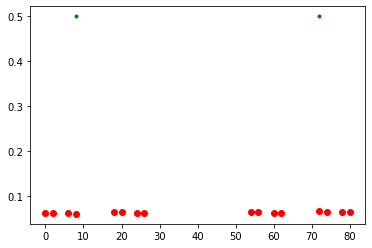

In [89]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-3):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(psi[i])**2>=1e-3:
        y.append(np.abs(psi[i])**2) 
        x.append(i)

        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")


In [90]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])**2>=1e-3:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

(-0.14731633927134197-0.20071298467581872j)|2 2 2 2>
(-0.16733873970913707+0.18160736439956363j)|2 2 2 0>
(0.1982436067065288-0.1455039018582835j)|2 2 0 2>
(-0.17937304345897576-0.16527996609310075j)|2 2 0 0>
(0.17085868132519139-0.18584477779410402j)|2 0 2 2>
(-0.2134294094787585-0.13094387220845394j)|2 0 2 0>
(0.18355832382734363+0.16875660176014576j)|2 0 0 2>
(0.12933286575679198-0.21080358094745225j)|2 0 0 0>
(-0.203636851945686+0.14946235599969582j)|0 2 2 2>
(0.18425291236743635+0.1697764308470904j)|0 2 2 0>
(-0.14762351607740615-0.20113150154823956j)|0 2 0 2>
(-0.16768766624266973+0.18198604316954897j)|0 2 0 0>
(-0.18855205387763985-0.1733476488770729j)|0 0 2 2>
(-0.13285138458369156+0.21653852205465893j)|0 0 2 0>
(0.17121494746835925-0.18623229221069124j)|0 0 0 2>
(-0.2138744420165487-0.1312169099491257j)|0 0 0 0>

